## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


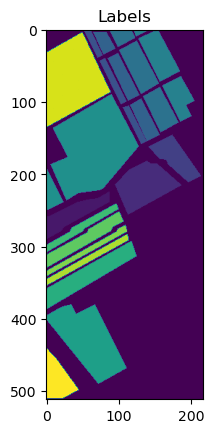

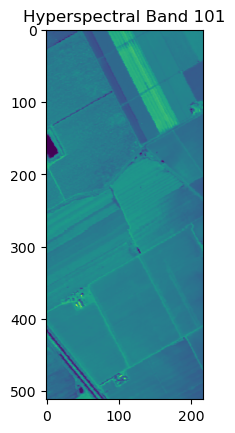

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53889 samples
	shape (53889, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(160, 5, 5, 204)
(80, 5, 5, 204)
(53889, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1542, PSNR: 7.1186


	 Training Batch [200/677], Loss: 0.0906, PSNR: 9.5102


	 Training Batch [400/677], Loss: 0.0444, PSNR: 12.6255


	 Training Batch [600/677], Loss: 0.0245, PSNR: 15.1892


Epoch [1/50] Training Loss: 0.0667, PSNR: 11.6405
	[Val]   Batch [1/170] Loss: 0.0208, PSNR: 15.9089
	[Val]   Batch [10/170] Loss: 0.0204, PSNR: 16.0778
	[Val]   Batch [20/170] Loss: 0.0205, PSNR: 15.9842
	[Val]   Batch [30/170] Loss: 0.0213, PSNR: 15.7653
	[Val]   Batch [40/170] Loss: 0.0214, PSNR: 15.8408
	[Val]   Batch [50/170] Loss: 0.0202, PSNR: 16.0663


	[Val]   Batch [60/170] Loss: 0.0212, PSNR: 15.9216
	[Val]   Batch [70/170] Loss: 0.0208, PSNR: 16.0078
	[Val]   Batch [80/170] Loss: 0.0211, PSNR: 15.8261
	[Val]   Batch [90/170] Loss: 0.0204, PSNR: 16.0674
	[Val]   Batch [100/170] Loss: 0.0205, PSNR: 15.9800


	[Val]   Batch [110/170] Loss: 0.0205, PSNR: 15.9792
	[Val]   Batch [120/170] Loss: 0.0193, PSNR: 14.3007
	[Val]   Batch [130/170] Loss: 0.0205, PSNR: 16.0619
	[Val]   Batch [140/170] Loss: 0.0200, PSNR: 16.1386


	[Val]   Batch [150/170] Loss: 0.0215, PSNR: 15.8626
	[Val]   Batch [160/170] Loss: 0.0211, PSNR: 15.9086
	[Val]   Batch [170/170] Loss: 0.0218, PSNR: 15.2070
Epoch [1/50] Validation Loss: 0.0208, PSNR: 15.8973

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0210, PSNR: 15.9030


	 Training Batch [200/677], Loss: 0.0145, PSNR: 17.4908


	 Training Batch [400/677], Loss: 0.0120, PSNR: 18.3777


	 Training Batch [600/677], Loss: 0.0094, PSNR: 19.3389


Epoch [2/50] Training Loss: 0.0129, PSNR: 18.1315
	[Val]   Batch [1/170] Loss: 0.0087, PSNR: 19.6993
	[Val]   Batch [10/170] Loss: 0.0082, PSNR: 20.0412
	[Val]   Batch [20/170] Loss: 0.0083, PSNR: 19.9184
	[Val]   Batch [30/170] Loss: 0.0090, PSNR: 19.5159
	[Val]   Batch [40/170] Loss: 0.0092, PSNR: 19.5001


	[Val]   Batch [50/170] Loss: 0.0080, PSNR: 20.0574
	[Val]   Batch [60/170] Loss: 0.0090, PSNR: 19.6494
	[Val]   Batch [70/170] Loss: 0.0088, PSNR: 19.7489
	[Val]   Batch [80/170] Loss: 0.0088, PSNR: 19.6119
	[Val]   Batch [90/170] Loss: 0.0085, PSNR: 19.8914


	[Val]   Batch [100/170] Loss: 0.0085, PSNR: 19.8115
	[Val]   Batch [110/170] Loss: 0.0084, PSNR: 19.8756
	[Val]   Batch [120/170] Loss: 0.0073, PSNR: 18.5135
	[Val]   Batch [130/170] Loss: 0.0085, PSNR: 19.9016


	[Val]   Batch [140/170] Loss: 0.0079, PSNR: 20.1850
	[Val]   Batch [150/170] Loss: 0.0092, PSNR: 19.5479
	[Val]   Batch [160/170] Loss: 0.0089, PSNR: 19.6419
	[Val]   Batch [170/170] Loss: 0.0091, PSNR: 18.9831
Epoch [2/50] Validation Loss: 0.0086, PSNR: 19.7464

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0078, PSNR: 20.1645


	 Training Batch [200/677], Loss: 0.0074, PSNR: 20.4465


	 Training Batch [400/677], Loss: 0.0058, PSNR: 21.5097


	 Training Batch [600/677], Loss: 0.0046, PSNR: 22.4483


Epoch [3/50] Training Loss: 0.0064, PSNR: 21.0823
	[Val]   Batch [1/170] Loss: 0.0046, PSNR: 22.4590
	[Val]   Batch [10/170] Loss: 0.0044, PSNR: 22.7440
	[Val]   Batch [20/170] Loss: 0.0044, PSNR: 22.6378
	[Val]   Batch [30/170] Loss: 0.0048, PSNR: 22.2265
	[Val]   Batch [40/170] Loss: 0.0049, PSNR: 22.2659


	[Val]   Batch [50/170] Loss: 0.0044, PSNR: 22.7004
	[Val]   Batch [60/170] Loss: 0.0048, PSNR: 22.3818
	[Val]   Batch [70/170] Loss: 0.0046, PSNR: 22.5222
	[Val]   Batch [80/170] Loss: 0.0047, PSNR: 22.3790
	[Val]   Batch [90/170] Loss: 0.0045, PSNR: 22.5960


	[Val]   Batch [100/170] Loss: 0.0046, PSNR: 22.4552
	[Val]   Batch [110/170] Loss: 0.0045, PSNR: 22.5677
	[Val]   Batch [120/170] Loss: 0.0040, PSNR: 21.1025
	[Val]   Batch [130/170] Loss: 0.0046, PSNR: 22.5513
	[Val]   Batch [140/170] Loss: 0.0042, PSNR: 22.9098


	[Val]   Batch [150/170] Loss: 0.0049, PSNR: 22.2997
	[Val]   Batch [160/170] Loss: 0.0047, PSNR: 22.3996
	[Val]   Batch [170/170] Loss: 0.0048, PSNR: 21.7462
Epoch [3/50] Validation Loss: 0.0046, PSNR: 22.4677

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0047, PSNR: 22.3099


	 Training Batch [200/677], Loss: 0.0035, PSNR: 23.7715


	 Training Batch [400/677], Loss: 0.0035, PSNR: 23.6766


	 Training Batch [600/677], Loss: 0.0029, PSNR: 24.4988


Epoch [4/50] Training Loss: 0.0036, PSNR: 23.6044
	[Val]   Batch [1/170] Loss: 0.0026, PSNR: 24.9212
	[Val]   Batch [10/170] Loss: 0.0025, PSNR: 25.1969
	[Val]   Batch [20/170] Loss: 0.0025, PSNR: 25.0499
	[Val]   Batch [30/170] Loss: 0.0028, PSNR: 24.6012
	[Val]   Batch [40/170] Loss: 0.0027, PSNR: 24.8255


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 25.0410
	[Val]   Batch [60/170] Loss: 0.0027, PSNR: 24.8265
	[Val]   Batch [70/170] Loss: 0.0026, PSNR: 25.0494
	[Val]   Batch [80/170] Loss: 0.0026, PSNR: 24.8776
	[Val]   Batch [90/170] Loss: 0.0026, PSNR: 25.0342


	[Val]   Batch [100/170] Loss: 0.0027, PSNR: 24.7802
	[Val]   Batch [110/170] Loss: 0.0025, PSNR: 25.0830
	[Val]   Batch [120/170] Loss: 0.0024, PSNR: 23.2983
	[Val]   Batch [130/170] Loss: 0.0027, PSNR: 24.8537
	[Val]   Batch [140/170] Loss: 0.0024, PSNR: 25.3373


	[Val]   Batch [150/170] Loss: 0.0028, PSNR: 24.7849
	[Val]   Batch [160/170] Loss: 0.0027, PSNR: 24.8812
	[Val]   Batch [170/170] Loss: 0.0027, PSNR: 24.2290
Epoch [4/50] Validation Loss: 0.0026, PSNR: 24.8964

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0029, PSNR: 24.6263


	 Training Batch [200/677], Loss: 0.0025, PSNR: 25.0980


	 Training Batch [400/677], Loss: 0.0023, PSNR: 25.5657


	 Training Batch [600/677], Loss: 0.0022, PSNR: 25.2942


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3628
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3929
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.6555
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.4653
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 25.9774
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.3726


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.4529
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.2591
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.5890
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.3346
	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.5180


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.1602
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.6542
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6537
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.2148
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.8027


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.2210
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.3597
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.6211
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.3314

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0020, PSNR: 26.1300


	 Training Batch [200/677], Loss: 0.0020, PSNR: 26.0953


	 Training Batch [400/677], Loss: 0.0017, PSNR: 26.9463


	 Training Batch [600/677], Loss: 0.0017, PSNR: 26.8206


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5888
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.5916
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.8421
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.6211
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.1036
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6183


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.5448
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4216
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.8344
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.5430
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7056


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.2741
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.9307
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.6912
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3389
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 27.9718


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.3871
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.5497
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.8595
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5021

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.8632


	 Training Batch [200/677], Loss: 0.0015, PSNR: 27.4908


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.2914


	 Training Batch [600/677], Loss: 0.0013, PSNR: 28.1106


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5210
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6715
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.9185
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6859
	[Val]   Batch [30/170] Loss: 0.0012, PSNR: 28.0964
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.7273


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5581
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4575
	[Val]   Batch [70/170] Loss: 0.0010, PSNR: 28.9677
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.6099
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7832


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2581
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0871
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.6962
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3214
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0910


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3979
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6225
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.9361
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5533

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0013, PSNR: 27.9953


	 Training Batch [200/677], Loss: 0.0013, PSNR: 28.1142


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.5238


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.5886


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2736
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.5882
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.8188
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.5922
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9495
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.6715


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.3913
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.3357
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9208
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.5266
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.7024


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.1107
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.0619
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.5314
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.1765
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.0163


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.2668
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.5259
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.8861
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.4473

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.5448


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.6871


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.2170


	 Training Batch [600/677], Loss: 0.0008, PSNR: 29.8426


Epoch [9/50] Training Loss: 0.0010, PSNR: 28.9606
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.3438
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.5569
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.2969
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.6568
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.4482


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.0856
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.0600
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.6925
	[Val]   Batch [80/170] Loss: 0.0008, PSNR: 30.2962
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.4888


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.8308
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.8561
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.2226
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 29.8866
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.7856


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 29.9770
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2381
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.6177
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.1756

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 28.9057


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.8145


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.7842


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.4953


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.5411
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.0393
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.3146
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 30.9945
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.4065
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.1357


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.7696
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.8164
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.3561
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.0733
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.2397


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.6055
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.6005
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.9063
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.6626


	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.5196
	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7558
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.9294
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.4790
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.9055

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.1621


	 Training Batch [200/677], Loss: 0.0010, PSNR: 28.5676


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.6538


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.8300


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.1451
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.7854
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.0573
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.6871
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.1648
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.8861


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.4725
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.5736
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.0601
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.8035
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.0712


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.4020
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.3626
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.6901
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.4681
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.2744


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.4867
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.6072
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.2339
Epoch [11/50] Validation Loss: 0.0006, PSNR: 31.6387

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.6036


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.8933


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.9294


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.1657


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7042
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.6089
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.9083
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.4795
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.0589
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.7401


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.1855
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.4530
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.8563
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.7122
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.9591


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.3048
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.2008
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.4523
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.4032


	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.0741
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.4180
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.4105
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.3351
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.4932

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.7709


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.7278


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.3130


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.3660


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.1613
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.1204
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.4606
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.9759
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.6331
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.2310


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.6884
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.0233
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.3242
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.2484


	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.5352
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.9272
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.7188
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.9970
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.0070


	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.6046
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.0118
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.8936
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.9174
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.0241

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.6205


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.5675


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1887


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.8512


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5741
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5553
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8593
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3815
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.1117
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6370


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.0402
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.5289
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.7407
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.7239


	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.0344
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.4658
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1370
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.4169


	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.5540
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0005
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.5365
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3205
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.4747
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.4774

LOG: Epoch [15/50]


	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.0145


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.2080


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.7560


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.3077


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9123
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.9031
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.1800
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.6700
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.4736
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.0048


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.3299
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.8913
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.0712
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.0756
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.4838


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.8958
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.4947
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7693
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.9817
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3341


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.9075
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6166
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.7589
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.8147

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.5556


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.7479


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.8261


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.7144


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2398
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.4304
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.7649
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.1565
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.0600
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.5492


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.7954
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.5003
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.5649
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.6972
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 35.0261


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.4666
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.9801
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.2077
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.5911
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.8267


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.5112
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.1335
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.6020
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.3620

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.8479


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.7960


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.1802


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.8278


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.4833
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.9749
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.3185
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6443
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.6212
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0989


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.3865
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.0396
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0472
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.2160
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5851


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9890
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.5785
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.7849
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0910
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.3841


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.0468
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5890
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.2041
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8879

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.3695


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.2604


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.0804


	 Training Batch [600/677], Loss: 0.0003, PSNR: 33.7811


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.7669
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 35.0950
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4563
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7677
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.7684
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.1884


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4950
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.1809
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1653
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.3355
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.7410


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.1798
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.7063
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.9662
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.2867


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.5160
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.1863
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.7125
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.2996
Epoch [18/50] Validation Loss: 0.0003, PSNR: 35.0224

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.3473


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.5341


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9213


	 Training Batch [600/677], Loss: 0.0003, PSNR: 33.8287


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.0291
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.5389
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.8731
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.1575
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.1972
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.6103


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.8675
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.6368
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.5870
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.8009
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.2102


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.6506
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.1550
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.3950
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.7784
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.9441


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.6606
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 35.0952
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.8636
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.4591
Early stopping triggered at epoch 19. No improvement for 3 epochs.


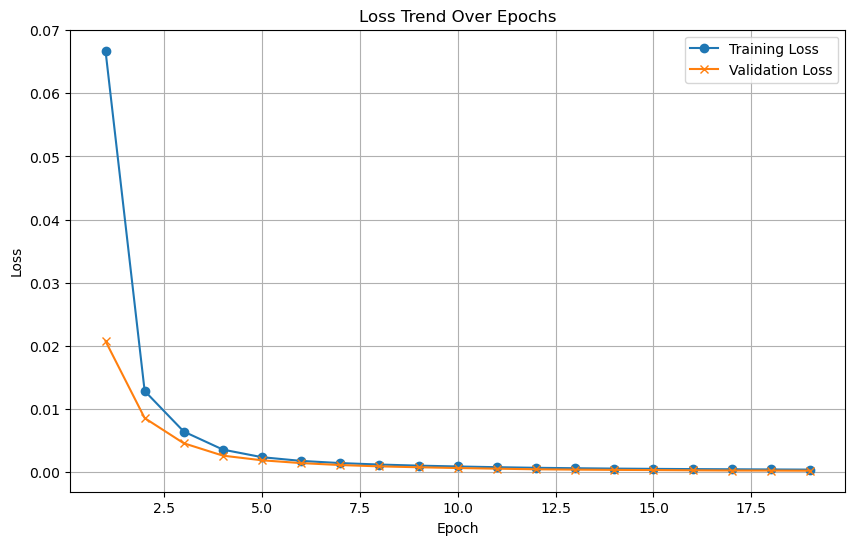

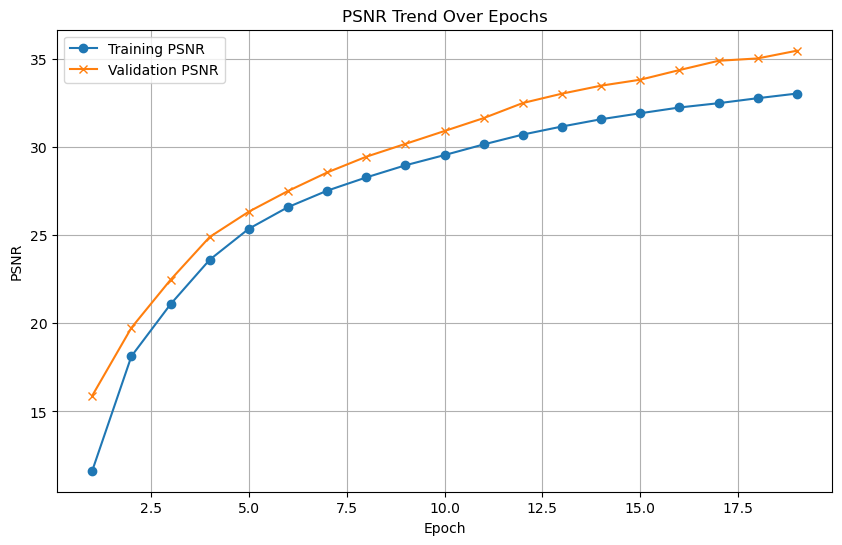

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7634
    Validation Batch [1/1], Loss: 2.7785
Validation Loss: 2.7785, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7785. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7223
    Validation Batch [1/1], Loss: 2.7785
Validation Loss: 2.7785, Validation Accuracy: 6.25%
Validation loss improved from 2.7785 to 2.7785. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6945
    Validation Batch [1/1], Loss: 2.7784
Validation Loss: 2.7784, Validation Accuracy: 6.25%
Validation loss improved from 2.7785 to 2.7784. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6716
    Validation Batch [1/1], Loss: 2.7784
Validation Loss: 2.7784, Validation Accuracy: 6.25%
Validation loss improved from 2.7784 to 2.7784. Saving model...

LOG: Epoch [5/1000] - 


LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4980
    Validation Batch [1/1], Loss: 2.7763
Validation Loss: 2.7763, Validation Accuracy: 6.25%
Validation loss improved from 2.7765 to 2.7763. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4646
    Validation Batch [1/1], Loss: 2.7761
Validation Loss: 2.7761, Validation Accuracy: 6.25%
Validation loss improved from 2.7763 to 2.7761. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4567
    Validation Batch [1/1], Loss: 2.7759
Validation Loss: 2.7759, Validation Accuracy: 6.25%
Validation loss improved from 2.7761 to 2.7759. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4520
    Validation Batch [1/1], Loss: 2.7754
Validation Loss: 2.7754, Validation Accuracy: 6.25%
Validation loss improved from 2.7759 to 2.7754. Saving model...

LOG: Epoch 

Validation Loss: 2.6600, Validation Accuracy: 32.50%
Validation loss improved from 2.6736 to 2.6600. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.2446
    Validation Batch [1/1], Loss: 2.6452
Validation Loss: 2.6452, Validation Accuracy: 33.75%
Validation loss improved from 2.6600 to 2.6452. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.2458
    Validation Batch [1/1], Loss: 2.6278
Validation Loss: 2.6278, Validation Accuracy: 33.75%
Validation loss improved from 2.6452 to 2.6278. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.2200
    Validation Batch [1/1], Loss: 2.6087
Validation Loss: 2.6087, Validation Accuracy: 37.50%
Validation loss improved from 2.6278 to 2.6087. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.1967
    Validation Batch [1/1], Loss: 2.5892
Validati

Epoch [71/1000] completed, Average Training Loss: 2.0437
    Validation Batch [1/1], Loss: 2.2098
Validation Loss: 2.2098, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 2.0087
    Validation Batch [1/1], Loss: 2.1980
Validation Loss: 2.1980, Validation Accuracy: 66.25%
Validation loss improved from 2.2074 to 2.1980. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.0268
    Validation Batch [1/1], Loss: 2.1779
Validation Loss: 2.1779, Validation Accuracy: 61.25%
Validation loss improved from 2.1980 to 2.1779. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 1.9998
    Validation Batch [1/1], Loss: 2.1544
Validation Loss: 2.1544, Validation Accuracy: 71.25%
Validation loss improved from 2.1779 to 2.1544. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] complet

    Validation Batch [1/1], Loss: 1.8852
Validation Loss: 1.8852, Validation Accuracy: 83.75%
Validation loss improved from 1.8932 to 1.8852. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8051
    Validation Batch [1/1], Loss: 1.8755
Validation Loss: 1.8755, Validation Accuracy: 86.25%
Validation loss improved from 1.8852 to 1.8755. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.7474
    Validation Batch [1/1], Loss: 1.8582
Validation Loss: 1.8582, Validation Accuracy: 87.50%
Validation loss improved from 1.8755 to 1.8582. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.7540
    Validation Batch [1/1], Loss: 1.8606
Validation Loss: 1.8606, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.7589
    Validation Batc

Epoch [125/1000] completed, Average Training Loss: 1.5385
    Validation Batch [1/1], Loss: 1.6310
Validation Loss: 1.6310, Validation Accuracy: 90.00%
Validation loss improved from 1.6477 to 1.6310. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.5484
    Validation Batch [1/1], Loss: 1.6247
Validation Loss: 1.6247, Validation Accuracy: 90.00%
Validation loss improved from 1.6310 to 1.6247. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.5148
    Validation Batch [1/1], Loss: 1.6320
Validation Loss: 1.6320, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.5300
    Validation Batch [1/1], Loss: 1.6127
Validation Loss: 1.6127, Validation Accuracy: 90.00%
Validation loss improved from 1.6247 to 1.6127. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000

Epoch [152/1000] completed, Average Training Loss: 1.3305
    Validation Batch [1/1], Loss: 1.3896
Validation Loss: 1.3896, Validation Accuracy: 91.25%
Validation loss improved from 1.4118 to 1.3896. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.2860
    Validation Batch [1/1], Loss: 1.4098
Validation Loss: 1.4098, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.3203
    Validation Batch [1/1], Loss: 1.4062
Validation Loss: 1.4062, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.3462
    Validation Batch [1/1], Loss: 1.3839
Validation Loss: 1.3839, Validation Accuracy: 88.75%
Validation loss improved from 1.3896 to 1.3839. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Av

Epoch [179/1000] completed, Average Training Loss: 1.1057
    Validation Batch [1/1], Loss: 1.1722
Validation Loss: 1.1722, Validation Accuracy: 90.00%
Validation loss improved from 1.1986 to 1.1722. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.0416
    Validation Batch [1/1], Loss: 1.1807
Validation Loss: 1.1807, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.0666
    Validation Batch [1/1], Loss: 1.1731
Validation Loss: 1.1731, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.0722
    Validation Batch [1/1], Loss: 1.1605
Validation Loss: 1.1605, Validation Accuracy: 91.25%
Validation loss improved from 1.1722 to 1.1605. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Av

Epoch [208/1000] completed, Average Training Loss: 0.8707
    Validation Batch [1/1], Loss: 0.9771
Validation Loss: 0.9771, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.8157
    Validation Batch [1/1], Loss: 0.9620
Validation Loss: 0.9620, Validation Accuracy: 91.25%
Validation loss improved from 0.9761 to 0.9620. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.9013
    Validation Batch [1/1], Loss: 0.9778
Validation Loss: 0.9778, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.8290
    Validation Batch [1/1], Loss: 0.9662
Validation Loss: 0.9662, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training 

Epoch [237/1000] completed, Average Training Loss: 0.6777
    Validation Batch [1/1], Loss: 0.7914
Validation Loss: 0.7914, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.6492
    Validation Batch [1/1], Loss: 0.7736
Validation Loss: 0.7736, Validation Accuracy: 91.25%
Validation loss improved from 0.7906 to 0.7736. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.6556
    Validation Batch [1/1], Loss: 0.7853
Validation Loss: 0.7853, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.6881
    Validation Batch [1/1], Loss: 0.7711
Validation Loss: 0.7711, Validation Accuracy: 91.25%
Validation loss improved from 0.7736 to 0.7711. Saving model...

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Av

Epoch [263/1000] completed, Average Training Loss: 0.5374
    Validation Batch [1/1], Loss: 0.6631
Validation Loss: 0.6631, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.5340
    Validation Batch [1/1], Loss: 0.6453
Validation Loss: 0.6453, Validation Accuracy: 92.50%
Validation loss improved from 0.6586 to 0.6453. Saving model...

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.5416
    Validation Batch [1/1], Loss: 0.6353
Validation Loss: 0.6353, Validation Accuracy: 93.75%
Validation loss improved from 0.6453 to 0.6353. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.5173
    Validation Batch [1/1], Loss: 0.6434
Validation Loss: 0.6434, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Av

    Validation Batch [1/1], Loss: 0.5579
Validation Loss: 0.5579, Validation Accuracy: 92.50%
Validation loss improved from 0.5588 to 0.5579. Saving model...

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.4515
    Validation Batch [1/1], Loss: 0.5515
Validation Loss: 0.5515, Validation Accuracy: 92.50%
Validation loss improved from 0.5579 to 0.5515. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4203
    Validation Batch [1/1], Loss: 0.5419
Validation Loss: 0.5419, Validation Accuracy: 93.75%
Validation loss improved from 0.5515 to 0.5419. Saving model...

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.3944
    Validation Batch [1/1], Loss: 0.5613
Validation Loss: 0.5613, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.3911
    Validation 

Epoch [317/1000] completed, Average Training Loss: 0.3592
    Validation Batch [1/1], Loss: 0.4687
Validation Loss: 0.4687, Validation Accuracy: 92.50%
Validation loss improved from 0.4752 to 0.4687. Saving model...

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.3444
    Validation Batch [1/1], Loss: 0.4656
Validation Loss: 0.4656, Validation Accuracy: 92.50%
Validation loss improved from 0.4687 to 0.4656. Saving model...

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.3687
    Validation Batch [1/1], Loss: 0.4751
Validation Loss: 0.4751, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.3812
    Validation Batch [1/1], Loss: 0.4574
Validation Loss: 0.4574, Validation Accuracy: 91.25%
Validation loss improved from 0.4656 to 0.4574. Saving model...

LOG: Epoch [321/1000] - Training
Epoch [321/1000

Epoch [345/1000] completed, Average Training Loss: 0.2581
    Validation Batch [1/1], Loss: 0.4168
Validation Loss: 0.4168, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2593
    Validation Batch [1/1], Loss: 0.4259
Validation Loss: 0.4259, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.3028
    Validation Batch [1/1], Loss: 0.4293
Validation Loss: 0.4293, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.2757
    Validation Batch [1/1], Loss: 0.4153
Validation Loss: 0.4153, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.2764
  

    Validation Batch [1/1], Loss: 0.3776
Validation Loss: 0.3776, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.2166
    Validation Batch [1/1], Loss: 0.3693
Validation Loss: 0.3693, Validation Accuracy: 93.75%
Validation loss improved from 0.3704 to 0.3693. Saving model...

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2553
    Validation Batch [1/1], Loss: 0.3590
Validation Loss: 0.3590, Validation Accuracy: 93.75%
Validation loss improved from 0.3693 to 0.3590. Saving model...

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.2325
    Validation Batch [1/1], Loss: 0.3683
Validation Loss: 0.3683, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2378
    Validation Batch [1/1], Lo

Epoch [395/1000] completed, Average Training Loss: 0.2292
    Validation Batch [1/1], Loss: 0.3393
Validation Loss: 0.3393, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.1866
    Validation Batch [1/1], Loss: 0.3494
Validation Loss: 0.3494, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1847
    Validation Batch [1/1], Loss: 0.3544
Validation Loss: 0.3544, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1764
    Validation Batch [1/1], Loss: 0.3494
Validation Loss: 0.3494, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1813
  

Epoch [422/1000] completed, Average Training Loss: 0.1734
    Validation Batch [1/1], Loss: 0.3130
Validation Loss: 0.3130, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1757
    Validation Batch [1/1], Loss: 0.3428
Validation Loss: 0.3428, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1703
    Validation Batch [1/1], Loss: 0.3669
Validation Loss: 0.3669, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1686
    Validation Batch [1/1], Loss: 0.3545
Validation Loss: 0.3545, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1635
  

Epoch [449/1000] completed, Average Training Loss: 0.1347
    Validation Batch [1/1], Loss: 0.3131
Validation Loss: 0.3131, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.1340
    Validation Batch [1/1], Loss: 0.2788
Validation Loss: 0.2788, Validation Accuracy: 92.50%
Validation loss improved from 0.2844 to 0.2788. Saving model...

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.1209
    Validation Batch [1/1], Loss: 0.2862
Validation Loss: 0.2862, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1275
    Validation Batch [1/1], Loss: 0.2880
Validation Loss: 0.2880, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.2701
Validation Loss: 0.2701, Validation Accuracy: 92.50%
Validation loss improved from 0.2707 to 0.2701. Saving model...

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1026
    Validation Batch [1/1], Loss: 0.2724
Validation Loss: 0.2724, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1119
    Validation Batch [1/1], Loss: 0.2900
Validation Loss: 0.2900, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.1516
    Validation Batch [1/1], Loss: 0.3205
Validation Loss: 0.3205, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.1367
    Validation Batch [1/1], Loss: 0.3087
Vali

    Validation Batch [1/1], Loss: 0.2875
Validation Loss: 0.2875, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.1157
    Validation Batch [1/1], Loss: 0.2969
Validation Loss: 0.2969, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.1127
    Validation Batch [1/1], Loss: 0.3034
Validation Loss: 0.3034, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0888
    Validation Batch [1/1], Loss: 0.2910
Validation Loss: 0.2910, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.1083
    Validation Batch [1/1], Loss: 0.2894
Validation Loss

Epoch [530/1000] completed, Average Training Loss: 0.0906
    Validation Batch [1/1], Loss: 0.2657
Validation Loss: 0.2657, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0883
    Validation Batch [1/1], Loss: 0.2499
Validation Loss: 0.2499, Validation Accuracy: 92.50%
Validation loss improved from 0.2513 to 0.2499. Saving model...

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0917
    Validation Batch [1/1], Loss: 0.2522
Validation Loss: 0.2522, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0986
    Validation Batch [1/1], Loss: 0.2473
Validation Loss: 0.2473, Validation Accuracy: 92.50%
Validation loss improved from 0.2499 to 0.2473. Saving model...

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Av

Epoch [556/1000] completed, Average Training Loss: 0.0704
    Validation Batch [1/1], Loss: 0.2368
Validation Loss: 0.2368, Validation Accuracy: 92.50%
Validation loss improved from 0.2473 to 0.2368. Saving model...

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0863
    Validation Batch [1/1], Loss: 0.2390
Validation Loss: 0.2390, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0814
    Validation Batch [1/1], Loss: 0.2533
Validation Loss: 0.2533, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0709
    Validation Batch [1/1], Loss: 0.2988
Validation Loss: 0.2988, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2405
Validation Loss: 0.2405, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0857
    Validation Batch [1/1], Loss: 0.2477
Validation Loss: 0.2477, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0714
    Validation Batch [1/1], Loss: 0.2545
Validation Loss: 0.2545, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.2717
Validation Loss: 0.2717, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0828
    Validation Batch [1/1], Loss: 0.2983
Validation Loss

Epoch [608/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.3102
Validation Loss: 0.3102, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [609/1000] - Training
Epoch [609/1000] completed, Average Training Loss: 0.0728
    Validation Batch [1/1], Loss: 0.2883
Validation Loss: 0.2883, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.2687
Validation Loss: 0.2687, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.2587
Validation Loss: 0.2587, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.057

    Validation Batch [1/1], Loss: 0.2207
Validation Loss: 0.2207, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [636/1000] - Training
Epoch [636/1000] completed, Average Training Loss: 0.0563
    Validation Batch [1/1], Loss: 0.2259
Validation Loss: 0.2259, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0538
    Validation Batch [1/1], Loss: 0.2317
Validation Loss: 0.2317, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.2318
Validation Loss: 0.2318, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0604
    Validation Batch [1/1], Loss: 0.2371
Validation Loss

    Validation Batch [1/1], Loss: 0.2577
Validation Loss: 0.2577, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.0506
    Validation Batch [1/1], Loss: 0.2450
Validation Loss: 0.2450, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.2494
Validation Loss: 0.2494, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.2632
Validation Loss: 0.2632, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0607
    Validation Batch [1/1], Loss: 0.2682
Validation Loss

Epoch [690/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.2254
Validation Loss: 0.2254, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [691/1000] - Training
Epoch [691/1000] completed, Average Training Loss: 0.0503
    Validation Batch [1/1], Loss: 0.2181
Validation Loss: 0.2181, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0528
    Validation Batch [1/1], Loss: 0.2184
Validation Loss: 0.2184, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.2288
Validation Loss: 0.2288, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.048

Epoch [717/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.2634
Validation Loss: 0.2634, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.2615
Validation Loss: 0.2615, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.2540
Validation Loss: 0.2540, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.2461
Validation Loss: 0.2461, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.038

Epoch [745/1000] completed, Average Training Loss: 0.0521
    Validation Batch [1/1], Loss: 0.2813
Validation Loss: 0.2813, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.2518
Validation Loss: 0.2518, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.2602
Validation Loss: 0.2602, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [748/1000] - Training
Epoch [748/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.2346
Validation Loss: 0.2346, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [749/1000] - Training
Epoch [749/1000] completed, Average Training Loss: 0.046

Epoch [772/1000] completed, Average Training Loss: 0.0353
    Validation Batch [1/1], Loss: 0.2047
Validation Loss: 0.2047, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [773/1000] - Training
Epoch [773/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.2150
Validation Loss: 0.2150, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [774/1000] - Training
Epoch [774/1000] completed, Average Training Loss: 0.0350
    Validation Batch [1/1], Loss: 0.2214
Validation Loss: 0.2214, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [775/1000] - Training
Epoch [775/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.2278
Validation Loss: 0.2278, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [776/1000] - Training
Epoch [776/1000] completed, Average Training Loss: 0.030

Epoch [799/1000] completed, Average Training Loss: 0.0453
    Validation Batch [1/1], Loss: 0.2872
Validation Loss: 0.2872, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [800/1000] - Training
Epoch [800/1000] completed, Average Training Loss: 0.0414
    Validation Batch [1/1], Loss: 0.2644
Validation Loss: 0.2644, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [801/1000] - Training
Epoch [801/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.2533
Validation Loss: 0.2533, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [802/1000] - Training
Epoch [802/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.2493
Validation Loss: 0.2493, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [803/1000] - Training
Epoch [803/1000] completed, Average Training Loss: 0.034

Epoch [825/1000] completed, Average Training Loss: 0.0324
    Validation Batch [1/1], Loss: 0.2255
Validation Loss: 0.2255, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0330
    Validation Batch [1/1], Loss: 0.2381
Validation Loss: 0.2381, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [827/1000] - Training
Epoch [827/1000] completed, Average Training Loss: 0.0337
    Validation Batch [1/1], Loss: 0.2433
Validation Loss: 0.2433, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [828/1000] - Training
Epoch [828/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.2338
Validation Loss: 0.2338, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [829/1000] - Training
Epoch [829/1000] completed, Average Training Loss: 0.039

Epoch [851/1000] completed, Average Training Loss: 0.0354
    Validation Batch [1/1], Loss: 0.2266
Validation Loss: 0.2266, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [852/1000] - Training
Epoch [852/1000] completed, Average Training Loss: 0.0283
    Validation Batch [1/1], Loss: 0.2426
Validation Loss: 0.2426, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.2411
Validation Loss: 0.2411, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [854/1000] - Training
Epoch [854/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.2292
Validation Loss: 0.2292, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [855/1000] - Training
Epoch [855/1000] completed, Average Training Loss: 0.020

    Validation Batch [1/1], Loss: 0.3236
Validation Loss: 0.3236, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [878/1000] - Training
Epoch [878/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.2996
Validation Loss: 0.2996, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [879/1000] - Training
Epoch [879/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.2743
Validation Loss: 0.2743, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [880/1000] - Training
Epoch [880/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.2553
Validation Loss: 0.2553, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [881/1000] - Training
Epoch [881/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.2346
Validation Loss

Epoch [904/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.2316
Validation Loss: 0.2316, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [905/1000] - Training
Epoch [905/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.2267
Validation Loss: 0.2267, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [906/1000] - Training
Epoch [906/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.2213
Validation Loss: 0.2213, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [907/1000] - Training
Epoch [907/1000] completed, Average Training Loss: 0.0179
    Validation Batch [1/1], Loss: 0.2229
Validation Loss: 0.2229, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [908/1000] - Training
Epoch [908/1000] completed, Average Training Loss: 0.019

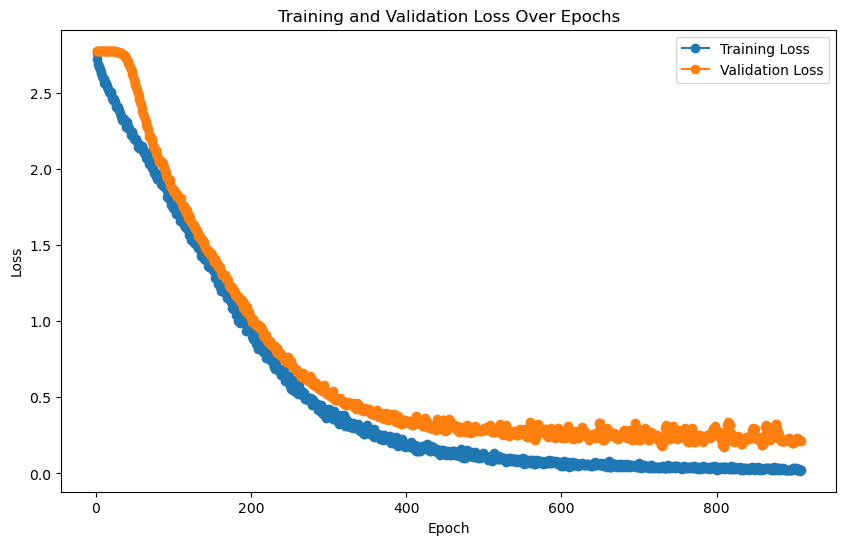

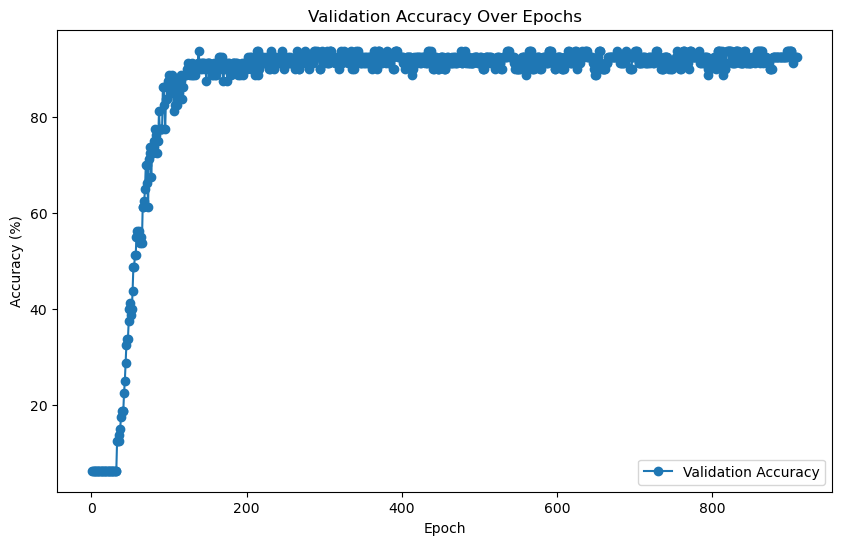


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.3854



Final Test Loss: 0.5248, Test Accuracy: 85.76%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.


  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53889, 64), Test labels shape: (53889,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.50      0.60      0.55         5
           8       0.83      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53889, 64)
Test labels shape: (53889,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8110  |  Val Loss: 2.6941
Validation loss improved from inf to 2.6941.
[Epoch 2/1000] Train Loss: 2.6755  |  Val Loss: 2.6007
Validation loss improved from 2.6941 to 2.6007.
[Epoch 3/1000] Train Loss: 2.5933  |  Val Loss: 2.5278
Validation loss improved from 2.6007 to 2.5278.
[Epoch 4/1000] Train Loss: 2.5194  |  Val Loss: 2.4613
Validation loss improved from 2.5278 to 2.4613.
[Epoch 5/1000] Train Loss: 2.4581  |  Val Loss: 2.3971
Validation loss improved from 2.4613 to 2.3971.
[Epoch 6/1000] Train Loss: 2.3936  |  Val Loss: 2.3333
Validation loss improved from 2.3971 to 2.3333.
[Epoch 7/1000] Train Loss: 2.3294  |  Val Loss: 2.2716
Validation loss improved from 2.3333 to 2.2716.
[Epoch 8/1000] Train Loss: 2.2670  |  Val Loss: 2.2091
Validation loss improved from 2.2716 to 2.2091.
[Epoch 9/1000] Train Loss: 2.1984  |  Val Loss: 2.1381
Validation loss improved from 2.2091 to 2.1381.
[Epoch 10/1000] Train Loss: 2.1225  |  Val Loss: 2.0665
Validation loss impr

[Epoch 18/1000] Train Loss: 1.4842  |  Val Loss: 1.4575
Validation loss improved from 1.5284 to 1.4575.
[Epoch 19/1000] Train Loss: 1.4074  |  Val Loss: 1.3898
Validation loss improved from 1.4575 to 1.3898.
[Epoch 20/1000] Train Loss: 1.3325  |  Val Loss: 1.3263
Validation loss improved from 1.3898 to 1.3263.
[Epoch 21/1000] Train Loss: 1.2598  |  Val Loss: 1.2653
Validation loss improved from 1.3263 to 1.2653.
[Epoch 22/1000] Train Loss: 1.1938  |  Val Loss: 1.2062
Validation loss improved from 1.2653 to 1.2062.
[Epoch 23/1000] Train Loss: 1.1331  |  Val Loss: 1.1522
Validation loss improved from 1.2062 to 1.1522.
[Epoch 24/1000] Train Loss: 1.0650  |  Val Loss: 1.0988
Validation loss improved from 1.1522 to 1.0988.
[Epoch 25/1000] Train Loss: 1.0149  |  Val Loss: 1.0492
Validation loss improved from 1.0988 to 1.0492.
[Epoch 26/1000] Train Loss: 0.9601  |  Val Loss: 1.0029
Validation loss improved from 1.0492 to 1.0029.
[Epoch 27/1000] Train Loss: 0.9070  |  Val Loss: 0.9746
Validati

[Epoch 30/1000] Train Loss: 0.7773  |  Val Loss: 0.8728
Validation loss improved from 0.9244 to 0.8728.
[Epoch 31/1000] Train Loss: 0.7350  |  Val Loss: 0.8366
Validation loss improved from 0.8728 to 0.8366.
[Epoch 32/1000] Train Loss: 0.7050  |  Val Loss: 0.8086
Validation loss improved from 0.8366 to 0.8086.
[Epoch 33/1000] Train Loss: 0.6661  |  Val Loss: 0.7901
Validation loss improved from 0.8086 to 0.7901.
[Epoch 34/1000] Train Loss: 0.6326  |  Val Loss: 0.7725
Validation loss improved from 0.7901 to 0.7725.
[Epoch 35/1000] Train Loss: 0.6056  |  Val Loss: 0.7461
Validation loss improved from 0.7725 to 0.7461.
[Epoch 36/1000] Train Loss: 0.5770  |  Val Loss: 0.7127
Validation loss improved from 0.7461 to 0.7127.
[Epoch 37/1000] Train Loss: 0.5488  |  Val Loss: 0.7051
Validation loss improved from 0.7127 to 0.7051.
[Epoch 38/1000] Train Loss: 0.5279  |  Val Loss: 0.7012
Validation loss improved from 0.7051 to 0.7012.
[Epoch 39/1000] Train Loss: 0.5051  |  Val Loss: 0.6897
Validati

[Epoch 51/1000] Train Loss: 0.3429  |  Val Loss: 0.5554
Validation loss improved from 0.5715 to 0.5554.
[Epoch 52/1000] Train Loss: 0.3307  |  Val Loss: 0.5702
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.3193  |  Val Loss: 0.5830
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 54/1000] Train Loss: 0.3149  |  Val Loss: 0.5414
Validation loss improved from 0.5554 to 0.5414.
[Epoch 55/1000] Train Loss: 0.3077  |  Val Loss: 0.5326
Validation loss improved from 0.5414 to 0.5326.
[Epoch 56/1000] Train Loss: 0.3045  |  Val Loss: 0.5415
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.2907  |  Val Loss: 0.5523
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.2873  |  Val Loss: 0.5418
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.2847  |  Val Loss: 0.5135
Validation loss improved from 0.5326 to 0.5135.
[Epoch 60/1000] Train Loss: 0.2757

[Epoch 62/1000] Train Loss: 0.2561  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 63/1000] Train Loss: 0.2715  |  Val Loss: 0.5179
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 64/1000] Train Loss: 0.2499  |  Val Loss: 0.5479
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 65/1000] Train Loss: 0.2482  |  Val Loss: 0.5018
Validation loss improved from 0.5135 to 0.5018.
[Epoch 66/1000] Train Loss: 0.2428  |  Val Loss: 0.4926
Validation loss improved from 0.5018 to 0.4926.
[Epoch 67/1000] Train Loss: 0.2257  |  Val Loss: 0.5254
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.2347  |  Val Loss: 0.5135
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 0.2160  |  Val Loss: 0.4912
Validation loss improved from 0.4926 to 0.4912.
[Epoch 70/1000] Train Loss: 0.2236  |  Val Loss: 0.4808
Validation loss improved from 0.4912 to 0.4808.
[Epoch 71/1000] Train Loss: 0.2155

[Epoch 81/1000] Train Loss: 0.1768  |  Val Loss: 0.4841
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 82/1000] Train Loss: 0.1772  |  Val Loss: 0.4787
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 83/1000] Train Loss: 0.1713  |  Val Loss: 0.4961
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 84/1000] Train Loss: 0.1759  |  Val Loss: 0.4862
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 85/1000] Train Loss: 0.1722  |  Val Loss: 0.4735
Validation loss improved from 0.4781 to 0.4735.
[Epoch 86/1000] Train Loss: 0.1725  |  Val Loss: 0.4966
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 87/1000] Train Loss: 0.1711  |  Val Loss: 0.5147
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 88/1000] Train Loss: 0.1659  |  Val Loss: 0.5078
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 89/1000] Train Loss: 0.1802  |  Val Loss: 0.4867
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 90/1000] Train Loss: 0.1644  |  Val Loss: 0.5187
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 91/1000] Train Loss: 0.1709  |  Val Loss: 0.4703
Validation loss improved from 0.4735 to 0.4703.
[Epoch 92/1000] Train Loss: 0.1682  |  Val Loss: 0.4769
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 0.1550  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 0.1605  |  Val Loss: 0.4933
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 95/1000] Train Loss: 0.1449  |  Val Loss: 0.4799
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 96/1000] Train Loss: 0.1432  |  Val Loss: 0.4773
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 97/1000] Train Loss: 0.1373  |  Val Loss: 0.4878
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 98/1000] Train Loss: 0.1384  |  Val Loss: 0.4918
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 99/1000] 

[Epoch 110/1000] Train Loss: 0.1194  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 111/1000] Train Loss: 0.1168  |  Val Loss: 0.5111
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 112/1000] Train Loss: 0.1139  |  Val Loss: 0.4953
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 113/1000] Train Loss: 0.1081  |  Val Loss: 0.4849
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 114/1000] Train Loss: 0.1132  |  Val Loss: 0.4825
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 115/1000] Train Loss: 0.1042  |  Val Loss: 0.5249
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 116/1000] Train Loss: 0.1108  |  Val Loss: 0.5215
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 117/1000] Train Loss: 0.1041  |  Val Loss: 0.5089
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 118/1000] Train Loss: 0.1012  |  Val Loss: 0.4993
!! Validation loss did NOT improve !! Patience:

[Epoch 119/1000] Train Loss: 0.1002  |  Val Loss: 0.4879
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 120/1000] Train Loss: 0.0987  |  Val Loss: 0.4967
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 121/1000] Train Loss: 0.1043  |  Val Loss: 0.5230
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 122/1000] Train Loss: 0.1010  |  Val Loss: 0.5226
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 123/1000] Train Loss: 0.1053  |  Val Loss: 0.5089
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 124/1000] Train Loss: 0.0960  |  Val Loss: 0.5161
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 125/1000] Train Loss: 0.0968  |  Val Loss: 0.5047
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 126/1000] Train Loss: 0.0908  |  Val Loss: 0.5110
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 127/1000] Train Loss: 0.0872  |  Val Loss: 0.5020
!! Validation loss did NOT improve !! Patience:

[Epoch 138/1000] Train Loss: 0.0820  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 139/1000] Train Loss: 0.0771  |  Val Loss: 0.5139
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 140/1000] Train Loss: 0.0755  |  Val Loss: 0.5140
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 141/1000] Train Loss: 0.0735  |  Val Loss: 0.5239
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 142/1000] Train Loss: 0.0774  |  Val Loss: 0.5109
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 143/1000] Train Loss: 0.0760  |  Val Loss: 0.5067
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 144/1000] Train Loss: 0.0738  |  Val Loss: 0.5378
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 145/1000] Train Loss: 0.0782  |  Val Loss: 0.5225
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 146/1000] Train Loss: 0.0772  |  Val Loss: 0.5326
!! Validation loss did NOT improve !! Patience:

[Epoch 147/1000] Train Loss: 0.0702  |  Val Loss: 0.5804
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 148/1000] Train Loss: 0.0805  |  Val Loss: 0.5319
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 149/1000] Train Loss: 0.0791  |  Val Loss: 0.5327
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 150/1000] Train Loss: 0.0821  |  Val Loss: 0.5699
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 151/1000] Train Loss: 0.0814  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 152/1000] Train Loss: 0.0710  |  Val Loss: 0.5310
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 153/1000] Train Loss: 0.0631  |  Val Loss: 0.5814
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 154/1000] Train Loss: 0.0796  |  Val Loss: 0.5356
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 155/1000] Train Loss: 0.0622  |  Val Loss: 0.5213
!! Validation loss did NOT improve !! Patience:

[Epoch 166/1000] Train Loss: 0.0576  |  Val Loss: 0.5483
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 167/1000] Train Loss: 0.0553  |  Val Loss: 0.5377
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 168/1000] Train Loss: 0.0541  |  Val Loss: 0.5467
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 169/1000] Train Loss: 0.0527  |  Val Loss: 0.5515
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 170/1000] Train Loss: 0.0521  |  Val Loss: 0.5639
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 171/1000] Train Loss: 0.0514  |  Val Loss: 0.5564
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 172/1000] Train Loss: 0.0536  |  Val Loss: 0.5492
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 173/1000] Train Loss: 0.0491  |  Val Loss: 0.5535
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 174/1000] Train Loss: 0.0490  |  Val Loss: 0.5698
!! Validation loss did NOT improve !! Patience:

[Epoch 177/1000] Train Loss: 0.0499  |  Val Loss: 0.5538
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 178/1000] Train Loss: 0.0458  |  Val Loss: 0.5604
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 179/1000] Train Loss: 0.0474  |  Val Loss: 0.5541
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 180/1000] Train Loss: 0.0437  |  Val Loss: 0.5583
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 181/1000] Train Loss: 0.0493  |  Val Loss: 0.5545
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 182/1000] Train Loss: 0.0452  |  Val Loss: 0.5576
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 183/1000] Train Loss: 0.0426  |  Val Loss: 0.5695
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 184/1000] Train Loss: 0.0481  |  Val Loss: 0.5611
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 185/1000] Train Loss: 0.0433  |  Val Loss: 0.5603
!! Validation loss did NOT improve !! Patience:

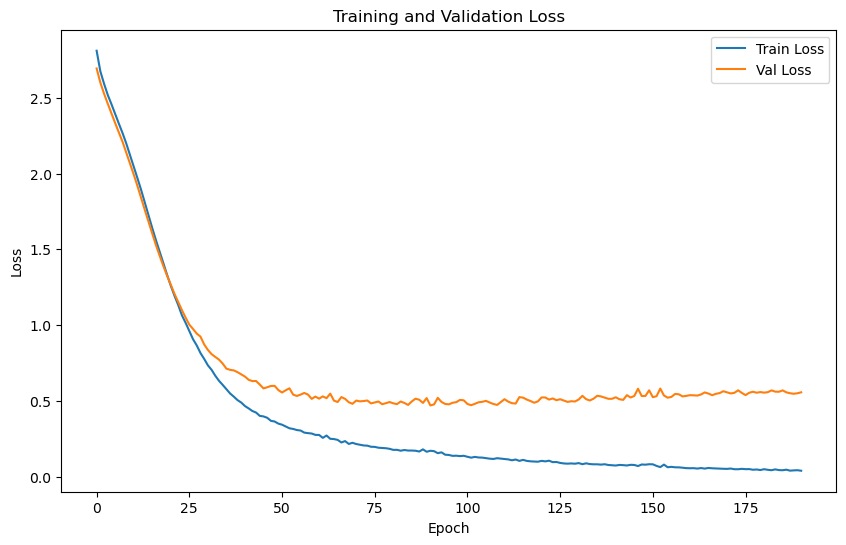

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.8636 | Test Accuracy: 81.12%


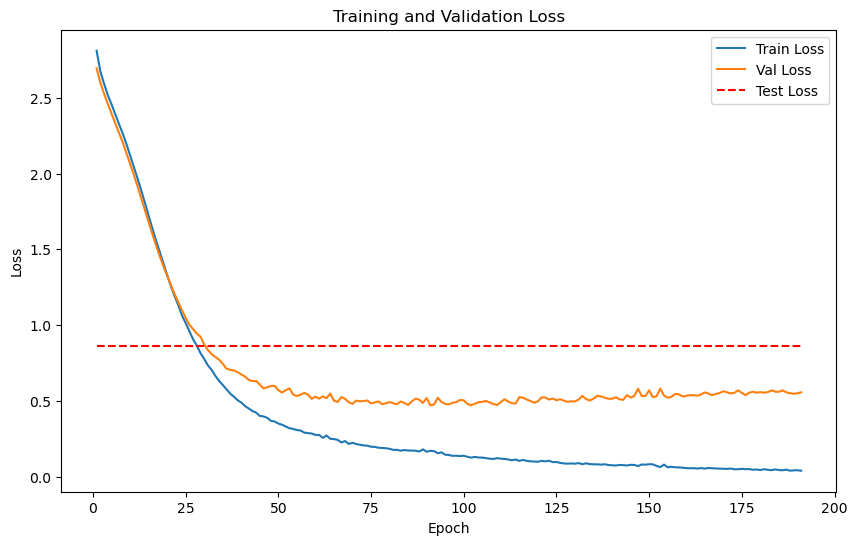

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.2900
Epoch [1/2000], Avg Train Loss: 8.2900
Epoch [1/2000], Avg Val Loss: 3.5062
Validation loss improved from inf to 3.5062. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3962
Epoch [2/2000], Avg Train Loss: 8.3962
Epoch [2/2000], Avg Val Loss: 3.4841
Validation loss improved from 3.5062 to 3.4841. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.0747
Epoch [3/2000], Avg Train Loss: 8.0747
Epoch [3/2000], Avg Val Loss: 3.4625
Validation loss improved from 3.4841 to 3.4625. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.0213
Epoch [4/2000], Avg Train Loss: 8.0213
Epoch [4/2000], Avg Val Loss: 3.4416
Validation loss improved from 3.4625 to 3.4416. Saving model...

LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 8.0405
Epoch [5/2000], Avg Train Loss: 8.0405
Epoch [5/2000], Avg Val Loss: 3.4212
Validation loss improved from 3.4416 to 3.4212. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.9272
Epoch [6/2000], Avg Train Loss: 7.9272
Epoch [6/2000], Avg Val Loss: 3.4014
Validation loss improved from 3.4212 to 3.4014. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.7457
Epoch [7/2000], Avg Train Loss: 7.7457
Epoch [7/2000], Avg Val Loss: 3.3822
Validation loss improved from 3.4014 to 3.3822. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.8126
Epoch [8/2000], Avg Train Loss: 7.8126
Epoch [8/2000], Avg Val Loss: 3.3636
Validation loss improved from 3.3822 to 3.3636. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.6603
Epoch [9/2000], Avg Train Loss: 7.6603
Epoch [9/2000], Avg Val Loss: 3.3455
Validation loss improved from 3.3636 to 3.3455. Saving m

Epoch [22/2000], Avg Val Loss: 3.1560
Validation loss improved from 3.1680 to 3.1560. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.7728
Epoch [23/2000], Avg Train Loss: 6.7728
Epoch [23/2000], Avg Val Loss: 3.1443
Validation loss improved from 3.1560 to 3.1443. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.8671
Epoch [24/2000], Avg Train Loss: 6.8671
Epoch [24/2000], Avg Val Loss: 3.1330
Validation loss improved from 3.1443 to 3.1330. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7015
Epoch [25/2000], Avg Train Loss: 6.7015
Epoch [25/2000], Avg Val Loss: 3.1221
Validation loss improved from 3.1330 to 3.1221. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.6328
Epoch [26/2000], Avg Train Loss: 6.6328
Epoch [26/2000], Avg Val Loss: 3.1115
Validation loss improved from 3.1221 to 3.1115. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5380
Epoch [46/2000], Avg Train Loss: 5.5380
Epoch [46/2000], Avg Val Loss: 2.9665
Validation loss improved from 2.9713 to 2.9665. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.7488
Epoch [47/2000], Avg Train Loss: 5.7488
Epoch [47/2000], Avg Val Loss: 2.9619
Validation loss improved from 2.9665 to 2.9619. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.5141
Epoch [48/2000], Avg Train Loss: 5.5141
Epoch [48/2000], Avg Val Loss: 2.9574
Validation loss improved from 2.9619 to 2.9574. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.4857
Epoch [49/2000], Avg Train Loss: 5.4857
Epoch [49/2000], Avg Val Loss: 2.9532
Validation loss improved from 2.9574 to 2.9532. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.4397
Epoch [50/2000], Avg Train Loss: 5.4397
Epoch [50/2000], Avg Val Loss: 2.9491
Validation loss improved from 2.9532 to 2.

    Batch [1/1], Train Loss: 5.0680
Epoch [64/2000], Avg Train Loss: 5.0680
Epoch [64/2000], Avg Val Loss: 2.9071
Validation loss improved from 2.9091 to 2.9071. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 4.9956
Epoch [65/2000], Avg Train Loss: 4.9956
Epoch [65/2000], Avg Val Loss: 2.9051
Validation loss improved from 2.9071 to 2.9051. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 4.8757
Epoch [66/2000], Avg Train Loss: 4.8757
Epoch [66/2000], Avg Val Loss: 2.9033
Validation loss improved from 2.9051 to 2.9033. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 4.9813
Epoch [67/2000], Avg Train Loss: 4.9813
Epoch [67/2000], Avg Val Loss: 2.9016
Validation loss improved from 2.9033 to 2.9016. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.0069
Epoch [68/2000], Avg Train Loss: 5.0069
Epoch [68/2000], Avg Val Loss: 2.8999
Validation loss improved from 2.9016 to 2.

    Batch [1/1], Train Loss: 4.6284
Epoch [87/2000], Avg Train Loss: 4.6284
Epoch [87/2000], Avg Val Loss: 2.8799
Validation loss improved from 2.8806 to 2.8799. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.6559
Epoch [88/2000], Avg Train Loss: 4.6559
Epoch [88/2000], Avg Val Loss: 2.8792
Validation loss improved from 2.8799 to 2.8792. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.6335
Epoch [89/2000], Avg Train Loss: 4.6335
Epoch [89/2000], Avg Val Loss: 2.8785
Validation loss improved from 2.8792 to 2.8785. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 4.6028
Epoch [90/2000], Avg Train Loss: 4.6028
Epoch [90/2000], Avg Val Loss: 2.8778
Validation loss improved from 2.8785 to 2.8778. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.5536
Epoch [91/2000], Avg Train Loss: 4.5536
Epoch [91/2000], Avg Val Loss: 2.8771
Validation loss improved from 2.8778 to 2.

    Batch [1/1], Train Loss: 4.4955
Epoch [105/2000], Avg Train Loss: 4.4955
Epoch [105/2000], Avg Val Loss: 2.8686
Validation loss improved from 2.8691 to 2.8686. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.4458
Epoch [106/2000], Avg Train Loss: 4.4458
Epoch [106/2000], Avg Val Loss: 2.8681
Validation loss improved from 2.8686 to 2.8681. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.4126
Epoch [107/2000], Avg Train Loss: 4.4126
Epoch [107/2000], Avg Val Loss: 2.8676
Validation loss improved from 2.8681 to 2.8676. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.4344
Epoch [108/2000], Avg Train Loss: 4.4344
Epoch [108/2000], Avg Val Loss: 2.8672
Validation loss improved from 2.8676 to 2.8672. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.3672
Epoch [109/2000], Avg Train Loss: 4.3672
Epoch [109/2000], Avg Val Loss: 2.8667
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2435
Epoch [129/2000], Avg Train Loss: 4.2435
Epoch [129/2000], Avg Val Loss: 2.8572
Validation loss improved from 2.8578 to 2.8572. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.2278
Epoch [130/2000], Avg Train Loss: 4.2278
Epoch [130/2000], Avg Val Loss: 2.8566
Validation loss improved from 2.8572 to 2.8566. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.2343
Epoch [131/2000], Avg Train Loss: 4.2343
Epoch [131/2000], Avg Val Loss: 2.8560
Validation loss improved from 2.8566 to 2.8560. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.1422
Epoch [132/2000], Avg Train Loss: 4.1422
Epoch [132/2000], Avg Val Loss: 2.8554
Validation loss improved from 2.8560 to 2.8554. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.2538
Epoch [133/2000], Avg Train Loss: 4.2538
Epoch [133/2000], Avg Val Loss: 2.8548
Validation loss improved fro

Epoch [148/2000], Avg Val Loss: 2.8460
Validation loss improved from 2.8467 to 2.8460. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.0873
Epoch [149/2000], Avg Train Loss: 4.0873
Epoch [149/2000], Avg Val Loss: 2.8454
Validation loss improved from 2.8460 to 2.8454. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.1631
Epoch [150/2000], Avg Train Loss: 4.1631
Epoch [150/2000], Avg Val Loss: 2.8447
Validation loss improved from 2.8454 to 2.8447. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.1524
Epoch [151/2000], Avg Train Loss: 4.1524
Epoch [151/2000], Avg Val Loss: 2.8440
Validation loss improved from 2.8447 to 2.8440. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.0822
Epoch [152/2000], Avg Train Loss: 4.0822
Epoch [152/2000], Avg Val Loss: 2.8434
Validation loss improved from 2.8440 to 2.8434. Saving model...

LOG: Epoch [153/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0553
Epoch [169/2000], Avg Train Loss: 4.0553
Epoch [169/2000], Avg Val Loss: 2.8323
Validation loss improved from 2.8329 to 2.8323. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 4.0636
Epoch [170/2000], Avg Train Loss: 4.0636
Epoch [170/2000], Avg Val Loss: 2.8316
Validation loss improved from 2.8323 to 2.8316. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 3.9951
Epoch [171/2000], Avg Train Loss: 3.9951
Epoch [171/2000], Avg Val Loss: 2.8309
Validation loss improved from 2.8316 to 2.8309. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 3.9750
Epoch [172/2000], Avg Train Loss: 3.9750
Epoch [172/2000], Avg Val Loss: 2.8302
Validation loss improved from 2.8309 to 2.8302. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 3.9708
Epoch [173/2000], Avg Train Loss: 3.9708
Epoch [173/2000], Avg Val Loss: 2.8295
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9668
Epoch [195/2000], Avg Train Loss: 3.9668
Epoch [195/2000], Avg Val Loss: 2.8124
Validation loss improved from 2.8131 to 2.8124. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.9300
Epoch [196/2000], Avg Train Loss: 3.9300
Epoch [196/2000], Avg Val Loss: 2.8116
Validation loss improved from 2.8124 to 2.8116. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.8883
Epoch [197/2000], Avg Train Loss: 3.8883
Epoch [197/2000], Avg Val Loss: 2.8109
Validation loss improved from 2.8116 to 2.8109. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 3.9579
Epoch [198/2000], Avg Train Loss: 3.9579
Epoch [198/2000], Avg Val Loss: 2.8100
Validation loss improved from 2.8109 to 2.8100. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 3.9220
Epoch [199/2000], Avg Train Loss: 3.9220
Epoch [199/2000], Avg Val Loss: 2.8093
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9475
Epoch [213/2000], Avg Train Loss: 3.9475
Epoch [213/2000], Avg Val Loss: 2.7981
Validation loss improved from 2.7989 to 2.7981. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 3.9444
Epoch [214/2000], Avg Train Loss: 3.9444
Epoch [214/2000], Avg Val Loss: 2.7974
Validation loss improved from 2.7981 to 2.7974. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 3.9086
Epoch [215/2000], Avg Train Loss: 3.9086
Epoch [215/2000], Avg Val Loss: 2.7966
Validation loss improved from 2.7974 to 2.7966. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 3.8759
Epoch [216/2000], Avg Train Loss: 3.8759
Epoch [216/2000], Avg Val Loss: 2.7958
Validation loss improved from 2.7966 to 2.7958. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 3.8800
Epoch [217/2000], Avg Train Loss: 3.8800
Epoch [217/2000], Avg Val Loss: 2.7950
Validation loss improved fro

Epoch [236/2000], Avg Val Loss: 2.7800
Validation loss improved from 2.7807 to 2.7800. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.8549
Epoch [237/2000], Avg Train Loss: 3.8549
Epoch [237/2000], Avg Val Loss: 2.7793
Validation loss improved from 2.7800 to 2.7793. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 3.8367
Epoch [238/2000], Avg Train Loss: 3.8367
Epoch [238/2000], Avg Val Loss: 2.7785
Validation loss improved from 2.7793 to 2.7785. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 3.9137
Epoch [239/2000], Avg Train Loss: 3.9137
Epoch [239/2000], Avg Val Loss: 2.7778
Validation loss improved from 2.7785 to 2.7778. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.8109
Epoch [240/2000], Avg Train Loss: 3.8109
Epoch [240/2000], Avg Val Loss: 2.7771
Validation loss improved from 2.7778 to 2.7771. Saving model...

LOG: Epoch [241/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7843
Epoch [258/2000], Avg Train Loss: 3.7843
Epoch [258/2000], Avg Val Loss: 2.7638
Validation loss improved from 2.7645 to 2.7638. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.7959
Epoch [259/2000], Avg Train Loss: 3.7959
Epoch [259/2000], Avg Val Loss: 2.7631
Validation loss improved from 2.7638 to 2.7631. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.8565
Epoch [260/2000], Avg Train Loss: 3.8565
Epoch [260/2000], Avg Val Loss: 2.7624
Validation loss improved from 2.7631 to 2.7624. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.7731
Epoch [261/2000], Avg Train Loss: 3.7731
Epoch [261/2000], Avg Val Loss: 2.7617
Validation loss improved from 2.7624 to 2.7617. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 3.8197
Epoch [262/2000], Avg Train Loss: 3.8197
Epoch [262/2000], Avg Val Loss: 2.7610
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7750
Epoch [278/2000], Avg Train Loss: 3.7750
Epoch [278/2000], Avg Val Loss: 2.7495
Validation loss improved from 2.7503 to 2.7495. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.7507
Epoch [279/2000], Avg Train Loss: 3.7507
Epoch [279/2000], Avg Val Loss: 2.7488
Validation loss improved from 2.7495 to 2.7488. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.7452
Epoch [280/2000], Avg Train Loss: 3.7452
Epoch [280/2000], Avg Val Loss: 2.7481
Validation loss improved from 2.7488 to 2.7481. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.7489
Epoch [281/2000], Avg Train Loss: 3.7489
Epoch [281/2000], Avg Val Loss: 2.7474
Validation loss improved from 2.7481 to 2.7474. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.7457
Epoch [282/2000], Avg Train Loss: 3.7457
Epoch [282/2000], Avg Val Loss: 2.7467
Validation loss improved fro

Epoch [296/2000], Avg Val Loss: 2.7366
Validation loss improved from 2.7373 to 2.7366. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 3.7196
Epoch [297/2000], Avg Train Loss: 3.7196
Epoch [297/2000], Avg Val Loss: 2.7359
Validation loss improved from 2.7366 to 2.7359. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.6767
Epoch [298/2000], Avg Train Loss: 3.6767
Epoch [298/2000], Avg Val Loss: 2.7352
Validation loss improved from 2.7359 to 2.7352. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.7148
Epoch [299/2000], Avg Train Loss: 3.7148
Epoch [299/2000], Avg Val Loss: 2.7345
Validation loss improved from 2.7352 to 2.7345. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.7186
Epoch [300/2000], Avg Train Loss: 3.7186
Epoch [300/2000], Avg Val Loss: 2.7338
Validation loss improved from 2.7345 to 2.7338. Saving model...

LOG: Epoch [301/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7083
Epoch [314/2000], Avg Train Loss: 3.7083
Epoch [314/2000], Avg Val Loss: 2.7241
Validation loss improved from 2.7248 to 2.7241. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 3.6549
Epoch [315/2000], Avg Train Loss: 3.6549
Epoch [315/2000], Avg Val Loss: 2.7234
Validation loss improved from 2.7241 to 2.7234. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 3.7076
Epoch [316/2000], Avg Train Loss: 3.7076
Epoch [316/2000], Avg Val Loss: 2.7228
Validation loss improved from 2.7234 to 2.7228. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 3.6609
Epoch [317/2000], Avg Train Loss: 3.6609
Epoch [317/2000], Avg Val Loss: 2.7221
Validation loss improved from 2.7228 to 2.7221. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 3.6297
Epoch [318/2000], Avg Train Loss: 3.6297
Epoch [318/2000], Avg Val Loss: 2.7215
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6420
Epoch [336/2000], Avg Train Loss: 3.6420
Epoch [336/2000], Avg Val Loss: 2.7085
Validation loss improved from 2.7093 to 2.7085. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 3.5915
Epoch [337/2000], Avg Train Loss: 3.5915
Epoch [337/2000], Avg Val Loss: 2.7077
Validation loss improved from 2.7085 to 2.7077. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.6422
Epoch [338/2000], Avg Train Loss: 3.6422
Epoch [338/2000], Avg Val Loss: 2.7070
Validation loss improved from 2.7077 to 2.7070. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.6161
Epoch [339/2000], Avg Train Loss: 3.6161
Epoch [339/2000], Avg Val Loss: 2.7062
Validation loss improved from 2.7070 to 2.7062. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 3.6581
Epoch [340/2000], Avg Train Loss: 3.6581
Epoch [340/2000], Avg Val Loss: 2.7055
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6049
Epoch [357/2000], Avg Train Loss: 3.6049
Epoch [357/2000], Avg Val Loss: 2.6943
Validation loss improved from 2.6950 to 2.6943. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 3.5921
Epoch [358/2000], Avg Train Loss: 3.5921
Epoch [358/2000], Avg Val Loss: 2.6936
Validation loss improved from 2.6943 to 2.6936. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 3.6028
Epoch [359/2000], Avg Train Loss: 3.6028
Epoch [359/2000], Avg Val Loss: 2.6929
Validation loss improved from 2.6936 to 2.6929. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 3.6190
Epoch [360/2000], Avg Train Loss: 3.6190
Epoch [360/2000], Avg Val Loss: 2.6923
Validation loss improved from 2.6929 to 2.6923. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 3.6768
Epoch [361/2000], Avg Train Loss: 3.6768
Epoch [361/2000], Avg Val Loss: 2.6916
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5774
Epoch [378/2000], Avg Train Loss: 3.5774
Epoch [378/2000], Avg Val Loss: 2.6806
Validation loss improved from 2.6812 to 2.6806. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 3.5727
Epoch [379/2000], Avg Train Loss: 3.5727
Epoch [379/2000], Avg Val Loss: 2.6799
Validation loss improved from 2.6806 to 2.6799. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.5662
Epoch [380/2000], Avg Train Loss: 3.5662
Epoch [380/2000], Avg Val Loss: 2.6793
Validation loss improved from 2.6799 to 2.6793. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.5676
Epoch [381/2000], Avg Train Loss: 3.5676
Epoch [381/2000], Avg Val Loss: 2.6787
Validation loss improved from 2.6793 to 2.6787. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.5618
Epoch [382/2000], Avg Train Loss: 3.5618
Epoch [382/2000], Avg Val Loss: 2.6781
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5178
Epoch [398/2000], Avg Train Loss: 3.5178
Epoch [398/2000], Avg Val Loss: 2.6682
Validation loss improved from 2.6689 to 2.6682. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 3.5358
Epoch [399/2000], Avg Train Loss: 3.5358
Epoch [399/2000], Avg Val Loss: 2.6676
Validation loss improved from 2.6682 to 2.6676. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 3.5612
Epoch [400/2000], Avg Train Loss: 3.5612
Epoch [400/2000], Avg Val Loss: 2.6669
Validation loss improved from 2.6676 to 2.6669. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 3.5048
Epoch [401/2000], Avg Train Loss: 3.5048
Epoch [401/2000], Avg Val Loss: 2.6662
Validation loss improved from 2.6669 to 2.6662. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 3.5189
Epoch [402/2000], Avg Train Loss: 3.5189
Epoch [402/2000], Avg Val Loss: 2.6654
Validation loss improved fro

Epoch [425/2000], Avg Val Loss: 2.6481
Validation loss improved from 2.6488 to 2.6481. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 3.5749
Epoch [426/2000], Avg Train Loss: 3.5749
Epoch [426/2000], Avg Val Loss: 2.6474
Validation loss improved from 2.6481 to 2.6474. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 3.4977
Epoch [427/2000], Avg Train Loss: 3.4977
Epoch [427/2000], Avg Val Loss: 2.6468
Validation loss improved from 2.6474 to 2.6468. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 3.5062
Epoch [428/2000], Avg Train Loss: 3.5062
Epoch [428/2000], Avg Val Loss: 2.6462
Validation loss improved from 2.6468 to 2.6462. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 3.5087
Epoch [429/2000], Avg Train Loss: 3.5087
Epoch [429/2000], Avg Val Loss: 2.6455
Validation loss improved from 2.6462 to 2.6455. Saving model...

LOG: Epoch [430/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4969
Epoch [442/2000], Avg Train Loss: 3.4969
Epoch [442/2000], Avg Val Loss: 2.6368
Validation loss improved from 2.6375 to 2.6368. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 3.4531
Epoch [443/2000], Avg Train Loss: 3.4531
Epoch [443/2000], Avg Val Loss: 2.6360
Validation loss improved from 2.6368 to 2.6360. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 3.4797
Epoch [444/2000], Avg Train Loss: 3.4797
Epoch [444/2000], Avg Val Loss: 2.6353
Validation loss improved from 2.6360 to 2.6353. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 3.4757
Epoch [445/2000], Avg Train Loss: 3.4757
Epoch [445/2000], Avg Val Loss: 2.6347
Validation loss improved from 2.6353 to 2.6347. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 3.5048
Epoch [446/2000], Avg Train Loss: 3.5048
Epoch [446/2000], Avg Val Loss: 2.6341
Validation loss improved fro

Epoch [467/2000], Avg Val Loss: 2.6216
Validation loss improved from 2.6222 to 2.6216. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 3.4130
Epoch [468/2000], Avg Train Loss: 3.4130
Epoch [468/2000], Avg Val Loss: 2.6211
Validation loss improved from 2.6216 to 2.6211. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 3.4593
Epoch [469/2000], Avg Train Loss: 3.4593
Epoch [469/2000], Avg Val Loss: 2.6204
Validation loss improved from 2.6211 to 2.6204. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 3.4410
Epoch [470/2000], Avg Train Loss: 3.4410
Epoch [470/2000], Avg Val Loss: 2.6198
Validation loss improved from 2.6204 to 2.6198. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 3.4298
Epoch [471/2000], Avg Train Loss: 3.4298
Epoch [471/2000], Avg Val Loss: 2.6192
Validation loss improved from 2.6198 to 2.6192. Saving model...

LOG: Epoch [472/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4839
Epoch [484/2000], Avg Train Loss: 3.4839
Epoch [484/2000], Avg Val Loss: 2.6109
Validation loss improved from 2.6115 to 2.6109. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 3.4525
Epoch [485/2000], Avg Train Loss: 3.4525
Epoch [485/2000], Avg Val Loss: 2.6103
Validation loss improved from 2.6109 to 2.6103. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.3763
Epoch [486/2000], Avg Train Loss: 3.3763
Epoch [486/2000], Avg Val Loss: 2.6097
Validation loss improved from 2.6103 to 2.6097. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 3.3673
Epoch [487/2000], Avg Train Loss: 3.3673
Epoch [487/2000], Avg Val Loss: 2.6091
Validation loss improved from 2.6097 to 2.6091. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 3.4465
Epoch [488/2000], Avg Train Loss: 3.4465
Epoch [488/2000], Avg Val Loss: 2.6085
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3986
Epoch [505/2000], Avg Train Loss: 3.3986
Epoch [505/2000], Avg Val Loss: 2.5988
Validation loss improved from 2.5993 to 2.5988. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.4405
Epoch [506/2000], Avg Train Loss: 3.4405
Epoch [506/2000], Avg Val Loss: 2.5983
Validation loss improved from 2.5988 to 2.5983. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.4093
Epoch [507/2000], Avg Train Loss: 3.4093
Epoch [507/2000], Avg Val Loss: 2.5977
Validation loss improved from 2.5983 to 2.5977. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.4332
Epoch [508/2000], Avg Train Loss: 3.4332
Epoch [508/2000], Avg Val Loss: 2.5971
Validation loss improved from 2.5977 to 2.5971. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 3.3611
Epoch [509/2000], Avg Train Loss: 3.3611
Epoch [509/2000], Avg Val Loss: 2.5965
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4190
Epoch [525/2000], Avg Train Loss: 3.4190
Epoch [525/2000], Avg Val Loss: 2.5865
Validation loss improved from 2.5872 to 2.5865. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.4262
Epoch [526/2000], Avg Train Loss: 3.4262
Epoch [526/2000], Avg Val Loss: 2.5859
Validation loss improved from 2.5865 to 2.5859. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.3515
Epoch [527/2000], Avg Train Loss: 3.3515
Epoch [527/2000], Avg Val Loss: 2.5853
Validation loss improved from 2.5859 to 2.5853. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.3922
Epoch [528/2000], Avg Train Loss: 3.3922
Epoch [528/2000], Avg Val Loss: 2.5847
Validation loss improved from 2.5853 to 2.5847. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.3970
Epoch [529/2000], Avg Train Loss: 3.3970
Epoch [529/2000], Avg Val Loss: 2.5841
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3559
Epoch [549/2000], Avg Train Loss: 3.3559
Epoch [549/2000], Avg Val Loss: 2.5726
Validation loss improved from 2.5732 to 2.5726. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 3.3357
Epoch [550/2000], Avg Train Loss: 3.3357
Epoch [550/2000], Avg Val Loss: 2.5721
Validation loss improved from 2.5726 to 2.5721. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.3672
Epoch [551/2000], Avg Train Loss: 3.3672
Epoch [551/2000], Avg Val Loss: 2.5716
Validation loss improved from 2.5721 to 2.5716. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.3777
Epoch [552/2000], Avg Train Loss: 3.3777
Epoch [552/2000], Avg Val Loss: 2.5711
Validation loss improved from 2.5716 to 2.5711. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.3539
Epoch [553/2000], Avg Train Loss: 3.3539
Epoch [553/2000], Avg Val Loss: 2.5706
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3380
Epoch [565/2000], Avg Train Loss: 3.3380
Epoch [565/2000], Avg Val Loss: 2.5657
Validation loss improved from 2.5661 to 2.5657. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 3.2888
Epoch [566/2000], Avg Train Loss: 3.2888
Epoch [566/2000], Avg Val Loss: 2.5653
Validation loss improved from 2.5657 to 2.5653. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 3.3531
Epoch [567/2000], Avg Train Loss: 3.3531
Epoch [567/2000], Avg Val Loss: 2.5649
Validation loss improved from 2.5653 to 2.5649. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 3.3469
Epoch [568/2000], Avg Train Loss: 3.3469
Epoch [568/2000], Avg Val Loss: 2.5645
Validation loss improved from 2.5649 to 2.5645. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 3.3356
Epoch [569/2000], Avg Train Loss: 3.3356
Epoch [569/2000], Avg Val Loss: 2.5641
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3498
Epoch [591/2000], Avg Train Loss: 3.3498
Epoch [591/2000], Avg Val Loss: 2.5546
Validation loss improved from 2.5550 to 2.5546. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 3.2692
Epoch [592/2000], Avg Train Loss: 3.2692
Epoch [592/2000], Avg Val Loss: 2.5542
Validation loss improved from 2.5546 to 2.5542. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.2986
Epoch [593/2000], Avg Train Loss: 3.2986
Epoch [593/2000], Avg Val Loss: 2.5538
Validation loss improved from 2.5542 to 2.5538. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 3.3100
Epoch [594/2000], Avg Train Loss: 3.3100
Epoch [594/2000], Avg Val Loss: 2.5535
Validation loss improved from 2.5538 to 2.5535. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.3191
Epoch [595/2000], Avg Train Loss: 3.3191
Epoch [595/2000], Avg Val Loss: 2.5531
Validation loss improved fro

Epoch [610/2000], Avg Val Loss: 2.5454
Validation loss improved from 2.5459 to 2.5454. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.3070
Epoch [611/2000], Avg Train Loss: 3.3070
Epoch [611/2000], Avg Val Loss: 2.5449
Validation loss improved from 2.5454 to 2.5449. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.2986
Epoch [612/2000], Avg Train Loss: 3.2986
Epoch [612/2000], Avg Val Loss: 2.5445
Validation loss improved from 2.5449 to 2.5445. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.2770
Epoch [613/2000], Avg Train Loss: 3.2770
Epoch [613/2000], Avg Val Loss: 2.5440
Validation loss improved from 2.5445 to 2.5440. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.3336
Epoch [614/2000], Avg Train Loss: 3.3336
Epoch [614/2000], Avg Val Loss: 2.5436
Validation loss improved from 2.5440 to 2.5436. Saving model...

LOG: Epoch [615/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3228
Epoch [633/2000], Avg Train Loss: 3.3228
Epoch [633/2000], Avg Val Loss: 2.5361
Validation loss improved from 2.5364 to 2.5361. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.3266
Epoch [634/2000], Avg Train Loss: 3.3266
Epoch [634/2000], Avg Val Loss: 2.5357
Validation loss improved from 2.5361 to 2.5357. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.3072
Epoch [635/2000], Avg Train Loss: 3.3072
Epoch [635/2000], Avg Val Loss: 2.5353
Validation loss improved from 2.5357 to 2.5353. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.2945
Epoch [636/2000], Avg Train Loss: 3.2945
Epoch [636/2000], Avg Val Loss: 2.5349
Validation loss improved from 2.5353 to 2.5349. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.2696
Epoch [637/2000], Avg Train Loss: 3.2696
Epoch [637/2000], Avg Val Loss: 2.5345
Validation loss improved fro

Epoch [648/2000], Avg Val Loss: 2.5296
Validation loss improved from 2.5301 to 2.5296. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 3.3075
Epoch [649/2000], Avg Train Loss: 3.3075
Epoch [649/2000], Avg Val Loss: 2.5292
Validation loss improved from 2.5296 to 2.5292. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 3.2633
Epoch [650/2000], Avg Train Loss: 3.2633
Epoch [650/2000], Avg Val Loss: 2.5287
Validation loss improved from 2.5292 to 2.5287. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 3.2603
Epoch [651/2000], Avg Train Loss: 3.2603
Epoch [651/2000], Avg Val Loss: 2.5282
Validation loss improved from 2.5287 to 2.5282. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.3025
Epoch [652/2000], Avg Train Loss: 3.3025
Epoch [652/2000], Avg Val Loss: 2.5277
Validation loss improved from 2.5282 to 2.5277. Saving model...

LOG: Epoch [653/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2134
Epoch [673/2000], Avg Train Loss: 3.2134
Epoch [673/2000], Avg Val Loss: 2.5190
Validation loss improved from 2.5193 to 2.5190. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.2262
Epoch [674/2000], Avg Train Loss: 3.2262
Epoch [674/2000], Avg Val Loss: 2.5187
Validation loss improved from 2.5190 to 2.5187. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.2443
Epoch [675/2000], Avg Train Loss: 3.2443
Epoch [675/2000], Avg Val Loss: 2.5184
Validation loss improved from 2.5187 to 2.5184. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.2337
Epoch [676/2000], Avg Train Loss: 3.2337
Epoch [676/2000], Avg Val Loss: 2.5181
Validation loss improved from 2.5184 to 2.5181. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.2442
Epoch [677/2000], Avg Train Loss: 3.2442
Epoch [677/2000], Avg Val Loss: 2.5178
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2404
Epoch [692/2000], Avg Train Loss: 3.2404
Epoch [692/2000], Avg Val Loss: 2.5147
Validation loss improved from 2.5150 to 2.5147. Saving model...

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 3.2968
Epoch [693/2000], Avg Train Loss: 3.2968
Epoch [693/2000], Avg Val Loss: 2.5144
Validation loss improved from 2.5147 to 2.5144. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 3.2100
Epoch [694/2000], Avg Train Loss: 3.2100
Epoch [694/2000], Avg Val Loss: 2.5141
Validation loss improved from 2.5144 to 2.5141. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 3.2420
Epoch [695/2000], Avg Train Loss: 3.2420
Epoch [695/2000], Avg Val Loss: 2.5138
Validation loss improved from 2.5141 to 2.5138. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 3.2281
Epoch [696/2000], Avg Train Loss: 3.2281
Epoch [696/2000], Avg Val Loss: 2.5135
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1961
Epoch [716/2000], Avg Train Loss: 3.1961
Epoch [716/2000], Avg Val Loss: 2.5073
Validation loss improved from 2.5075 to 2.5073. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 3.2697
Epoch [717/2000], Avg Train Loss: 3.2697
Epoch [717/2000], Avg Val Loss: 2.5071
Validation loss improved from 2.5073 to 2.5071. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 3.2397
Epoch [718/2000], Avg Train Loss: 3.2397
Epoch [718/2000], Avg Val Loss: 2.5068
Validation loss improved from 2.5071 to 2.5068. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 3.2339
Epoch [719/2000], Avg Train Loss: 3.2339
Epoch [719/2000], Avg Val Loss: 2.5066
Validation loss improved from 2.5068 to 2.5066. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 3.1852
Epoch [720/2000], Avg Train Loss: 3.1852
Epoch [720/2000], Avg Val Loss: 2.5063
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1941
Epoch [734/2000], Avg Train Loss: 3.1941
Epoch [734/2000], Avg Val Loss: 2.5041
Validation loss improved from 2.5043 to 2.5041. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 3.2004
Epoch [735/2000], Avg Train Loss: 3.2004
Epoch [735/2000], Avg Val Loss: 2.5039
Validation loss improved from 2.5041 to 2.5039. Saving model...

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 3.1902
Epoch [736/2000], Avg Train Loss: 3.1902
Epoch [736/2000], Avg Val Loss: 2.5037
Validation loss improved from 2.5039 to 2.5037. Saving model...

LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 3.1725
Epoch [737/2000], Avg Train Loss: 3.1725
Epoch [737/2000], Avg Val Loss: 2.5035
Validation loss improved from 2.5037 to 2.5035. Saving model...

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 3.2077
Epoch [738/2000], Avg Train Loss: 3.2077
Epoch [738/2000], Avg Val Loss: 2.5033
Validation loss improved fro

Epoch [759/2000], Avg Val Loss: 2.4979
Validation loss improved from 2.4981 to 2.4979. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.2076
Epoch [760/2000], Avg Train Loss: 3.2076
Epoch [760/2000], Avg Val Loss: 2.4976
Validation loss improved from 2.4979 to 2.4976. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 3.2013
Epoch [761/2000], Avg Train Loss: 3.2013
Epoch [761/2000], Avg Val Loss: 2.4973
Validation loss improved from 2.4976 to 2.4973. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.1986
Epoch [762/2000], Avg Train Loss: 3.1986
Epoch [762/2000], Avg Val Loss: 2.4971
Validation loss improved from 2.4973 to 2.4971. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.1990
Epoch [763/2000], Avg Train Loss: 3.1990
Epoch [763/2000], Avg Val Loss: 2.4969
Validation loss improved from 2.4971 to 2.4969. Saving model...

LOG: Epoch [764/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1852
Epoch [774/2000], Avg Train Loss: 3.1852
Epoch [774/2000], Avg Val Loss: 2.4945
Validation loss improved from 2.4947 to 2.4945. Saving model...

LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 3.1828
Epoch [775/2000], Avg Train Loss: 3.1828
Epoch [775/2000], Avg Val Loss: 2.4943
Validation loss improved from 2.4945 to 2.4943. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 3.2145
Epoch [776/2000], Avg Train Loss: 3.2145
Epoch [776/2000], Avg Val Loss: 2.4942
Validation loss improved from 2.4943 to 2.4942. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 3.1617
Epoch [777/2000], Avg Train Loss: 3.1617
Epoch [777/2000], Avg Val Loss: 2.4941
Validation loss improved from 2.4942 to 2.4941. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 3.1734
Epoch [778/2000], Avg Train Loss: 3.1734
Epoch [778/2000], Avg Val Loss: 2.4939
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1599
Epoch [804/2000], Avg Train Loss: 3.1599
Epoch [804/2000], Avg Val Loss: 2.4883
Validation loss improved from 2.4886 to 2.4883. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.2040
Epoch [805/2000], Avg Train Loss: 3.2040
Epoch [805/2000], Avg Val Loss: 2.4881
Validation loss improved from 2.4883 to 2.4881. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 3.1249
Epoch [806/2000], Avg Train Loss: 3.1249
Epoch [806/2000], Avg Val Loss: 2.4878
Validation loss improved from 2.4881 to 2.4878. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 3.1262
Epoch [807/2000], Avg Train Loss: 3.1262
Epoch [807/2000], Avg Val Loss: 2.4876
Validation loss improved from 2.4878 to 2.4876. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.1950
Epoch [808/2000], Avg Train Loss: 3.1950
Epoch [808/2000], Avg Val Loss: 2.4873
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1535
Epoch [816/2000], Avg Train Loss: 3.1535
Epoch [816/2000], Avg Val Loss: 2.4862
Validation loss improved from 2.4862 to 2.4862. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.1746
Epoch [817/2000], Avg Train Loss: 3.1746
Epoch [817/2000], Avg Val Loss: 2.4861
Validation loss improved from 2.4862 to 2.4861. Saving model...

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 3.1444
Epoch [818/2000], Avg Train Loss: 3.1444
Epoch [818/2000], Avg Val Loss: 2.4861
Validation loss improved from 2.4861 to 2.4861. Saving model...

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 3.1268
Epoch [819/2000], Avg Train Loss: 3.1268
Epoch [819/2000], Avg Val Loss: 2.4860
Validation loss improved from 2.4861 to 2.4860. Saving model...

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 3.1596
Epoch [820/2000], Avg Train Loss: 3.1596
Epoch [820/2000], Avg Val Loss: 2.4860
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1234
Epoch [845/2000], Avg Train Loss: 3.1234
Epoch [845/2000], Avg Val Loss: 2.4850
Validation loss improved from 2.4851 to 2.4850. Saving model...

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 3.1227
Epoch [846/2000], Avg Train Loss: 3.1227
Epoch [846/2000], Avg Val Loss: 2.4849
Validation loss improved from 2.4850 to 2.4849. Saving model...

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 3.1915
Epoch [847/2000], Avg Train Loss: 3.1915
Epoch [847/2000], Avg Val Loss: 2.4848
Validation loss improved from 2.4849 to 2.4848. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.1029
Epoch [848/2000], Avg Train Loss: 3.1029
Epoch [848/2000], Avg Val Loss: 2.4847
Validation loss improved from 2.4848 to 2.4847. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.1053
Epoch [849/2000], Avg Train Loss: 3.1053
Epoch [849/2000], Avg Val Loss: 2.4846
Validation loss improved fro

Epoch [856/2000], Avg Val Loss: 2.4837
Validation loss improved from 2.4839 to 2.4837. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.1578
Epoch [857/2000], Avg Train Loss: 3.1578
Epoch [857/2000], Avg Val Loss: 2.4835
Validation loss improved from 2.4837 to 2.4835. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 3.1366
Epoch [858/2000], Avg Train Loss: 3.1366
Epoch [858/2000], Avg Val Loss: 2.4832
Validation loss improved from 2.4835 to 2.4832. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 3.1616
Epoch [859/2000], Avg Train Loss: 3.1616
Epoch [859/2000], Avg Val Loss: 2.4831
Validation loss improved from 2.4832 to 2.4831. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 3.1531
Epoch [860/2000], Avg Train Loss: 3.1531
Epoch [860/2000], Avg Val Loss: 2.4829
Validation loss improved from 2.4831 to 2.4829. Saving model...

LOG: Epoch [861/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1105
Epoch [885/2000], Avg Train Loss: 3.1105
Epoch [885/2000], Avg Val Loss: 2.4808
Validation loss improved from 2.4809 to 2.4808. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.1640
Epoch [886/2000], Avg Train Loss: 3.1640
Epoch [886/2000], Avg Val Loss: 2.4807
Validation loss improved from 2.4808 to 2.4807. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.1762
Epoch [887/2000], Avg Train Loss: 3.1762
Epoch [887/2000], Avg Val Loss: 2.4806
Validation loss improved from 2.4807 to 2.4806. Saving model...

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 3.0888
Epoch [888/2000], Avg Train Loss: 3.0888
Epoch [888/2000], Avg Val Loss: 2.4805
Validation loss improved from 2.4806 to 2.4805. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.1498
Epoch [889/2000], Avg Train Loss: 3.1498
Epoch [889/2000], Avg Val Loss: 2.4803
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0941
Epoch [898/2000], Avg Train Loss: 3.0941
Epoch [898/2000], Avg Val Loss: 2.4782
Validation loss improved from 2.4786 to 2.4782. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 3.1327
Epoch [899/2000], Avg Train Loss: 3.1327
Epoch [899/2000], Avg Val Loss: 2.4778
Validation loss improved from 2.4782 to 2.4778. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 3.1019
Epoch [900/2000], Avg Train Loss: 3.1019
Epoch [900/2000], Avg Val Loss: 2.4774
Validation loss improved from 2.4778 to 2.4774. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 3.1056
Epoch [901/2000], Avg Train Loss: 3.1056
Epoch [901/2000], Avg Val Loss: 2.4770
Validation loss improved from 2.4774 to 2.4770. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.0871
Epoch [902/2000], Avg Train Loss: 3.0871
Epoch [902/2000], Avg Val Loss: 2.4766
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1140
Epoch [926/2000], Avg Train Loss: 3.1140
Epoch [926/2000], Avg Val Loss: 2.4674
Validation loss improved from 2.4678 to 2.4674. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 3.0784
Epoch [927/2000], Avg Train Loss: 3.0784
Epoch [927/2000], Avg Val Loss: 2.4670
Validation loss improved from 2.4674 to 2.4670. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 3.1385
Epoch [928/2000], Avg Train Loss: 3.1385
Epoch [928/2000], Avg Val Loss: 2.4668
Validation loss improved from 2.4670 to 2.4668. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 3.1463
Epoch [929/2000], Avg Train Loss: 3.1463
Epoch [929/2000], Avg Val Loss: 2.4666
Validation loss improved from 2.4668 to 2.4666. Saving model...

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 3.0975
Epoch [930/2000], Avg Train Loss: 3.0975
Epoch [930/2000], Avg Val Loss: 2.4663
Validation loss improved fro

Epoch [940/2000], Avg Val Loss: 2.4650
Validation loss improved from 2.4651 to 2.4650. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 3.0608
Epoch [941/2000], Avg Train Loss: 3.0608
Epoch [941/2000], Avg Val Loss: 2.4648
Validation loss improved from 2.4650 to 2.4648. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.0594
Epoch [942/2000], Avg Train Loss: 3.0594
Epoch [942/2000], Avg Val Loss: 2.4647
Validation loss improved from 2.4648 to 2.4647. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.1068
Epoch [943/2000], Avg Train Loss: 3.1068
Epoch [943/2000], Avg Val Loss: 2.4645
Validation loss improved from 2.4647 to 2.4645. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.0930
Epoch [944/2000], Avg Train Loss: 3.0930
Epoch [944/2000], Avg Val Loss: 2.4644
Validation loss improved from 2.4645 to 2.4644. Saving model...

LOG: Epoch [945/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0584
Epoch [969/2000], Avg Train Loss: 3.0584
Epoch [969/2000], Avg Val Loss: 2.4627
Validation loss improved from 2.4627 to 2.4627. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 3.0874
Epoch [970/2000], Avg Train Loss: 3.0874
Epoch [970/2000], Avg Val Loss: 2.4627
Validation loss improved from 2.4627 to 2.4627. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 3.0355
Epoch [971/2000], Avg Train Loss: 3.0355
Epoch [971/2000], Avg Val Loss: 2.4627
Validation loss improved from 2.4627 to 2.4627. Saving model...

LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 3.0915
Epoch [972/2000], Avg Train Loss: 3.0915
Epoch [972/2000], Avg Val Loss: 2.4626
Validation loss improved from 2.4627 to 2.4626. Saving model...

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 3.1390
Epoch [973/2000], Avg Train Loss: 3.1390
Epoch [973/2000], Avg Val Loss: 2.4626
Validation loss improved fro

Epoch [985/2000], Avg Val Loss: 2.4623
Validation loss did not improve. Patience: 6/100

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.0557
Epoch [986/2000], Avg Train Loss: 3.0557
Epoch [986/2000], Avg Val Loss: 2.4623
Validation loss did not improve. Patience: 7/100

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 3.1398
Epoch [987/2000], Avg Train Loss: 3.1398
Epoch [987/2000], Avg Val Loss: 2.4622
Validation loss did not improve. Patience: 8/100

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.0267
Epoch [988/2000], Avg Train Loss: 3.0267
Epoch [988/2000], Avg Val Loss: 2.4622
Validation loss did not improve. Patience: 9/100

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 3.0789
Epoch [989/2000], Avg Train Loss: 3.0789
Epoch [989/2000], Avg Val Loss: 2.4622
Validation loss improved from 2.4622 to 2.4622. Saving model...

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 3.0549
Epoch [990/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.1066
Epoch [1011/2000], Avg Train Loss: 3.1066
Epoch [1011/2000], Avg Val Loss: 2.4593
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.0725
Epoch [1012/2000], Avg Train Loss: 3.0725
Epoch [1012/2000], Avg Val Loss: 2.4593
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 3.0552
Epoch [1013/2000], Avg Train Loss: 3.0552
Epoch [1013/2000], Avg Val Loss: 2.4593
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 3.0543
Epoch [1014/2000], Avg Train Loss: 3.0543
Epoch [1014/2000], Avg Val Loss: 2.4593
Validation loss improved from 2.4593 to 2.4593. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.0816
Epoch [1015/2000], Avg Train Loss: 3.0816
Epoch [1015/2000], Avg Val Loss: 2.4592
Validation loss improved from 2.4593 to 2.4592. Saving mode

Epoch [1028/2000], Avg Val Loss: 2.4575
Validation loss improved from 2.4577 to 2.4575. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 3.0686
Epoch [1029/2000], Avg Train Loss: 3.0686
Epoch [1029/2000], Avg Val Loss: 2.4573
Validation loss improved from 2.4575 to 2.4573. Saving model...

LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 3.0179
Epoch [1030/2000], Avg Train Loss: 3.0179
Epoch [1030/2000], Avg Val Loss: 2.4572
Validation loss improved from 2.4573 to 2.4572. Saving model...

LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 3.0329
Epoch [1031/2000], Avg Train Loss: 3.0329
Epoch [1031/2000], Avg Val Loss: 2.4570
Validation loss improved from 2.4572 to 2.4570. Saving model...

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 3.0904
Epoch [1032/2000], Avg Train Loss: 3.0904
Epoch [1032/2000], Avg Val Loss: 2.4569
Validation loss improved from 2.4570 to 2.4569. Saving model...

LOG: Epoch [1033/2000] - Tr

    Batch [1/1], Train Loss: 3.0431
Epoch [1053/2000], Avg Train Loss: 3.0431
Epoch [1053/2000], Avg Val Loss: 2.4551
Validation loss improved from 2.4551 to 2.4551. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 3.0366
Epoch [1054/2000], Avg Train Loss: 3.0366
Epoch [1054/2000], Avg Val Loss: 2.4550
Validation loss improved from 2.4551 to 2.4550. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 3.0476
Epoch [1055/2000], Avg Train Loss: 3.0476
Epoch [1055/2000], Avg Val Loss: 2.4549
Validation loss improved from 2.4550 to 2.4549. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 3.0388
Epoch [1056/2000], Avg Train Loss: 3.0388
Epoch [1056/2000], Avg Val Loss: 2.4548
Validation loss improved from 2.4549 to 2.4548. Saving model...

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 3.0109
Epoch [1057/2000], Avg Train Loss: 3.0109
Epoch [1057/2000], Avg Val Loss: 2.4547
Validation los

    Batch [1/1], Train Loss: 3.0083
Epoch [1071/2000], Avg Train Loss: 3.0083
Epoch [1071/2000], Avg Val Loss: 2.4562
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 3.0595
Epoch [1072/2000], Avg Train Loss: 3.0595
Epoch [1072/2000], Avg Val Loss: 2.4564
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 3.0491
Epoch [1073/2000], Avg Train Loss: 3.0491
Epoch [1073/2000], Avg Val Loss: 2.4564
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 3.0314
Epoch [1074/2000], Avg Train Loss: 3.0314
Epoch [1074/2000], Avg Val Loss: 2.4565
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 3.0606
Epoch [1075/2000], Avg Train Loss: 3.0606
Epoch [1075/2000], Avg Val Loss: 2.4564
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1076/20

    Batch [1/1], Train Loss: 3.0255
Epoch [1094/2000], Avg Train Loss: 3.0255
Epoch [1094/2000], Avg Val Loss: 2.4542
Validation loss improved from 2.4544 to 2.4542. Saving model...

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 3.0168
Epoch [1095/2000], Avg Train Loss: 3.0168
Epoch [1095/2000], Avg Val Loss: 2.4539
Validation loss improved from 2.4542 to 2.4539. Saving model...

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 3.0085
Epoch [1096/2000], Avg Train Loss: 3.0085
Epoch [1096/2000], Avg Val Loss: 2.4538
Validation loss improved from 2.4539 to 2.4538. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 3.0164
Epoch [1097/2000], Avg Train Loss: 3.0164
Epoch [1097/2000], Avg Val Loss: 2.4536
Validation loss improved from 2.4538 to 2.4536. Saving model...

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 3.0182
Epoch [1098/2000], Avg Train Loss: 3.0182
Epoch [1098/2000], Avg Val Loss: 2.4534
Validation los

    Batch [1/1], Train Loss: 3.0233
Epoch [1110/2000], Avg Train Loss: 3.0233
Epoch [1110/2000], Avg Val Loss: 2.4535
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 2.9677
Epoch [1111/2000], Avg Train Loss: 2.9677
Epoch [1111/2000], Avg Val Loss: 2.4535
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 3.0108
Epoch [1112/2000], Avg Train Loss: 3.0108
Epoch [1112/2000], Avg Val Loss: 2.4535
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 3.0304
Epoch [1113/2000], Avg Train Loss: 3.0304
Epoch [1113/2000], Avg Val Loss: 2.4535
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 3.0257
Epoch [1114/2000], Avg Train Loss: 3.0257
Epoch [1114/2000], Avg Val Loss: 2.4535
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1115/2000] -

    Batch [1/1], Train Loss: 3.0397
Epoch [1135/2000], Avg Train Loss: 3.0397
Epoch [1135/2000], Avg Val Loss: 2.4500
Validation loss improved from 2.4503 to 2.4500. Saving model...

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 3.0305
Epoch [1136/2000], Avg Train Loss: 3.0305
Epoch [1136/2000], Avg Val Loss: 2.4497
Validation loss improved from 2.4500 to 2.4497. Saving model...

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 3.0466
Epoch [1137/2000], Avg Train Loss: 3.0466
Epoch [1137/2000], Avg Val Loss: 2.4494
Validation loss improved from 2.4497 to 2.4494. Saving model...

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 3.0375
Epoch [1138/2000], Avg Train Loss: 3.0375
Epoch [1138/2000], Avg Val Loss: 2.4492
Validation loss improved from 2.4494 to 2.4492. Saving model...

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 2.9728
Epoch [1139/2000], Avg Train Loss: 2.9728
Epoch [1139/2000], Avg Val Loss: 2.4489
Validation los

Epoch [1150/2000], Avg Val Loss: 2.4477
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.0281
Epoch [1151/2000], Avg Train Loss: 3.0281
Epoch [1151/2000], Avg Val Loss: 2.4477
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 2.9878
Epoch [1152/2000], Avg Train Loss: 2.9878
Epoch [1152/2000], Avg Val Loss: 2.4478
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 3.0080
Epoch [1153/2000], Avg Train Loss: 3.0080
Epoch [1153/2000], Avg Val Loss: 2.4479
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 2.9869
Epoch [1154/2000], Avg Train Loss: 2.9869
Epoch [1154/2000], Avg Val Loss: 2.4479
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 3.0022
Epoch [1155/2000], Avg Train Los

    Batch [1/1], Train Loss: 2.9772
Epoch [1178/2000], Avg Train Loss: 2.9772
Epoch [1178/2000], Avg Val Loss: 2.4431
Validation loss improved from 2.4432 to 2.4431. Saving model...

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 3.0290
Epoch [1179/2000], Avg Train Loss: 3.0290
Epoch [1179/2000], Avg Val Loss: 2.4430
Validation loss improved from 2.4431 to 2.4430. Saving model...

LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 2.9849
Epoch [1180/2000], Avg Train Loss: 2.9849
Epoch [1180/2000], Avg Val Loss: 2.4429
Validation loss improved from 2.4430 to 2.4429. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 2.9656
Epoch [1181/2000], Avg Train Loss: 2.9656
Epoch [1181/2000], Avg Val Loss: 2.4428
Validation loss improved from 2.4429 to 2.4428. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 2.9793
Epoch [1182/2000], Avg Train Loss: 2.9793
Epoch [1182/2000], Avg Val Loss: 2.4426
Validation los

Epoch [1190/2000], Avg Val Loss: 2.4414
Validation loss improved from 2.4416 to 2.4414. Saving model...

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 3.0072
Epoch [1191/2000], Avg Train Loss: 3.0072
Epoch [1191/2000], Avg Val Loss: 2.4413
Validation loss improved from 2.4414 to 2.4413. Saving model...

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 3.0096
Epoch [1192/2000], Avg Train Loss: 3.0096
Epoch [1192/2000], Avg Val Loss: 2.4411
Validation loss improved from 2.4413 to 2.4411. Saving model...

LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 2.9413
Epoch [1193/2000], Avg Train Loss: 2.9413
Epoch [1193/2000], Avg Val Loss: 2.4410
Validation loss improved from 2.4411 to 2.4410. Saving model...

LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 3.0344
Epoch [1194/2000], Avg Train Loss: 3.0344
Epoch [1194/2000], Avg Val Loss: 2.4409
Validation loss improved from 2.4410 to 2.4409. Saving model...

LOG: Epoch [1195/2000] - Tr

Epoch [1217/2000], Avg Val Loss: 2.4419
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 2.9591
Epoch [1218/2000], Avg Train Loss: 2.9591
Epoch [1218/2000], Avg Val Loss: 2.4418
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 2.9896
Epoch [1219/2000], Avg Train Loss: 2.9896
Epoch [1219/2000], Avg Val Loss: 2.4416
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 2.9804
Epoch [1220/2000], Avg Train Loss: 2.9804
Epoch [1220/2000], Avg Val Loss: 2.4414
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 3.0099
Epoch [1221/2000], Avg Train Loss: 3.0099
Epoch [1221/2000], Avg Val Loss: 2.4411
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 2.9783
Epoch [1222/2000], Avg Trai

    Batch [1/1], Train Loss: 3.0146
Epoch [1232/2000], Avg Train Loss: 3.0146
Epoch [1232/2000], Avg Val Loss: 2.4367
Validation loss improved from 2.4372 to 2.4367. Saving model...

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 2.9891
Epoch [1233/2000], Avg Train Loss: 2.9891
Epoch [1233/2000], Avg Val Loss: 2.4363
Validation loss improved from 2.4367 to 2.4363. Saving model...

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 3.0007
Epoch [1234/2000], Avg Train Loss: 3.0007
Epoch [1234/2000], Avg Val Loss: 2.4361
Validation loss improved from 2.4363 to 2.4361. Saving model...

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 2.9966
Epoch [1235/2000], Avg Train Loss: 2.9966
Epoch [1235/2000], Avg Val Loss: 2.4359
Validation loss improved from 2.4361 to 2.4359. Saving model...

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 2.9761
Epoch [1236/2000], Avg Train Loss: 2.9761
Epoch [1236/2000], Avg Val Loss: 2.4358
Validation los

    Batch [1/1], Train Loss: 2.9891
Epoch [1255/2000], Avg Train Loss: 2.9891
Epoch [1255/2000], Avg Val Loss: 2.4326
Validation loss improved from 2.4330 to 2.4326. Saving model...

LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 2.9873
Epoch [1256/2000], Avg Train Loss: 2.9873
Epoch [1256/2000], Avg Val Loss: 2.4322
Validation loss improved from 2.4326 to 2.4322. Saving model...

LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 2.9698
Epoch [1257/2000], Avg Train Loss: 2.9698
Epoch [1257/2000], Avg Val Loss: 2.4319
Validation loss improved from 2.4322 to 2.4319. Saving model...

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 2.9529
Epoch [1258/2000], Avg Train Loss: 2.9529
Epoch [1258/2000], Avg Val Loss: 2.4315
Validation loss improved from 2.4319 to 2.4315. Saving model...

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 2.9722
Epoch [1259/2000], Avg Train Loss: 2.9722
Epoch [1259/2000], Avg Val Loss: 2.4312
Validation los

    Batch [1/1], Train Loss: 2.9337
Epoch [1272/2000], Avg Train Loss: 2.9337
Epoch [1272/2000], Avg Val Loss: 2.4294
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 2.9375
Epoch [1273/2000], Avg Train Loss: 2.9375
Epoch [1273/2000], Avg Val Loss: 2.4294
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 2.9514
Epoch [1274/2000], Avg Train Loss: 2.9514
Epoch [1274/2000], Avg Val Loss: 2.4292
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 2.9696
Epoch [1275/2000], Avg Train Loss: 2.9696
Epoch [1275/2000], Avg Val Loss: 2.4291
Validation loss improved from 2.4291 to 2.4291. Saving model...

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 2.9427
Epoch [1276/2000], Avg Train Loss: 2.9427
Epoch [1276/2000], Avg Val Loss: 2.4289
Validation loss improved from 2.4291 to 2.4289. Saving mode

Epoch [1293/2000], Avg Val Loss: 2.4282
Validation loss improved from 2.4283 to 2.4282. Saving model...

LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 3.0034
Epoch [1294/2000], Avg Train Loss: 3.0034
Epoch [1294/2000], Avg Val Loss: 2.4281
Validation loss improved from 2.4282 to 2.4281. Saving model...

LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 2.9852
Epoch [1295/2000], Avg Train Loss: 2.9852
Epoch [1295/2000], Avg Val Loss: 2.4280
Validation loss improved from 2.4281 to 2.4280. Saving model...

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 2.9658
Epoch [1296/2000], Avg Train Loss: 2.9658
Epoch [1296/2000], Avg Val Loss: 2.4279
Validation loss improved from 2.4280 to 2.4279. Saving model...

LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 2.9599
Epoch [1297/2000], Avg Train Loss: 2.9599
Epoch [1297/2000], Avg Val Loss: 2.4277
Validation loss improved from 2.4279 to 2.4277. Saving model...

LOG: Epoch [1298/2000] - Tr

Epoch [1310/2000], Avg Val Loss: 2.4282
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 2.9780
Epoch [1311/2000], Avg Train Loss: 2.9780
Epoch [1311/2000], Avg Val Loss: 2.4283
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1312/2000] - Training
    Batch [1/1], Train Loss: 2.9979
Epoch [1312/2000], Avg Train Loss: 2.9979
Epoch [1312/2000], Avg Val Loss: 2.4283
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1313/2000] - Training
    Batch [1/1], Train Loss: 2.9456
Epoch [1313/2000], Avg Train Loss: 2.9456
Epoch [1313/2000], Avg Val Loss: 2.4282
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 2.9508
Epoch [1314/2000], Avg Train Loss: 2.9508
Epoch [1314/2000], Avg Val Loss: 2.4282
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 2.9506
Epoch [1315/2000], Avg Train L

Epoch [1336/2000], Avg Val Loss: 2.4278
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 2.9578
Epoch [1337/2000], Avg Train Loss: 2.9578
Epoch [1337/2000], Avg Val Loss: 2.4277
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 2.9484
Epoch [1338/2000], Avg Train Loss: 2.9484
Epoch [1338/2000], Avg Val Loss: 2.4276
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 2.9380
Epoch [1339/2000], Avg Train Loss: 2.9380
Epoch [1339/2000], Avg Val Loss: 2.4276
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 2.9556
Epoch [1340/2000], Avg Train Loss: 2.9556
Epoch [1340/2000], Avg Val Loss: 2.4275
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 2.9067
Epoch [1341/2000], Avg Trai

    Batch [1/1], Train Loss: 2.9726
Epoch [1355/2000], Avg Train Loss: 2.9726
Epoch [1355/2000], Avg Val Loss: 2.4288
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 2.9038
Epoch [1356/2000], Avg Train Loss: 2.9038
Epoch [1356/2000], Avg Val Loss: 2.4289
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1357/2000] - Training
    Batch [1/1], Train Loss: 2.9440
Epoch [1357/2000], Avg Train Loss: 2.9440
Epoch [1357/2000], Avg Val Loss: 2.4288
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1358/2000] - Training
    Batch [1/1], Train Loss: 2.9028
Epoch [1358/2000], Avg Train Loss: 2.9028
Epoch [1358/2000], Avg Val Loss: 2.4288
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1359/2000] - Training
    Batch [1/1], Train Loss: 2.9295
Epoch [1359/2000], Avg Train Loss: 2.9295
Epoch [1359/2000], Avg Val Loss: 2.4287
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1360/20

Epoch [1377/2000], Avg Val Loss: 2.4266
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1378/2000] - Training
    Batch [1/1], Train Loss: 2.9259
Epoch [1378/2000], Avg Train Loss: 2.9259
Epoch [1378/2000], Avg Val Loss: 2.4266
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 2.9569
Epoch [1379/2000], Avg Train Loss: 2.9569
Epoch [1379/2000], Avg Val Loss: 2.4267
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 2.9358
Epoch [1380/2000], Avg Train Loss: 2.9358
Epoch [1380/2000], Avg Val Loss: 2.4267
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 2.9316
Epoch [1381/2000], Avg Train Loss: 2.9316
Epoch [1381/2000], Avg Val Loss: 2.4266
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 2.9414
Epoch [1382/2000], Avg Train Los

    Batch [1/1], Train Loss: 2.9426
Epoch [1398/2000], Avg Train Loss: 2.9426
Epoch [1398/2000], Avg Val Loss: 2.4244
Validation loss improved from 2.4244 to 2.4244. Saving model...

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 2.9339
Epoch [1399/2000], Avg Train Loss: 2.9339
Epoch [1399/2000], Avg Val Loss: 2.4242
Validation loss improved from 2.4244 to 2.4242. Saving model...

LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 2.9395
Epoch [1400/2000], Avg Train Loss: 2.9395
Epoch [1400/2000], Avg Val Loss: 2.4241
Validation loss improved from 2.4242 to 2.4241. Saving model...

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 2.9539
Epoch [1401/2000], Avg Train Loss: 2.9539
Epoch [1401/2000], Avg Val Loss: 2.4240
Validation loss improved from 2.4241 to 2.4240. Saving model...

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 2.9207
Epoch [1402/2000], Avg Train Loss: 2.9207
Epoch [1402/2000], Avg Val Loss: 2.4239
Validation los

    Batch [1/1], Train Loss: 2.9147
Epoch [1418/2000], Avg Train Loss: 2.9147
Epoch [1418/2000], Avg Val Loss: 2.4197
Validation loss improved from 2.4198 to 2.4197. Saving model...

LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 2.9128
Epoch [1419/2000], Avg Train Loss: 2.9128
Epoch [1419/2000], Avg Val Loss: 2.4195
Validation loss improved from 2.4197 to 2.4195. Saving model...

LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 2.9174
Epoch [1420/2000], Avg Train Loss: 2.9174
Epoch [1420/2000], Avg Val Loss: 2.4194
Validation loss improved from 2.4195 to 2.4194. Saving model...

LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 2.8679
Epoch [1421/2000], Avg Train Loss: 2.8679
Epoch [1421/2000], Avg Val Loss: 2.4192
Validation loss improved from 2.4194 to 2.4192. Saving model...

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 2.8763
Epoch [1422/2000], Avg Train Loss: 2.8763
Epoch [1422/2000], Avg Val Loss: 2.4190
Validation los

    Batch [1/1], Train Loss: 2.8855
Epoch [1440/2000], Avg Train Loss: 2.8855
Epoch [1440/2000], Avg Val Loss: 2.4160
Validation loss improved from 2.4162 to 2.4160. Saving model...

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 2.9017
Epoch [1441/2000], Avg Train Loss: 2.9017
Epoch [1441/2000], Avg Val Loss: 2.4159
Validation loss improved from 2.4160 to 2.4159. Saving model...

LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 2.9494
Epoch [1442/2000], Avg Train Loss: 2.9494
Epoch [1442/2000], Avg Val Loss: 2.4157
Validation loss improved from 2.4159 to 2.4157. Saving model...

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 2.9389
Epoch [1443/2000], Avg Train Loss: 2.9389
Epoch [1443/2000], Avg Val Loss: 2.4156
Validation loss improved from 2.4157 to 2.4156. Saving model...

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 2.8874
Epoch [1444/2000], Avg Train Loss: 2.8874
Epoch [1444/2000], Avg Val Loss: 2.4153
Validation los

    Batch [1/1], Train Loss: 2.9190
Epoch [1462/2000], Avg Train Loss: 2.9190
Epoch [1462/2000], Avg Val Loss: 2.4130
Validation loss improved from 2.4131 to 2.4130. Saving model...

LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 2.8710
Epoch [1463/2000], Avg Train Loss: 2.8710
Epoch [1463/2000], Avg Val Loss: 2.4131
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 2.9247
Epoch [1464/2000], Avg Train Loss: 2.9247
Epoch [1464/2000], Avg Val Loss: 2.4132
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 2.8928
Epoch [1465/2000], Avg Train Loss: 2.8928
Epoch [1465/2000], Avg Val Loss: 2.4132
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1466/2000] - Training
    Batch [1/1], Train Loss: 2.8721
Epoch [1466/2000], Avg Train Loss: 2.8721
Epoch [1466/2000], Avg Val Loss: 2.4132
Validation loss did not improve. Patience: 4/100

LOG: Epoc

Epoch [1482/2000], Avg Val Loss: 2.4118
Validation loss improved from 2.4120 to 2.4118. Saving model...

LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 2.9454
Epoch [1483/2000], Avg Train Loss: 2.9454
Epoch [1483/2000], Avg Val Loss: 2.4117
Validation loss improved from 2.4118 to 2.4117. Saving model...

LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 2.9206
Epoch [1484/2000], Avg Train Loss: 2.9206
Epoch [1484/2000], Avg Val Loss: 2.4116
Validation loss improved from 2.4117 to 2.4116. Saving model...

LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 2.9406
Epoch [1485/2000], Avg Train Loss: 2.9406
Epoch [1485/2000], Avg Val Loss: 2.4115
Validation loss improved from 2.4116 to 2.4115. Saving model...

LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 2.8948
Epoch [1486/2000], Avg Train Loss: 2.8948
Epoch [1486/2000], Avg Val Loss: 2.4113
Validation loss improved from 2.4115 to 2.4113. Saving model...

LOG: Epoch [1487/2000] - Tr

    Batch [1/1], Train Loss: 2.9070
Epoch [1505/2000], Avg Train Loss: 2.9070
Epoch [1505/2000], Avg Val Loss: 2.4091
Validation loss improved from 2.4093 to 2.4091. Saving model...

LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 2.9261
Epoch [1506/2000], Avg Train Loss: 2.9261
Epoch [1506/2000], Avg Val Loss: 2.4090
Validation loss improved from 2.4091 to 2.4090. Saving model...

LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 2.8831
Epoch [1507/2000], Avg Train Loss: 2.8831
Epoch [1507/2000], Avg Val Loss: 2.4089
Validation loss improved from 2.4090 to 2.4089. Saving model...

LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 2.9003
Epoch [1508/2000], Avg Train Loss: 2.9003
Epoch [1508/2000], Avg Val Loss: 2.4088
Validation loss improved from 2.4089 to 2.4088. Saving model...

LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 2.9083
Epoch [1509/2000], Avg Train Loss: 2.9083
Epoch [1509/2000], Avg Val Loss: 2.4089
Validation los

Epoch [1525/2000], Avg Val Loss: 2.4040
Validation loss improved from 2.4043 to 2.4040. Saving model...

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 2.8967
Epoch [1526/2000], Avg Train Loss: 2.8967
Epoch [1526/2000], Avg Val Loss: 2.4035
Validation loss improved from 2.4040 to 2.4035. Saving model...

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 2.9031
Epoch [1527/2000], Avg Train Loss: 2.9031
Epoch [1527/2000], Avg Val Loss: 2.4029
Validation loss improved from 2.4035 to 2.4029. Saving model...

LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 2.8967
Epoch [1528/2000], Avg Train Loss: 2.8967
Epoch [1528/2000], Avg Val Loss: 2.4024
Validation loss improved from 2.4029 to 2.4024. Saving model...

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 2.9049
Epoch [1529/2000], Avg Train Loss: 2.9049
Epoch [1529/2000], Avg Val Loss: 2.4019
Validation loss improved from 2.4024 to 2.4019. Saving model...

LOG: Epoch [1530/2000] - Tr

    Batch [1/1], Train Loss: 2.8709
Epoch [1547/2000], Avg Train Loss: 2.8709
Epoch [1547/2000], Avg Val Loss: 2.3997
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1548/2000] - Training
    Batch [1/1], Train Loss: 2.8867
Epoch [1548/2000], Avg Train Loss: 2.8867
Epoch [1548/2000], Avg Val Loss: 2.3999
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 2.8884
Epoch [1549/2000], Avg Train Loss: 2.8884
Epoch [1549/2000], Avg Val Loss: 2.4001
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1550/2000] - Training
    Batch [1/1], Train Loss: 2.9102
Epoch [1550/2000], Avg Train Loss: 2.9102
Epoch [1550/2000], Avg Val Loss: 2.4004
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1551/2000] - Training
    Batch [1/1], Train Loss: 2.8655
Epoch [1551/2000], Avg Train Loss: 2.8655
Epoch [1551/2000], Avg Val Loss: 2.4007
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1552/2000] 

    Batch [1/1], Train Loss: 2.8124
Epoch [1572/2000], Avg Train Loss: 2.8124
Epoch [1572/2000], Avg Val Loss: 2.4012
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1573/2000] - Training
    Batch [1/1], Train Loss: 2.8649
Epoch [1573/2000], Avg Train Loss: 2.8649
Epoch [1573/2000], Avg Val Loss: 2.4008
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 2.9000
Epoch [1574/2000], Avg Train Loss: 2.9000
Epoch [1574/2000], Avg Val Loss: 2.4004
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 2.9164
Epoch [1575/2000], Avg Train Loss: 2.9164
Epoch [1575/2000], Avg Val Loss: 2.3999
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 2.8875
Epoch [1576/2000], Avg Train Loss: 2.8875
Epoch [1576/2000], Avg Val Loss: 2.3996
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1577/20

    Batch [1/1], Train Loss: 2.8773
Epoch [1587/2000], Avg Train Loss: 2.8773
Epoch [1587/2000], Avg Val Loss: 2.4013
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 2.8829
Epoch [1588/2000], Avg Train Loss: 2.8829
Epoch [1588/2000], Avg Val Loss: 2.4018
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 2.8762
Epoch [1589/2000], Avg Train Loss: 2.8762
Epoch [1589/2000], Avg Val Loss: 2.4023
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 2.8904
Epoch [1590/2000], Avg Train Loss: 2.8904
Epoch [1590/2000], Avg Val Loss: 2.4025
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 2.8940
Epoch [1591/2000], Avg Train Loss: 2.8940
Epoch [1591/2000], Avg Val Loss: 2.4026
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1592/20

    Batch [1/1], Train Loss: 2.8128
Epoch [1613/2000], Avg Train Loss: 2.8128
Epoch [1613/2000], Avg Val Loss: 2.4004
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1614/2000] - Training
    Batch [1/1], Train Loss: 2.8404
Epoch [1614/2000], Avg Train Loss: 2.8404
Epoch [1614/2000], Avg Val Loss: 2.4000
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1615/2000] - Training
    Batch [1/1], Train Loss: 2.8470
Epoch [1615/2000], Avg Train Loss: 2.8470
Epoch [1615/2000], Avg Val Loss: 2.3995
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1616/2000] - Training
    Batch [1/1], Train Loss: 2.8896
Epoch [1616/2000], Avg Train Loss: 2.8896
Epoch [1616/2000], Avg Val Loss: 2.3991
Validation loss improved from 2.3991 to 2.3991. Saving model...

LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 2.8572
Epoch [1617/2000], Avg Train Loss: 2.8572
Epoch [1617/2000], Avg Val Loss: 2.3988
Validation loss improved from 2.3991 to 2.3988. Saving m

    Batch [1/1], Train Loss: 2.8727
Epoch [1625/2000], Avg Train Loss: 2.8727
Epoch [1625/2000], Avg Val Loss: 2.3986
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 2.8564
Epoch [1626/2000], Avg Train Loss: 2.8564
Epoch [1626/2000], Avg Val Loss: 2.3986
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 2.8598
Epoch [1627/2000], Avg Train Loss: 2.8598
Epoch [1627/2000], Avg Val Loss: 2.3985
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 2.8559
Epoch [1628/2000], Avg Train Loss: 2.8559
Epoch [1628/2000], Avg Val Loss: 2.3983
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 2.8734
Epoch [1629/2000], Avg Train Loss: 2.8734
Epoch [1629/2000], Avg Val Loss: 2.3981
Validation loss improved from 2.3981 to 2.3981. Saving model...

LOG: Epoc

Epoch [1654/2000], Avg Val Loss: 2.3933
Validation loss improved from 2.3935 to 2.3933. Saving model...

LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 2.8382
Epoch [1655/2000], Avg Train Loss: 2.8382
Epoch [1655/2000], Avg Val Loss: 2.3932
Validation loss improved from 2.3933 to 2.3932. Saving model...

LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 2.8695
Epoch [1656/2000], Avg Train Loss: 2.8695
Epoch [1656/2000], Avg Val Loss: 2.3932
Validation loss improved from 2.3932 to 2.3932. Saving model...

LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 2.8678
Epoch [1657/2000], Avg Train Loss: 2.8678
Epoch [1657/2000], Avg Val Loss: 2.3931
Validation loss improved from 2.3932 to 2.3931. Saving model...

LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 2.8809
Epoch [1658/2000], Avg Train Loss: 2.8809
Epoch [1658/2000], Avg Val Loss: 2.3930
Validation loss improved from 2.3931 to 2.3930. Saving model...

LOG: Epoch [1659/2000] - Tr

    Batch [1/1], Train Loss: 2.8395
Epoch [1663/2000], Avg Train Loss: 2.8395
Epoch [1663/2000], Avg Val Loss: 2.3916
Validation loss improved from 2.3920 to 2.3916. Saving model...

LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 2.8847
Epoch [1664/2000], Avg Train Loss: 2.8847
Epoch [1664/2000], Avg Val Loss: 2.3909
Validation loss improved from 2.3916 to 2.3909. Saving model...

LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 2.8197
Epoch [1665/2000], Avg Train Loss: 2.8197
Epoch [1665/2000], Avg Val Loss: 2.3903
Validation loss improved from 2.3909 to 2.3903. Saving model...

LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 2.8298
Epoch [1666/2000], Avg Train Loss: 2.8298
Epoch [1666/2000], Avg Val Loss: 2.3899
Validation loss improved from 2.3903 to 2.3899. Saving model...

LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 2.8684
Epoch [1667/2000], Avg Train Loss: 2.8684
Epoch [1667/2000], Avg Val Loss: 2.3895
Validation los

    Batch [1/1], Train Loss: 2.8265
Epoch [1694/2000], Avg Train Loss: 2.8265
Epoch [1694/2000], Avg Val Loss: 2.3878
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 2.8042
Epoch [1695/2000], Avg Train Loss: 2.8042
Epoch [1695/2000], Avg Val Loss: 2.3879
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 2.8391
Epoch [1696/2000], Avg Train Loss: 2.8391
Epoch [1696/2000], Avg Val Loss: 2.3880
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 2.8192
Epoch [1697/2000], Avg Train Loss: 2.8192
Epoch [1697/2000], Avg Val Loss: 2.3880
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 2.8260
Epoch [1698/2000], Avg Train Loss: 2.8260
Epoch [1698/2000], Avg Val Loss: 2.3880
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1699/200

Epoch [1706/2000], Avg Val Loss: 2.3857
Validation loss improved from 2.3858 to 2.3857. Saving model...

LOG: Epoch [1707/2000] - Training
    Batch [1/1], Train Loss: 2.8562
Epoch [1707/2000], Avg Train Loss: 2.8562
Epoch [1707/2000], Avg Val Loss: 2.3853
Validation loss improved from 2.3857 to 2.3853. Saving model...

LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 2.8589
Epoch [1708/2000], Avg Train Loss: 2.8589
Epoch [1708/2000], Avg Val Loss: 2.3850
Validation loss improved from 2.3853 to 2.3850. Saving model...

LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 2.8450
Epoch [1709/2000], Avg Train Loss: 2.8450
Epoch [1709/2000], Avg Val Loss: 2.3848
Validation loss improved from 2.3850 to 2.3848. Saving model...

LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 2.8203
Epoch [1710/2000], Avg Train Loss: 2.8203
Epoch [1710/2000], Avg Val Loss: 2.3846
Validation loss improved from 2.3848 to 2.3846. Saving model...

LOG: Epoch [1711/2000] - Tr

Epoch [1740/2000], Avg Val Loss: 2.3814
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1741/2000] - Training
    Batch [1/1], Train Loss: 2.8152
Epoch [1741/2000], Avg Train Loss: 2.8152
Epoch [1741/2000], Avg Val Loss: 2.3814
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 2.8149
Epoch [1742/2000], Avg Train Loss: 2.8149
Epoch [1742/2000], Avg Val Loss: 2.3816
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 2.8292
Epoch [1743/2000], Avg Train Loss: 2.8292
Epoch [1743/2000], Avg Val Loss: 2.3818
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 2.8414
Epoch [1744/2000], Avg Train Loss: 2.8414
Epoch [1744/2000], Avg Val Loss: 2.3820
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1745/2000] - Training
    Batch [1/1], Train Loss: 2.7865
Epoch [1745/2000], Avg Train Los

    Batch [1/1], Train Loss: 2.8470
Epoch [1753/2000], Avg Train Loss: 2.8470
Epoch [1753/2000], Avg Val Loss: 2.3832
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 2.7966
Epoch [1754/2000], Avg Train Loss: 2.7966
Epoch [1754/2000], Avg Val Loss: 2.3833
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 2.8113
Epoch [1755/2000], Avg Train Loss: 2.8113
Epoch [1755/2000], Avg Val Loss: 2.3833
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1756/2000] - Training
    Batch [1/1], Train Loss: 2.8448
Epoch [1756/2000], Avg Train Loss: 2.8448
Epoch [1756/2000], Avg Val Loss: 2.3834
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 2.8388
Epoch [1757/2000], Avg Train Loss: 2.8388
Epoch [1757/2000], Avg Val Loss: 2.3836
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1758/20

    Batch [1/1], Train Loss: 2.8525
Epoch [1782/2000], Avg Train Loss: 2.8525
Epoch [1782/2000], Avg Val Loss: 2.3908
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1783/2000] - Training
    Batch [1/1], Train Loss: 2.8144
Epoch [1783/2000], Avg Train Loss: 2.8144
Epoch [1783/2000], Avg Val Loss: 2.3911
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 2.8234
Epoch [1784/2000], Avg Train Loss: 2.8234
Epoch [1784/2000], Avg Val Loss: 2.3916
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1785/2000] - Training
    Batch [1/1], Train Loss: 2.8150
Epoch [1785/2000], Avg Train Loss: 2.8150
Epoch [1785/2000], Avg Val Loss: 2.3921
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 2.8449
Epoch [1786/2000], Avg Train Loss: 2.8449
Epoch [1786/2000], Avg Val Loss: 2.3926
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1787/20

Epoch [1790/2000], Avg Val Loss: 2.3938
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1791/2000] - Training
    Batch [1/1], Train Loss: 2.8141
Epoch [1791/2000], Avg Train Loss: 2.8141
Epoch [1791/2000], Avg Val Loss: 2.3942
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1792/2000] - Training
    Batch [1/1], Train Loss: 2.7767
Epoch [1792/2000], Avg Train Loss: 2.7767
Epoch [1792/2000], Avg Val Loss: 2.3944
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1793/2000] - Training
    Batch [1/1], Train Loss: 2.8209
Epoch [1793/2000], Avg Train Loss: 2.8209
Epoch [1793/2000], Avg Val Loss: 2.3948
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1794/2000] - Training
    Batch [1/1], Train Loss: 2.8310
Epoch [1794/2000], Avg Train Loss: 2.8310
Epoch [1794/2000], Avg Val Loss: 2.3950
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1795/2000] - Training
    Batch [1/1], Train Loss: 2.8272
Epoch [1795/2000], Avg Trai

    Batch [1/1], Train Loss: 2.7741
Epoch [1823/2000], Avg Train Loss: 2.7741
Epoch [1823/2000], Avg Val Loss: 2.3959
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 2.8011
Epoch [1824/2000], Avg Train Loss: 2.8011
Epoch [1824/2000], Avg Val Loss: 2.3960
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1825/2000] - Training
    Batch [1/1], Train Loss: 2.8206
Epoch [1825/2000], Avg Train Loss: 2.8206
Epoch [1825/2000], Avg Val Loss: 2.3961
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1826/2000] - Training
    Batch [1/1], Train Loss: 2.7766
Epoch [1826/2000], Avg Train Loss: 2.7766
Epoch [1826/2000], Avg Val Loss: 2.3960
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1827/2000] - Training
    Batch [1/1], Train Loss: 2.8059
Epoch [1827/2000], Avg Train Loss: 2.8059
Epoch [1827/2000], Avg Val Loss: 2.3960
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1828/20

Epoch [1833/2000], Avg Val Loss: 2.3946
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1834/2000] - Training
    Batch [1/1], Train Loss: 2.8065
Epoch [1834/2000], Avg Train Loss: 2.8065
Epoch [1834/2000], Avg Val Loss: 2.3946
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1835/2000] - Training
    Batch [1/1], Train Loss: 2.7859
Epoch [1835/2000], Avg Train Loss: 2.7859
Epoch [1835/2000], Avg Val Loss: 2.3944
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 2.7949
Epoch [1836/2000], Avg Train Loss: 2.7949
Epoch [1836/2000], Avg Val Loss: 2.3945
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1836. No improvement for 100 epochs.


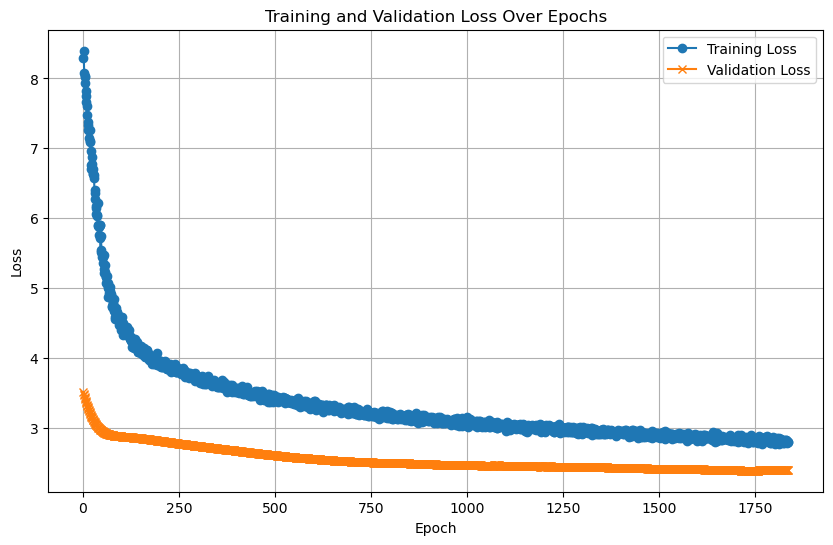

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 4.6322


Test Batch [20/211], Loss: 4.8499
Test Batch [30/211], Loss: 4.9069
Test Batch [40/211], Loss: 5.0765
Test Batch [50/211], Loss: 4.4300
Test Batch [60/211], Loss: 4.6317


Test Batch [70/211], Loss: 5.0305
Test Batch [80/211], Loss: 4.5421
Test Batch [90/211], Loss: 4.7800
Test Batch [100/211], Loss: 4.4757
Test Batch [110/211], Loss: 4.8065
Test Batch [120/211], Loss: 4.9120
Test Batch [130/211], Loss: 4.4946
Test Batch [140/211], Loss: 4.4705


Test Batch [150/211], Loss: 4.4112
Test Batch [160/211], Loss: 4.5794
Test Batch [170/211], Loss: 4.6515
Test Batch [180/211], Loss: 4.6956
Test Batch [190/211], Loss: 4.6629
Test Batch [200/211], Loss: 4.6508
Test Batch [210/211], Loss: 4.5954

Test Loss: 4.7100


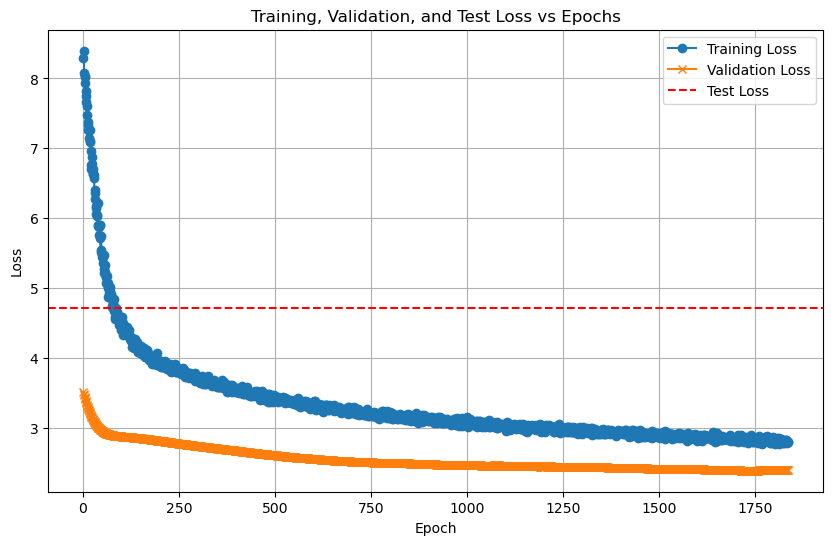

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.


  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.


  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       0.71      1.00      0.83         5
           3       1.00      1.00      1.00         5
           4       1.00      0.60      0.75         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.33      0.20      0.25         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8125  |  Val Loss: 2.7956
Validation loss improved from inf to 2.7956.
[Epoch 2/1000] Train Loss: 2.7905  |  Val Loss: 2.7766
Validation loss improved from 2.7956 to 2.7766.
[Epoch 3/1000] Train Loss: 2.7708  |  Val Loss: 2.7587
Validation loss improved from 2.7766 to 2.7587.
[Epoch 4/1000] Train Loss: 2.7516  |  Val Loss: 2.7414
Validation loss improved from 2.7587 to 2.7414.
[Epoch 5/1000] Train Loss: 2.7333  |  Val Loss: 2.7239
Validation loss improved from 2.7414 to 2.7239.
[Epoch 6/1000] Train Loss: 2.7150  |  Val Loss: 2.7072
Validation loss improved from 2.7239 to 2.7072.
[Epoch 7/1000] Train Loss: 2.6977  |  Val Loss: 2.6910
Validation loss improved from 2.7072 to 2.6910.
[Epoch 8/1000] Train Loss: 2.6801  |  Val Loss: 2.6761
Validation loss improved from 2.6910 to 2.6761.
[Epoch 9/1000] Train Loss: 2.6635  |  Val Loss: 2.6617
Validation loss improved from 2.6761 to 2.6617.
[Epoch 10/1000] Train Loss: 2.6478  |  Val Loss: 2.6476
Validation loss impr

[Epoch 25/1000] Train Loss: 2.3985  |  Val Loss: 2.4190
Validation loss improved from 2.4335 to 2.4190.
[Epoch 26/1000] Train Loss: 2.3826  |  Val Loss: 2.4041
Validation loss improved from 2.4190 to 2.4041.
[Epoch 27/1000] Train Loss: 2.3661  |  Val Loss: 2.3893
Validation loss improved from 2.4041 to 2.3893.
[Epoch 28/1000] Train Loss: 2.3499  |  Val Loss: 2.3745
Validation loss improved from 2.3893 to 2.3745.
[Epoch 29/1000] Train Loss: 2.3330  |  Val Loss: 2.3595
Validation loss improved from 2.3745 to 2.3595.
[Epoch 30/1000] Train Loss: 2.3162  |  Val Loss: 2.3443
Validation loss improved from 2.3595 to 2.3443.
[Epoch 31/1000] Train Loss: 2.2992  |  Val Loss: 2.3290
Validation loss improved from 2.3443 to 2.3290.


[Epoch 32/1000] Train Loss: 2.2828  |  Val Loss: 2.3134
Validation loss improved from 2.3290 to 2.3134.
[Epoch 33/1000] Train Loss: 2.2656  |  Val Loss: 2.2982
Validation loss improved from 2.3134 to 2.2982.
[Epoch 34/1000] Train Loss: 2.2490  |  Val Loss: 2.2832
Validation loss improved from 2.2982 to 2.2832.
[Epoch 35/1000] Train Loss: 2.2322  |  Val Loss: 2.2682
Validation loss improved from 2.2832 to 2.2682.
[Epoch 36/1000] Train Loss: 2.2157  |  Val Loss: 2.2532
Validation loss improved from 2.2682 to 2.2532.
[Epoch 37/1000] Train Loss: 2.1990  |  Val Loss: 2.2382
Validation loss improved from 2.2532 to 2.2382.
[Epoch 38/1000] Train Loss: 2.1824  |  Val Loss: 2.2235
Validation loss improved from 2.2382 to 2.2235.
[Epoch 39/1000] Train Loss: 2.1656  |  Val Loss: 2.2089
Validation loss improved from 2.2235 to 2.2089.
[Epoch 40/1000] Train Loss: 2.1494  |  Val Loss: 2.1942
Validation loss improved from 2.2089 to 2.1942.
[Epoch 41/1000] Train Loss: 2.1321  |  Val Loss: 2.1793
Validati

[Epoch 57/1000] Train Loss: 1.8639  |  Val Loss: 1.9416
Validation loss improved from 1.9565 to 1.9416.
[Epoch 58/1000] Train Loss: 1.8473  |  Val Loss: 1.9262
Validation loss improved from 1.9416 to 1.9262.
[Epoch 59/1000] Train Loss: 1.8303  |  Val Loss: 1.9107
Validation loss improved from 1.9262 to 1.9107.
[Epoch 60/1000] Train Loss: 1.8128  |  Val Loss: 1.8952
Validation loss improved from 1.9107 to 1.8952.
[Epoch 61/1000] Train Loss: 1.7951  |  Val Loss: 1.8796
Validation loss improved from 1.8952 to 1.8796.
[Epoch 62/1000] Train Loss: 1.7783  |  Val Loss: 1.8641
Validation loss improved from 1.8796 to 1.8641.


[Epoch 63/1000] Train Loss: 1.7611  |  Val Loss: 1.8483
Validation loss improved from 1.8641 to 1.8483.
[Epoch 64/1000] Train Loss: 1.7435  |  Val Loss: 1.8325
Validation loss improved from 1.8483 to 1.8325.
[Epoch 65/1000] Train Loss: 1.7267  |  Val Loss: 1.8167
Validation loss improved from 1.8325 to 1.8167.
[Epoch 66/1000] Train Loss: 1.7095  |  Val Loss: 1.8016
Validation loss improved from 1.8167 to 1.8016.
[Epoch 67/1000] Train Loss: 1.6930  |  Val Loss: 1.7861
Validation loss improved from 1.8016 to 1.7861.
[Epoch 68/1000] Train Loss: 1.6761  |  Val Loss: 1.7708
Validation loss improved from 1.7861 to 1.7708.
[Epoch 69/1000] Train Loss: 1.6596  |  Val Loss: 1.7558
Validation loss improved from 1.7708 to 1.7558.
[Epoch 70/1000] Train Loss: 1.6436  |  Val Loss: 1.7411
Validation loss improved from 1.7558 to 1.7411.
[Epoch 71/1000] Train Loss: 1.6270  |  Val Loss: 1.7265
Validation loss improved from 1.7411 to 1.7265.
[Epoch 72/1000] Train Loss: 1.6113  |  Val Loss: 1.7117
Validati

[Epoch 88/1000] Train Loss: 1.3739  |  Val Loss: 1.5016
Validation loss improved from 1.5145 to 1.5016.
[Epoch 89/1000] Train Loss: 1.3601  |  Val Loss: 1.4895
Validation loss improved from 1.5016 to 1.4895.
[Epoch 90/1000] Train Loss: 1.3463  |  Val Loss: 1.4767
Validation loss improved from 1.4895 to 1.4767.
[Epoch 91/1000] Train Loss: 1.3329  |  Val Loss: 1.4642
Validation loss improved from 1.4767 to 1.4642.
[Epoch 92/1000] Train Loss: 1.3198  |  Val Loss: 1.4522
Validation loss improved from 1.4642 to 1.4522.
[Epoch 93/1000] Train Loss: 1.3065  |  Val Loss: 1.4412
Validation loss improved from 1.4522 to 1.4412.


[Epoch 94/1000] Train Loss: 1.2933  |  Val Loss: 1.4302
Validation loss improved from 1.4412 to 1.4302.
[Epoch 95/1000] Train Loss: 1.2806  |  Val Loss: 1.4195
Validation loss improved from 1.4302 to 1.4195.
[Epoch 96/1000] Train Loss: 1.2677  |  Val Loss: 1.4083
Validation loss improved from 1.4195 to 1.4083.
[Epoch 97/1000] Train Loss: 1.2551  |  Val Loss: 1.3966
Validation loss improved from 1.4083 to 1.3966.
[Epoch 98/1000] Train Loss: 1.2422  |  Val Loss: 1.3857
Validation loss improved from 1.3966 to 1.3857.
[Epoch 99/1000] Train Loss: 1.2299  |  Val Loss: 1.3746
Validation loss improved from 1.3857 to 1.3746.
[Epoch 100/1000] Train Loss: 1.2173  |  Val Loss: 1.3640
Validation loss improved from 1.3746 to 1.3640.
[Epoch 101/1000] Train Loss: 1.2050  |  Val Loss: 1.3530
Validation loss improved from 1.3640 to 1.3530.
[Epoch 102/1000] Train Loss: 1.1929  |  Val Loss: 1.3426
Validation loss improved from 1.3530 to 1.3426.
[Epoch 103/1000] Train Loss: 1.1807  |  Val Loss: 1.3320
Vali

[Epoch 118/1000] Train Loss: 1.0112  |  Val Loss: 1.1852
Validation loss improved from 1.1950 to 1.1852.
[Epoch 119/1000] Train Loss: 1.0006  |  Val Loss: 1.1753
Validation loss improved from 1.1852 to 1.1753.
[Epoch 120/1000] Train Loss: 0.9900  |  Val Loss: 1.1655
Validation loss improved from 1.1753 to 1.1655.
[Epoch 121/1000] Train Loss: 0.9794  |  Val Loss: 1.1561
Validation loss improved from 1.1655 to 1.1561.
[Epoch 122/1000] Train Loss: 0.9688  |  Val Loss: 1.1471
Validation loss improved from 1.1561 to 1.1471.
[Epoch 123/1000] Train Loss: 0.9584  |  Val Loss: 1.1379
Validation loss improved from 1.1471 to 1.1379.
[Epoch 124/1000] Train Loss: 0.9479  |  Val Loss: 1.1293
Validation loss improved from 1.1379 to 1.1293.


[Epoch 125/1000] Train Loss: 0.9379  |  Val Loss: 1.1203
Validation loss improved from 1.1293 to 1.1203.
[Epoch 126/1000] Train Loss: 0.9277  |  Val Loss: 1.1119
Validation loss improved from 1.1203 to 1.1119.
[Epoch 127/1000] Train Loss: 0.9173  |  Val Loss: 1.1032
Validation loss improved from 1.1119 to 1.1032.
[Epoch 128/1000] Train Loss: 0.9075  |  Val Loss: 1.0944
Validation loss improved from 1.1032 to 1.0944.
[Epoch 129/1000] Train Loss: 0.8977  |  Val Loss: 1.0860
Validation loss improved from 1.0944 to 1.0860.
[Epoch 130/1000] Train Loss: 0.8880  |  Val Loss: 1.0782
Validation loss improved from 1.0860 to 1.0782.
[Epoch 131/1000] Train Loss: 0.8779  |  Val Loss: 1.0699
Validation loss improved from 1.0782 to 1.0699.
[Epoch 132/1000] Train Loss: 0.8685  |  Val Loss: 1.0615
Validation loss improved from 1.0699 to 1.0615.
[Epoch 133/1000] Train Loss: 0.8585  |  Val Loss: 1.0543
Validation loss improved from 1.0615 to 1.0543.
[Epoch 134/1000] Train Loss: 0.8492  |  Val Loss: 1.046

[Epoch 148/1000] Train Loss: 0.7235  |  Val Loss: 0.9405
Validation loss improved from 0.9476 to 0.9405.
[Epoch 149/1000] Train Loss: 0.7155  |  Val Loss: 0.9331
Validation loss improved from 0.9405 to 0.9331.
[Epoch 150/1000] Train Loss: 0.7068  |  Val Loss: 0.9265
Validation loss improved from 0.9331 to 0.9265.
[Epoch 151/1000] Train Loss: 0.6987  |  Val Loss: 0.9204
Validation loss improved from 0.9265 to 0.9204.
[Epoch 152/1000] Train Loss: 0.6904  |  Val Loss: 0.9144
Validation loss improved from 0.9204 to 0.9144.
[Epoch 153/1000] Train Loss: 0.6819  |  Val Loss: 0.9083
Validation loss improved from 0.9144 to 0.9083.
[Epoch 154/1000] Train Loss: 0.6743  |  Val Loss: 0.9022
Validation loss improved from 0.9083 to 0.9022.
[Epoch 155/1000] Train Loss: 0.6661  |  Val Loss: 0.8961
Validation loss improved from 0.9022 to 0.8961.
[Epoch 156/1000] Train Loss: 0.6583  |  Val Loss: 0.8899
Validation loss improved from 0.8961 to 0.8899.


[Epoch 157/1000] Train Loss: 0.6506  |  Val Loss: 0.8839
Validation loss improved from 0.8899 to 0.8839.
[Epoch 158/1000] Train Loss: 0.6427  |  Val Loss: 0.8791
Validation loss improved from 0.8839 to 0.8791.
[Epoch 159/1000] Train Loss: 0.6351  |  Val Loss: 0.8737
Validation loss improved from 0.8791 to 0.8737.
[Epoch 160/1000] Train Loss: 0.6276  |  Val Loss: 0.8684
Validation loss improved from 0.8737 to 0.8684.
[Epoch 161/1000] Train Loss: 0.6202  |  Val Loss: 0.8623
Validation loss improved from 0.8684 to 0.8623.
[Epoch 162/1000] Train Loss: 0.6126  |  Val Loss: 0.8563
Validation loss improved from 0.8623 to 0.8563.
[Epoch 163/1000] Train Loss: 0.6057  |  Val Loss: 0.8504
Validation loss improved from 0.8563 to 0.8504.
[Epoch 164/1000] Train Loss: 0.5986  |  Val Loss: 0.8448
Validation loss improved from 0.8504 to 0.8448.
[Epoch 165/1000] Train Loss: 0.5912  |  Val Loss: 0.8393
Validation loss improved from 0.8448 to 0.8393.
[Epoch 166/1000] Train Loss: 0.5843  |  Val Loss: 0.833

[Epoch 177/1000] Train Loss: 0.5116  |  Val Loss: 0.7755
Validation loss improved from 0.7810 to 0.7755.
[Epoch 178/1000] Train Loss: 0.5059  |  Val Loss: 0.7699
Validation loss improved from 0.7755 to 0.7699.
[Epoch 179/1000] Train Loss: 0.4999  |  Val Loss: 0.7659
Validation loss improved from 0.7699 to 0.7659.
[Epoch 180/1000] Train Loss: 0.4940  |  Val Loss: 0.7613
Validation loss improved from 0.7659 to 0.7613.
[Epoch 181/1000] Train Loss: 0.4882  |  Val Loss: 0.7574
Validation loss improved from 0.7613 to 0.7574.
[Epoch 182/1000] Train Loss: 0.4823  |  Val Loss: 0.7536
Validation loss improved from 0.7574 to 0.7536.
[Epoch 183/1000] Train Loss: 0.4767  |  Val Loss: 0.7492
Validation loss improved from 0.7536 to 0.7492.
[Epoch 184/1000] Train Loss: 0.4715  |  Val Loss: 0.7451
Validation loss improved from 0.7492 to 0.7451.
[Epoch 185/1000] Train Loss: 0.4658  |  Val Loss: 0.7420
Validation loss improved from 0.7451 to 0.7420.


[Epoch 186/1000] Train Loss: 0.4605  |  Val Loss: 0.7381
Validation loss improved from 0.7420 to 0.7381.
[Epoch 187/1000] Train Loss: 0.4552  |  Val Loss: 0.7356
Validation loss improved from 0.7381 to 0.7356.
[Epoch 188/1000] Train Loss: 0.4497  |  Val Loss: 0.7324
Validation loss improved from 0.7356 to 0.7324.
[Epoch 189/1000] Train Loss: 0.4447  |  Val Loss: 0.7297
Validation loss improved from 0.7324 to 0.7297.
[Epoch 190/1000] Train Loss: 0.4399  |  Val Loss: 0.7273
Validation loss improved from 0.7297 to 0.7273.
[Epoch 191/1000] Train Loss: 0.4348  |  Val Loss: 0.7243
Validation loss improved from 0.7273 to 0.7243.
[Epoch 192/1000] Train Loss: 0.4299  |  Val Loss: 0.7208
Validation loss improved from 0.7243 to 0.7208.
[Epoch 193/1000] Train Loss: 0.4248  |  Val Loss: 0.7177
Validation loss improved from 0.7208 to 0.7177.
[Epoch 194/1000] Train Loss: 0.4205  |  Val Loss: 0.7148
Validation loss improved from 0.7177 to 0.7148.
[Epoch 195/1000] Train Loss: 0.4157  |  Val Loss: 0.710

[Epoch 206/1000] Train Loss: 0.3685  |  Val Loss: 0.6748
Validation loss improved from 0.6781 to 0.6748.
[Epoch 207/1000] Train Loss: 0.3648  |  Val Loss: 0.6715
Validation loss improved from 0.6748 to 0.6715.
[Epoch 208/1000] Train Loss: 0.3609  |  Val Loss: 0.6692
Validation loss improved from 0.6715 to 0.6692.
[Epoch 209/1000] Train Loss: 0.3575  |  Val Loss: 0.6671
Validation loss improved from 0.6692 to 0.6671.
[Epoch 210/1000] Train Loss: 0.3535  |  Val Loss: 0.6636
Validation loss improved from 0.6671 to 0.6636.
[Epoch 211/1000] Train Loss: 0.3499  |  Val Loss: 0.6615
Validation loss improved from 0.6636 to 0.6615.
[Epoch 212/1000] Train Loss: 0.3465  |  Val Loss: 0.6592
Validation loss improved from 0.6615 to 0.6592.
[Epoch 213/1000] Train Loss: 0.3427  |  Val Loss: 0.6576
Validation loss improved from 0.6592 to 0.6576.
[Epoch 214/1000] Train Loss: 0.3391  |  Val Loss: 0.6571
Validation loss improved from 0.6576 to 0.6571.
[Epoch 215/1000] Train Loss: 0.3354  |  Val Loss: 0.655

[Epoch 217/1000] Train Loss: 0.3287  |  Val Loss: 0.6537
Validation loss improved from 0.6550 to 0.6537.
[Epoch 218/1000] Train Loss: 0.3259  |  Val Loss: 0.6518
Validation loss improved from 0.6537 to 0.6518.
[Epoch 219/1000] Train Loss: 0.3223  |  Val Loss: 0.6472
Validation loss improved from 0.6518 to 0.6472.
[Epoch 220/1000] Train Loss: 0.3188  |  Val Loss: 0.6440
Validation loss improved from 0.6472 to 0.6440.
[Epoch 221/1000] Train Loss: 0.3159  |  Val Loss: 0.6407
Validation loss improved from 0.6440 to 0.6407.
[Epoch 222/1000] Train Loss: 0.3127  |  Val Loss: 0.6388
Validation loss improved from 0.6407 to 0.6388.
[Epoch 223/1000] Train Loss: 0.3096  |  Val Loss: 0.6379
Validation loss improved from 0.6388 to 0.6379.
[Epoch 224/1000] Train Loss: 0.3069  |  Val Loss: 0.6365
Validation loss improved from 0.6379 to 0.6365.
[Epoch 225/1000] Train Loss: 0.3034  |  Val Loss: 0.6338
Validation loss improved from 0.6365 to 0.6338.
[Epoch 226/1000] Train Loss: 0.3005  |  Val Loss: 0.631

[Epoch 238/1000] Train Loss: 0.2679  |  Val Loss: 0.6136
Validation loss improved from 0.6142 to 0.6136.
[Epoch 239/1000] Train Loss: 0.2652  |  Val Loss: 0.6120
Validation loss improved from 0.6136 to 0.6120.
[Epoch 240/1000] Train Loss: 0.2628  |  Val Loss: 0.6105
Validation loss improved from 0.6120 to 0.6105.
[Epoch 241/1000] Train Loss: 0.2602  |  Val Loss: 0.6094
Validation loss improved from 0.6105 to 0.6094.
[Epoch 242/1000] Train Loss: 0.2579  |  Val Loss: 0.6075
Validation loss improved from 0.6094 to 0.6075.
[Epoch 243/1000] Train Loss: 0.2555  |  Val Loss: 0.6069
Validation loss improved from 0.6075 to 0.6069.
[Epoch 244/1000] Train Loss: 0.2530  |  Val Loss: 0.6061
Validation loss improved from 0.6069 to 0.6061.
[Epoch 245/1000] Train Loss: 0.2508  |  Val Loss: 0.6058
Validation loss improved from 0.6061 to 0.6058.
[Epoch 246/1000] Train Loss: 0.2487  |  Val Loss: 0.6049
Validation loss improved from 0.6058 to 0.6049.
[Epoch 247/1000] Train Loss: 0.2462  |  Val Loss: 0.601

[Epoch 249/1000] Train Loss: 0.2416  |  Val Loss: 0.5976
Validation loss improved from 0.5989 to 0.5976.
[Epoch 250/1000] Train Loss: 0.2395  |  Val Loss: 0.5976
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 0.2373  |  Val Loss: 0.5972
Validation loss improved from 0.5976 to 0.5972.
[Epoch 252/1000] Train Loss: 0.2351  |  Val Loss: 0.5951
Validation loss improved from 0.5972 to 0.5951.
[Epoch 253/1000] Train Loss: 0.2330  |  Val Loss: 0.5939
Validation loss improved from 0.5951 to 0.5939.
[Epoch 254/1000] Train Loss: 0.2311  |  Val Loss: 0.5913
Validation loss improved from 0.5939 to 0.5913.
[Epoch 255/1000] Train Loss: 0.2289  |  Val Loss: 0.5897
Validation loss improved from 0.5913 to 0.5897.
[Epoch 256/1000] Train Loss: 0.2269  |  Val Loss: 0.5886
Validation loss improved from 0.5897 to 0.5886.
[Epoch 257/1000] Train Loss: 0.2253  |  Val Loss: 0.5888
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 258/1000] Train Loss: 0.2232  |  Val

[Epoch 268/1000] Train Loss: 0.2049  |  Val Loss: 0.5852
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 269/1000] Train Loss: 0.2034  |  Val Loss: 0.5847
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 270/1000] Train Loss: 0.2018  |  Val Loss: 0.5836
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 271/1000] Train Loss: 0.2002  |  Val Loss: 0.5832
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 272/1000] Train Loss: 0.1986  |  Val Loss: 0.5826
Validation loss improved from 0.5828 to 0.5826.
[Epoch 273/1000] Train Loss: 0.1969  |  Val Loss: 0.5805
Validation loss improved from 0.5826 to 0.5805.
[Epoch 274/1000] Train Loss: 0.1951  |  Val Loss: 0.5766
Validation loss improved from 0.5805 to 0.5766.
[Epoch 275/1000] Train Loss: 0.1935  |  Val Loss: 0.5745
Validation loss improved from 0.5766 to 0.5745.
[Epoch 276/1000] Train Loss: 0.1924  |  Val Loss: 0.5716
Validation loss improved from 0.5745 to 0.5716.
[Epoch 277/1000] Train Loss: 0.

[Epoch 279/1000] Train Loss: 0.1880  |  Val Loss: 0.5703
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 280/1000] Train Loss: 0.1865  |  Val Loss: 0.5707
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 281/1000] Train Loss: 0.1848  |  Val Loss: 0.5712
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 282/1000] Train Loss: 0.1835  |  Val Loss: 0.5708
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 283/1000] Train Loss: 0.1822  |  Val Loss: 0.5708
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 284/1000] Train Loss: 0.1805  |  Val Loss: 0.5704
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 285/1000] Train Loss: 0.1793  |  Val Loss: 0.5711
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 286/1000] Train Loss: 0.1777  |  Val Loss: 0.5709
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 287/1000] Train Loss: 0.1767  |  Val Loss: 0.5703
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 298/1000] Train Loss: 0.1629  |  Val Loss: 0.5657
Validation loss improved from 0.5669 to 0.5657.
[Epoch 299/1000] Train Loss: 0.1617  |  Val Loss: 0.5654
Validation loss improved from 0.5657 to 0.5654.
[Epoch 300/1000] Train Loss: 0.1609  |  Val Loss: 0.5647
Validation loss improved from 0.5654 to 0.5647.
[Epoch 301/1000] Train Loss: 0.1597  |  Val Loss: 0.5655
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 0.1586  |  Val Loss: 0.5659
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 0.1574  |  Val Loss: 0.5656
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 0.1565  |  Val Loss: 0.5667
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 305/1000] Train Loss: 0.1551  |  Val Loss: 0.5659
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 306/1000] Train Loss: 0.1541  |  Val Loss: 0.5653
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 307/1000] Tr

[Epoch 308/1000] Train Loss: 0.1521  |  Val Loss: 0.5629
Validation loss improved from 0.5646 to 0.5629.
[Epoch 309/1000] Train Loss: 0.1512  |  Val Loss: 0.5614
Validation loss improved from 0.5629 to 0.5614.
[Epoch 310/1000] Train Loss: 0.1503  |  Val Loss: 0.5608
Validation loss improved from 0.5614 to 0.5608.
[Epoch 311/1000] Train Loss: 0.1492  |  Val Loss: 0.5619
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 312/1000] Train Loss: 0.1480  |  Val Loss: 0.5641
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 313/1000] Train Loss: 0.1474  |  Val Loss: 0.5669
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 314/1000] Train Loss: 0.1461  |  Val Loss: 0.5669
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 315/1000] Train Loss: 0.1455  |  Val Loss: 0.5669
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 316/1000] Train Loss: 0.1446  |  Val Loss: 0.5634
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 317/1000] Tr

[Epoch 325/1000] Train Loss: 0.1368  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 326/1000] Train Loss: 0.1361  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 327/1000] Train Loss: 0.1351  |  Val Loss: 0.5675
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 328/1000] Train Loss: 0.1338  |  Val Loss: 0.5658
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 329/1000] Train Loss: 0.1338  |  Val Loss: 0.5628
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 330/1000] Train Loss: 0.1331  |  Val Loss: 0.5620
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 331/1000] Train Loss: 0.1324  |  Val Loss: 0.5637
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 332/1000] Train Loss: 0.1311  |  Val Loss: 0.5642
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 333/1000] Train Loss: 0.1305  |  Val Loss: 0.5645
!! Validation loss did NOT improve !! Patience:

[Epoch 339/1000] Train Loss: 0.1258  |  Val Loss: 0.5673
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 340/1000] Train Loss: 0.1252  |  Val Loss: 0.5690
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 341/1000] Train Loss: 0.1246  |  Val Loss: 0.5698
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 342/1000] Train Loss: 0.1238  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 343/1000] Train Loss: 0.1233  |  Val Loss: 0.5727
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 344/1000] Train Loss: 0.1227  |  Val Loss: 0.5743
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 345/1000] Train Loss: 0.1221  |  Val Loss: 0.5752
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 346/1000] Train Loss: 0.1215  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 347/1000] Train Loss: 0.1207  |  Val Loss: 0.5701
!! Validation loss did NOT improve !! Patience:

[Epoch 355/1000] Train Loss: 0.1156  |  Val Loss: 0.5711
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 356/1000] Train Loss: 0.1148  |  Val Loss: 0.5722
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 357/1000] Train Loss: 0.1142  |  Val Loss: 0.5734
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 358/1000] Train Loss: 0.1137  |  Val Loss: 0.5742
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 359/1000] Train Loss: 0.1131  |  Val Loss: 0.5745
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 360/1000] Train Loss: 0.1124  |  Val Loss: 0.5734
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 361/1000] Train Loss: 0.1119  |  Val Loss: 0.5740
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 362/1000] Train Loss: 0.1112  |  Val Loss: 0.5730
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 363/1000] Train Loss: 0.1106  |  Val Loss: 0.5738
!! Validation loss did NOT improve !! Patience:

[Epoch 368/1000] Train Loss: 0.1079  |  Val Loss: 0.5742
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 369/1000] Train Loss: 0.1073  |  Val Loss: 0.5734
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 370/1000] Train Loss: 0.1074  |  Val Loss: 0.5727
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 371/1000] Train Loss: 0.1063  |  Val Loss: 0.5747
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 372/1000] Train Loss: 0.1062  |  Val Loss: 0.5772
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 373/1000] Train Loss: 0.1051  |  Val Loss: 0.5761
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 374/1000] Train Loss: 0.1047  |  Val Loss: 0.5749
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 375/1000] Train Loss: 0.1043  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 376/1000] Train Loss: 0.1039  |  Val Loss: 0.5791
!! Validation loss did NOT improve !! Patience:

[Epoch 386/1000] Train Loss: 0.0987  |  Val Loss: 0.5848
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 387/1000] Train Loss: 0.0984  |  Val Loss: 0.5857
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 388/1000] Train Loss: 0.0979  |  Val Loss: 0.5855
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 389/1000] Train Loss: 0.0974  |  Val Loss: 0.5855
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 390/1000] Train Loss: 0.0969  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 391/1000] Train Loss: 0.0967  |  Val Loss: 0.5832
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 392/1000] Train Loss: 0.0963  |  Val Loss: 0.5841
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 393/1000] Train Loss: 0.0956  |  Val Loss: 0.5867
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 394/1000] Train Loss: 0.0957  |  Val Loss: 0.5904
!! Validation loss did NOT improve !! Patience:

[Epoch 398/1000] Train Loss: 0.0937  |  Val Loss: 0.5881
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 399/1000] Train Loss: 0.0935  |  Val Loss: 0.5855
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 400/1000] Train Loss: 0.0929  |  Val Loss: 0.5860
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 401/1000] Train Loss: 0.0925  |  Val Loss: 0.5859
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 402/1000] Train Loss: 0.0921  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 403/1000] Train Loss: 0.0918  |  Val Loss: 0.5838
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 404/1000] Train Loss: 0.0914  |  Val Loss: 0.5851
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 405/1000] Train Loss: 0.0909  |  Val Loss: 0.5864
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 406/1000] Train Loss: 0.0907  |  Val Loss: 0.5869
!! Validation loss did NOT improve !! Patience:

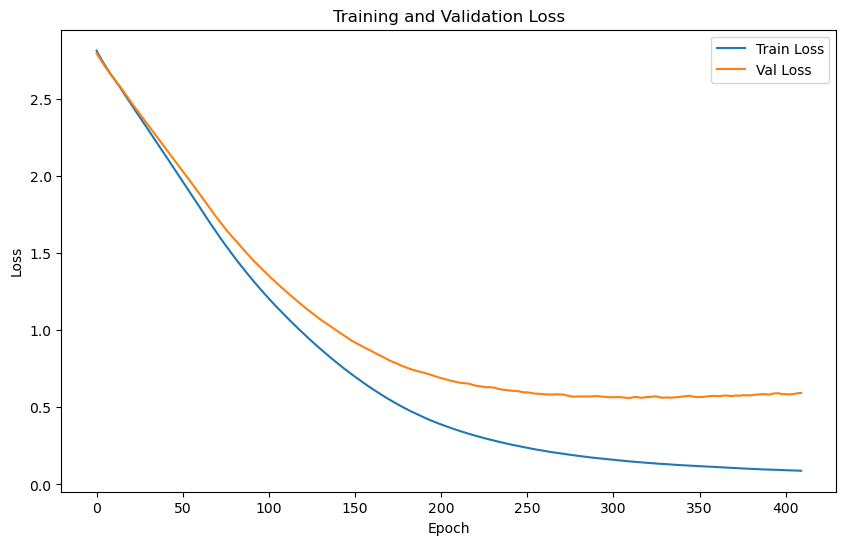

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8114 | Test Accuracy: 77.85%


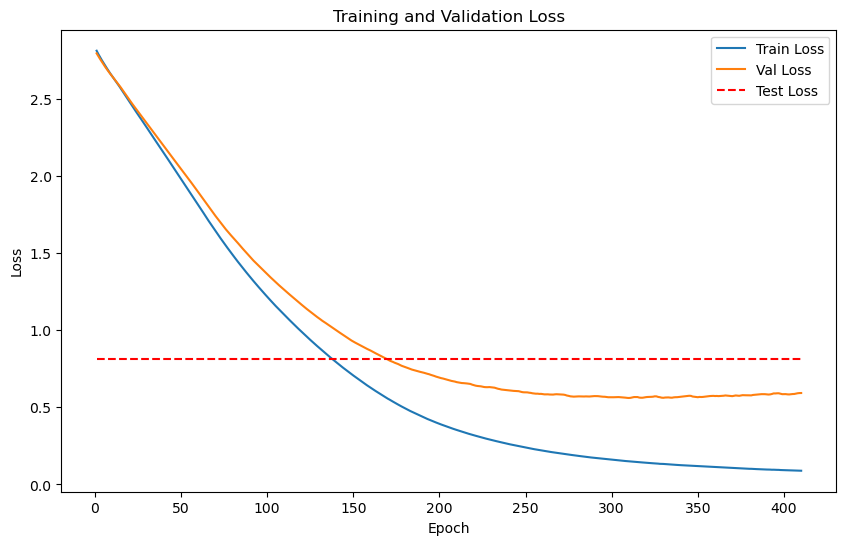

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3353
    Batch [2/2], Val Loss: 0.3683
Epoch [1/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.3518

Validation loss improved from inf to 0.3518. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.3691
Epoch [2/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.3520

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.3692
Epoch [3/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.3520

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.3686
Epoch [4/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3517

Validation loss improved from 0.3518 to 0.3517. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.3674
Epoch [5/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.3510

Validation loss improved from 0.3517 to 0.3510. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.3662
Epoch [6/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.3505

Validation loss improved from 0.3510 to 0.3505. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3352
    Batch [2/2], Val Loss: 0.3652
Epoch [7/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3502

Validation loss improved from 0.3505 to 0.3502. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.3640
Epoch [8/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.3494

Validation loss improved from 0.3502 to 0.3494. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.3627
Epoch [9/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3486

Validation loss improved from 0.3494 to 0.3486. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.3611
Epoch [10/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3474

Validation loss improved from 0.3486 to 0.3474. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3327
    Batch [2/2], Val Loss: 0.3592
Epoch [11/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3460

Validation loss improved from 0.3474 to 0.3460. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3314
    Batch [2/2], Val Loss: 0.3574
Epoch [12/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3444

Validation loss improved from 0.3460 to 0.3444. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3296
    Batch [2/2], Val Loss: 0.3560
Epoch [13/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3428

Validation loss improved from 0.3444 to 0.3428. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3275
    Batch [2/2], Val Loss: 0.3548
Epoch [14/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.3411

Validation loss improved from 0.3428 to 0.3411. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3255
    Batch [2/2], Val Loss: 0.3537
Epoch [15/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.3396

Validation loss improved from 0.3411 to 0.3396. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3233
    Batch [2/2], Val Loss: 0.3523
Epoch [16/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3378

Validation loss improved from 0.3396 to 0.3378. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.3507
Epoch [17/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.3360

Validation loss improved from 0.3378 to 0.3360. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3196
    Batch [2/2], Val Loss: 0.3492
Epoch [18/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3344

Validation loss improved from 0.3360 to 0.3344. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3180
    Batch [2/2], Val Loss: 0.3477
Epoch [19/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3328

Validation loss improved from 0.3344 to 0.3328. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.3461
Epoch [20/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.3313

Validation loss improved from 0.3328 to 0.3313. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3148
    Batch [2/2], Val Loss: 0.3447
Epoch [21/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.3298

Validation loss improved from 0.3313 to 0.3298. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3132
    Batch [2/2], Val Loss: 0.3432
Epoch [22/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3282

Validation loss improved from 0.3298 to 0.3282. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3116
    Batch [2/2], Val Loss: 0.3419
Epoch [23/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3267

Validation loss improved from 0.3282 to 0.3267. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3103
    Batch [2/2], Val Loss: 0.3407
Epoch [24/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.3255

Validation loss improved from 0.3267 to 0.3255. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.3396
Epoch [25/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3243

Validation loss improved from 0.3255 to 0.3243. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3080
    Batch [2/2], Val Loss: 0.3385
Epoch [26/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3233

Validation loss improved from 0.3243 to 0.3233. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3070
    Batch [2/2], Val Loss: 0.3374
Epoch [27/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.3222

Validation loss improved from 0.3233 to 0.3222. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3061
    Batch [2/2], Val Loss: 0.3364
Epoch [28/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.3213

Validation loss improved from 0.3222 to 0.3213. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.3355
Epoch [29/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3203

Validation loss improved from 0.3213 to 0.3203. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3044
    Batch [2/2], Val Loss: 0.3346
Epoch [30/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3195

Validation loss improved from 0.3203 to 0.3195. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3035
    Batch [2/2], Val Loss: 0.3339
Epoch [31/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3187

Validation loss improved from 0.3195 to 0.3187. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.3331
Epoch [32/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3179

Validation loss improved from 0.3187 to 0.3179. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.3324
Epoch [33/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3171

Validation loss improved from 0.3179 to 0.3171. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.3318
Epoch [34/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3163

Validation loss improved from 0.3171 to 0.3163. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3000
    Batch [2/2], Val Loss: 0.3311
Epoch [35/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3156

Validation loss improved from 0.3163 to 0.3156. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2992
    Batch [2/2], Val Loss: 0.3305
Epoch [36/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3149

Validation loss improved from 0.3156 to 0.3149. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2983
    Batch [2/2], Val Loss: 0.3299
Epoch [37/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.3141

Validation loss improved from 0.3149 to 0.3141. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2975
    Batch [2/2], Val Loss: 0.3293
Epoch [38/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3134

Validation loss improved from 0.3141 to 0.3134. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.3287
Epoch [39/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3127

Validation loss improved from 0.3134 to 0.3127. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.3282
Epoch [40/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3121

Validation loss improved from 0.3127 to 0.3121. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.3277
Epoch [41/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3115

Validation loss improved from 0.3121 to 0.3115. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2946
    Batch [2/2], Val Loss: 0.3273
Epoch [42/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3109

Validation loss improved from 0.3115 to 0.3109. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.3268
Epoch [43/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.3104

Validation loss improved from 0.3109 to 0.3104. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.3264
Epoch [44/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.3098

Validation loss improved from 0.3104 to 0.3098. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.3260
Epoch [45/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3093

Validation loss improved from 0.3098 to 0.3093. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2919
    Batch [2/2], Val Loss: 0.3256
Epoch [46/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.3087

Validation loss improved from 0.3093 to 0.3087. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2913
    Batch [2/2], Val Loss: 0.3252
Epoch [47/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3083

Validation loss improved from 0.3087 to 0.3083. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2907
    Batch [2/2], Val Loss: 0.3248
Epoch [48/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.3078

Validation loss improved from 0.3083 to 0.3078. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2901
    Batch [2/2], Val Loss: 0.3244
Epoch [49/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3073

Validation loss improved from 0.3078 to 0.3073. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2895
    Batch [2/2], Val Loss: 0.3241
Epoch [50/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3068

Validation loss improved from 0.3073 to 0.3068. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2889
    Batch [2/2], Val Loss: 0.3237
Epoch [51/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3063

Validation loss improved from 0.3068 to 0.3063. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.3233
Epoch [52/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3058

Validation loss improved from 0.3063 to 0.3058. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.3229
Epoch [53/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.3053

Validation loss improved from 0.3058 to 0.3053. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2870
    Batch [2/2], Val Loss: 0.3224
Epoch [54/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3047

Validation loss improved from 0.3053 to 0.3047. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2864
    Batch [2/2], Val Loss: 0.3220
Epoch [55/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3042

Validation loss improved from 0.3047 to 0.3042. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2858
    Batch [2/2], Val Loss: 0.3215
Epoch [56/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.3036

Validation loss improved from 0.3042 to 0.3036. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2852
    Batch [2/2], Val Loss: 0.3210
Epoch [57/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3031

Validation loss improved from 0.3036 to 0.3031. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.3205
Epoch [58/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.3025

Validation loss improved from 0.3031 to 0.3025. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2839
    Batch [2/2], Val Loss: 0.3200
Epoch [59/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3020

Validation loss improved from 0.3025 to 0.3020. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.3196
Epoch [60/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3015

Validation loss improved from 0.3020 to 0.3015. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.3191
Epoch [61/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3009

Validation loss improved from 0.3015 to 0.3009. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.3186
Epoch [62/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3004

Validation loss improved from 0.3009 to 0.3004. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2816
    Batch [2/2], Val Loss: 0.3182
Epoch [63/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2999

Validation loss improved from 0.3004 to 0.2999. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2811
    Batch [2/2], Val Loss: 0.3177
Epoch [64/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2994

Validation loss improved from 0.2999 to 0.2994. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2806
    Batch [2/2], Val Loss: 0.3172
Epoch [65/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2989

Validation loss improved from 0.2994 to 0.2989. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2801
    Batch [2/2], Val Loss: 0.3167
Epoch [66/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2984

Validation loss improved from 0.2989 to 0.2984. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.3162
Epoch [67/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2979

Validation loss improved from 0.2984 to 0.2979. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2792
    Batch [2/2], Val Loss: 0.3157
Epoch [68/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2975

Validation loss improved from 0.2979 to 0.2975. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2787
    Batch [2/2], Val Loss: 0.3153
Epoch [69/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2970

Validation loss improved from 0.2975 to 0.2970. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2782
    Batch [2/2], Val Loss: 0.3147
Epoch [70/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2965

Validation loss improved from 0.2970 to 0.2965. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2777
    Batch [2/2], Val Loss: 0.3141
Epoch [71/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2959

Validation loss improved from 0.2965 to 0.2959. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.3136
Epoch [72/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2955

Validation loss improved from 0.2959 to 0.2955. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2769
    Batch [2/2], Val Loss: 0.3131
Epoch [73/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2950

Validation loss improved from 0.2955 to 0.2950. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2764
    Batch [2/2], Val Loss: 0.3126
Epoch [74/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2945

Validation loss improved from 0.2950 to 0.2945. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2759
    Batch [2/2], Val Loss: 0.3121
Epoch [75/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2940

Validation loss improved from 0.2945 to 0.2940. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.3117
Epoch [76/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2935

Validation loss improved from 0.2940 to 0.2935. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.3113
Epoch [77/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2931

Validation loss improved from 0.2935 to 0.2931. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2745
    Batch [2/2], Val Loss: 0.3108
Epoch [78/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2927

Validation loss improved from 0.2931 to 0.2927. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2741
    Batch [2/2], Val Loss: 0.3104
Epoch [79/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2922

Validation loss improved from 0.2927 to 0.2922. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2736
    Batch [2/2], Val Loss: 0.3099
Epoch [80/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2918

Validation loss improved from 0.2922 to 0.2918. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.3095
Epoch [81/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2914

Validation loss improved from 0.2918 to 0.2914. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2728
    Batch [2/2], Val Loss: 0.3091
Epoch [82/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2910

Validation loss improved from 0.2914 to 0.2910. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.3087
Epoch [83/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2905

Validation loss improved from 0.2910 to 0.2905. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2720
    Batch [2/2], Val Loss: 0.3082
Epoch [84/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2901

Validation loss improved from 0.2905 to 0.2901. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2716
    Batch [2/2], Val Loss: 0.3078
Epoch [85/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2897

Validation loss improved from 0.2901 to 0.2897. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2712
    Batch [2/2], Val Loss: 0.3074
Epoch [86/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2893

Validation loss improved from 0.2897 to 0.2893. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.3070
Epoch [87/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2889

Validation loss improved from 0.2893 to 0.2889. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2703
    Batch [2/2], Val Loss: 0.3066
Epoch [88/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2885

Validation loss improved from 0.2889 to 0.2885. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2699
    Batch [2/2], Val Loss: 0.3063
Epoch [89/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2881

Validation loss improved from 0.2885 to 0.2881. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2695
    Batch [2/2], Val Loss: 0.3059
Epoch [90/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2877

Validation loss improved from 0.2881 to 0.2877. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2690
    Batch [2/2], Val Loss: 0.3055
Epoch [91/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2872

Validation loss improved from 0.2877 to 0.2872. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2685
    Batch [2/2], Val Loss: 0.3051
Epoch [92/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2868

Validation loss improved from 0.2872 to 0.2868. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2681
    Batch [2/2], Val Loss: 0.3047
Epoch [93/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2864

Validation loss improved from 0.2868 to 0.2864. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2676
    Batch [2/2], Val Loss: 0.3042
Epoch [94/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2859

Validation loss improved from 0.2864 to 0.2859. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2672
    Batch [2/2], Val Loss: 0.3037
Epoch [95/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2855

Validation loss improved from 0.2859 to 0.2855. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.3032
Epoch [96/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2850

Validation loss improved from 0.2855 to 0.2850. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.3026
Epoch [97/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2845

Validation loss improved from 0.2850 to 0.2845. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.3020
Epoch [98/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2840

Validation loss improved from 0.2845 to 0.2840. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2655
    Batch [2/2], Val Loss: 0.3015
Epoch [99/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2835

Validation loss improved from 0.2840 to 0.2835. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2650
    Batch [2/2], Val Loss: 0.3009
Epoch [100/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2830

Validation loss improved from 0.2835 to 0.2830. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2646
    Batch [2/2], Val Loss: 0.3003
Epoch [101/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2825

Validation loss improved from 0.2830 to 0.2825. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2642
    Batch [2/2], Val Loss: 0.2997
Epoch [102/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2819

Validation loss improved from 0.2825 to 0.2819. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.2991
Epoch [103/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2814

Validation loss improved from 0.2819 to 0.2814. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2634
    Batch [2/2], Val Loss: 0.2986
Epoch [104/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2810

Validation loss improved from 0.2814 to 0.2810. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2631
    Batch [2/2], Val Loss: 0.2980
Epoch [105/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2805

Validation loss improved from 0.2810 to 0.2805. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2627
    Batch [2/2], Val Loss: 0.2975
Epoch [106/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2801

Validation loss improved from 0.2805 to 0.2801. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2623
    Batch [2/2], Val Loss: 0.2969
Epoch [107/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2796

Validation loss improved from 0.2801 to 0.2796. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2619
    Batch [2/2], Val Loss: 0.2964
Epoch [108/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2792

Validation loss improved from 0.2796 to 0.2792. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.2959
Epoch [109/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2787

Validation loss improved from 0.2792 to 0.2787. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2613
    Batch [2/2], Val Loss: 0.2953
Epoch [110/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2783

Validation loss improved from 0.2787 to 0.2783. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2610
    Batch [2/2], Val Loss: 0.2948
Epoch [111/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2779

Validation loss improved from 0.2783 to 0.2779. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2607
    Batch [2/2], Val Loss: 0.2944
Epoch [112/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2776

Validation loss improved from 0.2779 to 0.2776. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.2939
Epoch [113/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2772

Validation loss improved from 0.2776 to 0.2772. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2934
Epoch [114/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2768

Validation loss improved from 0.2772 to 0.2768. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2597
    Batch [2/2], Val Loss: 0.2930
Epoch [115/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2764

Validation loss improved from 0.2768 to 0.2764. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2594
    Batch [2/2], Val Loss: 0.2925
Epoch [116/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2759

Validation loss improved from 0.2764 to 0.2759. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2590
    Batch [2/2], Val Loss: 0.2921
Epoch [117/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2756

Validation loss improved from 0.2759 to 0.2756. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2587
    Batch [2/2], Val Loss: 0.2916
Epoch [118/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2752

Validation loss improved from 0.2756 to 0.2752. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2583
    Batch [2/2], Val Loss: 0.2912
Epoch [119/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2747

Validation loss improved from 0.2752 to 0.2747. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2580
    Batch [2/2], Val Loss: 0.2908
Epoch [120/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2744

Validation loss improved from 0.2747 to 0.2744. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2576
    Batch [2/2], Val Loss: 0.2903
Epoch [121/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2740

Validation loss improved from 0.2744 to 0.2740. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2573
    Batch [2/2], Val Loss: 0.2899
Epoch [122/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2736

Validation loss improved from 0.2740 to 0.2736. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.2894
Epoch [123/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2732

Validation loss improved from 0.2736 to 0.2732. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2567
    Batch [2/2], Val Loss: 0.2889
Epoch [124/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2728

Validation loss improved from 0.2732 to 0.2728. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2563
    Batch [2/2], Val Loss: 0.2885
Epoch [125/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2724

Validation loss improved from 0.2728 to 0.2724. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.2880
Epoch [126/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2720

Validation loss improved from 0.2724 to 0.2720. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.2876
Epoch [127/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2716

Validation loss improved from 0.2720 to 0.2716. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2552
    Batch [2/2], Val Loss: 0.2872
Epoch [128/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2712

Validation loss improved from 0.2716 to 0.2712. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.2868
Epoch [129/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2709

Validation loss improved from 0.2712 to 0.2709. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2545
    Batch [2/2], Val Loss: 0.2865
Epoch [130/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2705

Validation loss improved from 0.2709 to 0.2705. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2542
    Batch [2/2], Val Loss: 0.2861
Epoch [131/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2702

Validation loss improved from 0.2705 to 0.2702. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.2858
Epoch [132/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2698

Validation loss improved from 0.2702 to 0.2698. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.2855
Epoch [133/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2695

Validation loss improved from 0.2698 to 0.2695. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.2852
Epoch [134/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2692

Validation loss improved from 0.2695 to 0.2692. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2528
    Batch [2/2], Val Loss: 0.2848
Epoch [135/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2688

Validation loss improved from 0.2692 to 0.2688. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.2843
Epoch [136/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2684

Validation loss improved from 0.2688 to 0.2684. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.2839
Epoch [137/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2680

Validation loss improved from 0.2684 to 0.2680. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.2834
Epoch [138/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2676

Validation loss improved from 0.2680 to 0.2676. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.2830
Epoch [139/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2672

Validation loss improved from 0.2676 to 0.2672. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2510
    Batch [2/2], Val Loss: 0.2827
Epoch [140/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2668

Validation loss improved from 0.2672 to 0.2668. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.2824
Epoch [141/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2665

Validation loss improved from 0.2668 to 0.2665. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2502
    Batch [2/2], Val Loss: 0.2822
Epoch [142/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2662

Validation loss improved from 0.2665 to 0.2662. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.2820
Epoch [143/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2660

Validation loss improved from 0.2662 to 0.2660. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.2818
Epoch [144/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2657

Validation loss improved from 0.2660 to 0.2657. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.2817
Epoch [145/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2655

Validation loss improved from 0.2657 to 0.2655. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2491
    Batch [2/2], Val Loss: 0.2815
Epoch [146/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2653

Validation loss improved from 0.2655 to 0.2653. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.2813
Epoch [147/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2651

Validation loss improved from 0.2653 to 0.2651. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.2812
Epoch [148/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2649

Validation loss improved from 0.2651 to 0.2649. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.2811
Epoch [149/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2647

Validation loss improved from 0.2649 to 0.2647. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.2809
Epoch [150/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2645

Validation loss improved from 0.2647 to 0.2645. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2477
    Batch [2/2], Val Loss: 0.2809
Epoch [151/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2643

Validation loss improved from 0.2645 to 0.2643. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.2807
Epoch [152/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2641

Validation loss improved from 0.2643 to 0.2641. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2470
    Batch [2/2], Val Loss: 0.2806
Epoch [153/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2638

Validation loss improved from 0.2641 to 0.2638. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2467
    Batch [2/2], Val Loss: 0.2806
Epoch [154/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2465
    Batch [2/2], Val Loss: 0.2806
Epoch [155/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2462
    Batch [2/2], Val Loss: 0.2805
Epoch [156/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2459
    Batch [2/2], Val Loss: 0.2804
Epoch [157/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2456
    Batch [2/2], Val Loss: 0.2803
Epoch [158/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2630

Validation loss improved from 0.2632 to 0.2630. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2454
    Batch [2/2], Val Loss: 0.2803
Epoch [159/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.2628

Validation loss improved from 0.2630 to 0.2628. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2452
    Batch [2/2], Val Loss: 0.2803
Epoch [160/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2450
    Batch [2/2], Val Loss: 0.2803
Epoch [161/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.2803
Epoch [162/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2446
    Batch [2/2], Val Loss: 0.2803
Epoch [163/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2624

Validation loss improved from 0.2626 to 0.2624. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2443
    Batch [2/2], Val Loss: 0.2803
Epoch [164/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2440
    Batch [2/2], Val Loss: 0.2803
Epoch [165/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2622

Validation loss improved from 0.2623 to 0.2622. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2437
    Batch [2/2], Val Loss: 0.2803
Epoch [166/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2620

Validation loss improved from 0.2622 to 0.2620. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2435
    Batch [2/2], Val Loss: 0.2801
Epoch [167/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.2618

Validation loss improved from 0.2620 to 0.2618. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2432
    Batch [2/2], Val Loss: 0.2800
Epoch [168/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.2616

Validation loss improved from 0.2618 to 0.2616. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2429
    Batch [2/2], Val Loss: 0.2799
Epoch [169/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2614

Validation loss improved from 0.2616 to 0.2614. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2427
    Batch [2/2], Val Loss: 0.2798
Epoch [170/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2612

Validation loss improved from 0.2614 to 0.2612. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2425
    Batch [2/2], Val Loss: 0.2796
Epoch [171/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2610

Validation loss improved from 0.2612 to 0.2610. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2422
    Batch [2/2], Val Loss: 0.2794
Epoch [172/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2608

Validation loss improved from 0.2610 to 0.2608. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2420
    Batch [2/2], Val Loss: 0.2793
Epoch [173/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2418
    Batch [2/2], Val Loss: 0.2792
Epoch [174/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2605

Validation loss improved from 0.2607 to 0.2605. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2415
    Batch [2/2], Val Loss: 0.2792
Epoch [175/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2603

Validation loss improved from 0.2605 to 0.2603. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2412
    Batch [2/2], Val Loss: 0.2791
Epoch [176/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2409
    Batch [2/2], Val Loss: 0.2792
Epoch [177/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2407
    Batch [2/2], Val Loss: 0.2792
Epoch [178/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2599

Validation loss improved from 0.2601 to 0.2599. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2404
    Batch [2/2], Val Loss: 0.2792
Epoch [179/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2402
    Batch [2/2], Val Loss: 0.2791
Epoch [180/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2596

Validation loss improved from 0.2598 to 0.2596. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2399
    Batch [2/2], Val Loss: 0.2790
Epoch [181/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2396
    Batch [2/2], Val Loss: 0.2790
Epoch [182/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2593

Validation loss improved from 0.2595 to 0.2593. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2394
    Batch [2/2], Val Loss: 0.2789
Epoch [183/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2591

Validation loss improved from 0.2593 to 0.2591. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2391
    Batch [2/2], Val Loss: 0.2790
Epoch [184/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2388
    Batch [2/2], Val Loss: 0.2790
Epoch [185/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2385
    Batch [2/2], Val Loss: 0.2791
Epoch [186/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2383
    Batch [2/2], Val Loss: 0.2792
Epoch [187/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2380
    Batch [2/2], Val Loss: 0.2792
Epoch [188/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.2793
Epoch [189/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2375
    Batch [2/2], Val Loss: 0.2792
Epoch [190/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2583

Validation loss improved from 0.2585 to 0.2583. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2373
    Batch [2/2], Val Loss: 0.2791
Epoch [191/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.2791
Epoch [192/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.2792
Epoch [193/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2367
    Batch [2/2], Val Loss: 0.2793
Epoch [194/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2365
    Batch [2/2], Val Loss: 0.2793
Epoch [195/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2363
    Batch [2/2], Val Loss: 0.2794
Epoch [196/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2360
    Batch [2/2], Val Loss: 0.2794
Epoch [197/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.2795
Epoch [198/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2355
    Batch [2/2], Val Loss: 0.2795
Epoch [199/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2353
    Batch [2/2], Val Loss: 0.2794
Epoch [200/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2351
    Batch [2/2], Val Loss: 0.2793
Epoch [201/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2572

Validation loss improved from 0.2574 to 0.2572. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2348
    Batch [2/2], Val Loss: 0.2792
Epoch [202/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.2570

Validation loss improved from 0.2572 to 0.2570. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2346
    Batch [2/2], Val Loss: 0.2791
Epoch [203/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2343
    Batch [2/2], Val Loss: 0.2791
Epoch [204/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2567

Validation loss improved from 0.2569 to 0.2567. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2340
    Batch [2/2], Val Loss: 0.2791
Epoch [205/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2338
    Batch [2/2], Val Loss: 0.2791
Epoch [206/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2336
    Batch [2/2], Val Loss: 0.2791
Epoch [207/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2334
    Batch [2/2], Val Loss: 0.2792
Epoch [208/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2332
    Batch [2/2], Val Loss: 0.2792
Epoch [209/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2330
    Batch [2/2], Val Loss: 0.2793
Epoch [210/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2328
    Batch [2/2], Val Loss: 0.2793
Epoch [211/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2326
    Batch [2/2], Val Loss: 0.2793
Epoch [212/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2559

Validation loss improved from 0.2561 to 0.2559. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.2792
Epoch [213/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2558

Validation loss improved from 0.2559 to 0.2558. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2321
    Batch [2/2], Val Loss: 0.2792
Epoch [214/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2319
    Batch [2/2], Val Loss: 0.2793
Epoch [215/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2317
    Batch [2/2], Val Loss: 0.2794
Epoch [216/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2315
    Batch [2/2], Val Loss: 0.2794
Epoch [217/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2555

Validation loss improved from 0.2555 to 0.2555. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2312
    Batch [2/2], Val Loss: 0.2794
Epoch [218/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.2553

Validation loss improved from 0.2555 to 0.2553. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2309
    Batch [2/2], Val Loss: 0.2794
Epoch [219/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2306
    Batch [2/2], Val Loss: 0.2794
Epoch [220/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2550

Validation loss improved from 0.2552 to 0.2550. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.2794
Epoch [221/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2301
    Batch [2/2], Val Loss: 0.2794
Epoch [222/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2547

Validation loss improved from 0.2549 to 0.2547. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2298
    Batch [2/2], Val Loss: 0.2795
Epoch [223/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.2796
Epoch [224/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.2798
Epoch [225/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2290
    Batch [2/2], Val Loss: 0.2799
Epoch [226/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2287
    Batch [2/2], Val Loss: 0.2800
Epoch [227/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.2800
Epoch [228/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.2802
Epoch [229/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2282
    Batch [2/2], Val Loss: 0.2803
Epoch [230/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2543

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2281
    Batch [2/2], Val Loss: 0.2804
Epoch [231/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.2804
Epoch [232/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.2803
Epoch [233/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.2802
Epoch [234/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.2801
Epoch [235/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3151
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.2801
Epoch [236/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.2800
Epoch [237/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.2799
Epoch [238/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.2797
Epoch [239/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.2797
Epoch [240/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2269
    Batch [2/2], Val Loss: 0.2798
Epoch [241/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2268
    Batch [2/2], Val Loss: 0.2799
Epoch [242/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.2800
Epoch [243/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2265
    Batch [2/2], Val Loss: 0.2801
Epoch [244/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3109
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2264
    Batch [2/2], Val Loss: 0.2802
Epoch [245/2000], Avg Train Loss: 0.3109, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2263
    Batch [2/2], Val Loss: 0.2803
Epoch [246/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.2802
Epoch [247/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.2801
Epoch [248/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2260
    Batch [2/2], Val Loss: 0.2802
Epoch [249/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2259
    Batch [2/2], Val Loss: 0.2802
Epoch [250/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2258
    Batch [2/2], Val Loss: 0.2804
Epoch [251/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.2805
Epoch [252/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.2806
Epoch [253/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2254
    Batch [2/2], Val Loss: 0.2807
Epoch [254/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2253
    Batch [2/2], Val Loss: 0.2808
Epoch [255/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2252
    Batch [2/2], Val Loss: 0.2809
Epoch [256/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3033
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.2809
Epoch [257/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3035
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.2810
Epoch [258/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2249
    Batch [2/2], Val Loss: 0.2811
Epoch [259/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.2530

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2249
    Batch [2/2], Val Loss: 0.2811
Epoch [260/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2248
    Batch [2/2], Val Loss: 0.2812
Epoch [261/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2247
    Batch [2/2], Val Loss: 0.2813
Epoch [262/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2530

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2246
    Batch [2/2], Val Loss: 0.2815
Epoch [263/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2245
    Batch [2/2], Val Loss: 0.2817
Epoch [264/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2244
    Batch [2/2], Val Loss: 0.2818
Epoch [265/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2243
    Batch [2/2], Val Loss: 0.2819
Epoch [266/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.2820
Epoch [267/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.2821
Epoch [268/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.2822
Epoch [269/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2237
    Batch [2/2], Val Loss: 0.2824
Epoch [270/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.2826
Epoch [271/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2233
    Batch [2/2], Val Loss: 0.2829
Epoch [272/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2231
    Batch [2/2], Val Loss: 0.2831
Epoch [273/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2230
    Batch [2/2], Val Loss: 0.2833
Epoch [274/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.2532

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2228
    Batch [2/2], Val Loss: 0.2834
Epoch [275/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2227
    Batch [2/2], Val Loss: 0.2835
Epoch [276/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2224
    Batch [2/2], Val Loss: 0.2836
Epoch [277/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.2530

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2222
    Batch [2/2], Val Loss: 0.2837
Epoch [278/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.2838
Epoch [279/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.2838
Epoch [280/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2217
    Batch [2/2], Val Loss: 0.2838
Epoch [281/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.2838
Epoch [282/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.2527

Validation loss improved from 0.2527 to 0.2527. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2215
    Batch [2/2], Val Loss: 0.2840
Epoch [283/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2527

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2213
    Batch [2/2], Val Loss: 0.2843
Epoch [284/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.2528

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2964
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2212
    Batch [2/2], Val Loss: 0.2845
Epoch [285/2000], Avg Train Loss: 0.2964, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.2849
Epoch [286/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.2530

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.2853
Epoch [287/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2208
    Batch [2/2], Val Loss: 0.2857
Epoch [288/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.2532

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.2860
Epoch [289/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.2863
Epoch [290/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2203
    Batch [2/2], Val Loss: 0.2864
Epoch [291/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.2865
Epoch [292/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.2865
Epoch [293/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.2865
Epoch [294/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2199
    Batch [2/2], Val Loss: 0.2865
Epoch [295/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.2532

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2199
    Batch [2/2], Val Loss: 0.2865
Epoch [296/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.2532

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2198
    Batch [2/2], Val Loss: 0.2864
Epoch [297/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2198
    Batch [2/2], Val Loss: 0.2862
Epoch [298/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.2530

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2197
    Batch [2/2], Val Loss: 0.2860
Epoch [299/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2528

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2195
    Batch [2/2], Val Loss: 0.2858
Epoch [300/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.2856
Epoch [301/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.2854
Epoch [302/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.2853
Epoch [303/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2522

Validation loss improved from 0.2524 to 0.2522. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2191
    Batch [2/2], Val Loss: 0.2852
Epoch [304/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2521

Validation loss improved from 0.2522 to 0.2521. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.2853
Epoch [305/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.2854
Epoch [306/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.2854
Epoch [307/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.2854
Epoch [308/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2520

Validation loss improved from 0.2521 to 0.2520. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.2854
Epoch [309/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2519

Validation loss improved from 0.2520 to 0.2519. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2865
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.2854
Epoch [310/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2518

Validation loss improved from 0.2519 to 0.2518. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.2854
Epoch [311/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2517

Validation loss improved from 0.2518 to 0.2517. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.2853
Epoch [312/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.2853
Epoch [313/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.2515

Validation loss improved from 0.2516 to 0.2515. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.2853
Epoch [314/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.2852
Epoch [315/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2172
    Batch [2/2], Val Loss: 0.2852
Epoch [316/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2171
    Batch [2/2], Val Loss: 0.2852
Epoch [317/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.2852
Epoch [318/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2511

Validation loss improved from 0.2511 to 0.2511. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.2851
Epoch [319/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2168
    Batch [2/2], Val Loss: 0.2851
Epoch [320/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2166
    Batch [2/2], Val Loss: 0.2851
Epoch [321/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.2852
Epoch [322/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2508

Validation loss improved from 0.2508 to 0.2508. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.2853
Epoch [323/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.2508

Validation loss improved from 0.2508 to 0.2508. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.2855
Epoch [324/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2157
    Batch [2/2], Val Loss: 0.2857
Epoch [325/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2507

Validation loss improved from 0.2507 to 0.2507. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2154
    Batch [2/2], Val Loss: 0.2860
Epoch [326/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2507

Validation loss improved from 0.2507 to 0.2507. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2151
    Batch [2/2], Val Loss: 0.2861
Epoch [327/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2148
    Batch [2/2], Val Loss: 0.2861
Epoch [328/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2146
    Batch [2/2], Val Loss: 0.2862
Epoch [329/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2144
    Batch [2/2], Val Loss: 0.2865
Epoch [330/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.2867
Epoch [331/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.2870
Epoch [332/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.2872
Epoch [333/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2506

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.2873
Epoch [334/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2506

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2873
Epoch [335/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2872
Epoch [336/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2873
Epoch [337/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2874
Epoch [338/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2874
Epoch [339/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2506

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2875
Epoch [340/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2506

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2670
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2875
Epoch [341/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2506

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.2874
Epoch [342/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2506

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.2875
Epoch [343/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2507

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.2877
Epoch [344/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2508

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.2877
Epoch [345/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2508

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.2878
Epoch [346/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2508

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.2878
Epoch [347/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2509

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.2880
Epoch [348/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2509

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.2882
Epoch [349/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2510

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.2884
Epoch [350/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2511

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.2887
Epoch [351/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2511

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.2892
Epoch [352/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2513

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2132
    Batch [2/2], Val Loss: 0.2896
Epoch [353/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2514

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.2900
Epoch [354/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2515

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2128
    Batch [2/2], Val Loss: 0.2903
Epoch [355/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2515

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.2904
Epoch [356/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2516

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.2905
Epoch [357/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2516

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.2906
Epoch [358/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2516

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.2906
Epoch [359/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2516

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.2906
Epoch [360/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2907
Epoch [361/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2907
Epoch [362/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2908
Epoch [363/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2908
Epoch [364/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2908
Epoch [365/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [366/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [367/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [368/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [369/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [370/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [371/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [372/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [373/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2909
Epoch [374/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [375/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [376/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2582
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [377/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [378/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2125
    Batch [2/2], Val Loss: 0.2910
Epoch [379/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2125
    Batch [2/2], Val Loss: 0.2910
Epoch [380/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2125
    Batch [2/2], Val Loss: 0.2910
Epoch [381/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [382/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [383/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [384/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [385/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [386/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [387/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [388/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [389/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [390/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [391/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [392/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [393/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [394/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [395/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [396/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [397/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [398/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [399/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [400/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [401/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [402/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [403/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [404/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [405/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [406/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [407/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [408/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [409/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [410/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [411/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [412/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [413/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2603
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [414/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [415/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [416/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [417/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [418/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [419/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [420/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [421/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [422/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [423/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [424/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [425/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [426/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [427/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [428/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2910
Epoch [429/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 429!!
No improvement for 100 epochs


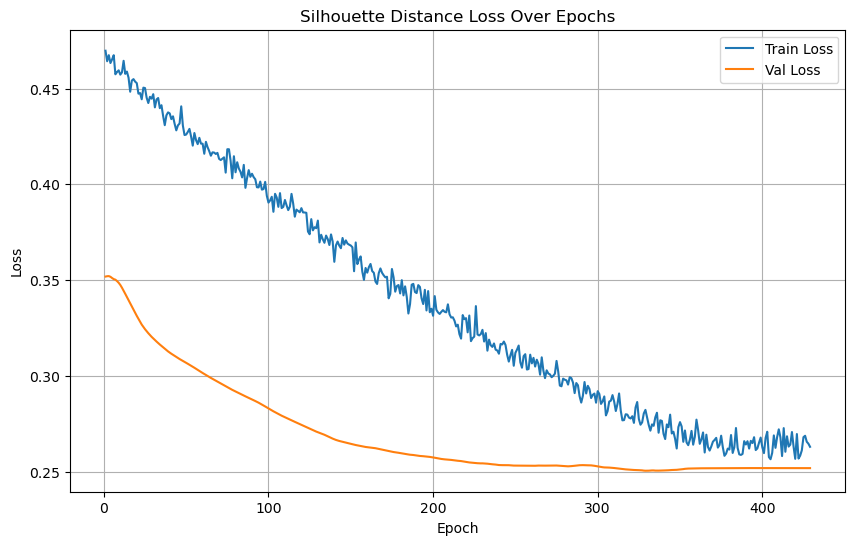

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/843], Loss: 0.0765


Test Batch [20/843], Loss: 0.1183
Test Batch [30/843], Loss: 0.0977
Test Batch [40/843], Loss: 0.1261
Test Batch [50/843], Loss: 0.1280
Test Batch [60/843], Loss: 0.1645


Test Batch [70/843], Loss: 0.5000
Test Batch [80/843], Loss: 0.1582
Test Batch [90/843], Loss: 0.1138


Test Batch [100/843], Loss: 0.2029
Test Batch [110/843], Loss: 0.5000
Test Batch [120/843], Loss: 0.1370
Test Batch [130/843], Loss: 0.1250
Test Batch [140/843], Loss: 0.1227


Test Batch [150/843], Loss: 0.1868
Test Batch [160/843], Loss: 0.2703
Test Batch [170/843], Loss: 0.1629


Test Batch [180/843], Loss: 0.1999
Test Batch [190/843], Loss: 0.1906


Test Batch [200/843], Loss: 0.0729
Test Batch [210/843], Loss: 0.0649


Test Batch [220/843], Loss: 0.1161
Test Batch [230/843], Loss: 0.1122
Test Batch [240/843], Loss: 0.1300


Test Batch [250/843], Loss: 0.1332


Test Batch [260/843], Loss: 0.2421
Test Batch [270/843], Loss: 0.2310
Test Batch [280/843], Loss: 0.3415


Test Batch [290/843], Loss: 0.2465


Test Batch [300/843], Loss: 0.2849
Test Batch [310/843], Loss: 0.3329
Test Batch [320/843], Loss: 0.1602
Test Batch [330/843], Loss: 0.3034


Test Batch [340/843], Loss: 0.3028
Test Batch [350/843], Loss: 0.5000


Test Batch [360/843], Loss: 0.0995
Test Batch [370/843], Loss: 0.5000
Test Batch [380/843], Loss: 0.5000
Test Batch [390/843], Loss: 0.5000
Test Batch [400/843], Loss: 0.5000
Test Batch [410/843], Loss: 0.5000
Test Batch [420/843], Loss: 0.5000
Test Batch [430/843], Loss: 0.0869
Test Batch [440/843], Loss: 0.1078


Test Batch [450/843], Loss: 0.1595
Test Batch [460/843], Loss: 0.1007
Test Batch [470/843], Loss: 0.1050
Test Batch [480/843], Loss: 0.1157
Test Batch [490/843], Loss: 0.5000
Test Batch [500/843], Loss: 0.1162
Test Batch [510/843], Loss: 0.1065


Test Batch [520/843], Loss: 0.1412
Test Batch [530/843], Loss: 0.1717
Test Batch [540/843], Loss: 0.1472
Test Batch [550/843], Loss: 0.2026
Test Batch [560/843], Loss: 0.1959


Test Batch [570/843], Loss: 0.1968
Test Batch [580/843], Loss: 0.1406
Test Batch [590/843], Loss: 0.1365
Test Batch [600/843], Loss: 0.5000
Test Batch [610/843], Loss: 0.1747
Test Batch [620/843], Loss: 0.0870


Test Batch [630/843], Loss: 0.1507
Test Batch [640/843], Loss: 0.0996
Test Batch [650/843], Loss: 0.3893
Test Batch [660/843], Loss: 0.4289
Test Batch [670/843], Loss: 0.1084


Test Batch [680/843], Loss: 0.1358
Test Batch [690/843], Loss: 0.2704
Test Batch [700/843], Loss: 0.1189
Test Batch [710/843], Loss: 0.1852
Test Batch [720/843], Loss: 0.0822


Test Batch [730/843], Loss: 0.2535
Test Batch [740/843], Loss: 0.5000
Test Batch [750/843], Loss: 0.5000
Test Batch [760/843], Loss: 0.1501
Test Batch [770/843], Loss: 0.1363


Test Batch [780/843], Loss: 0.2292
Test Batch [790/843], Loss: 0.5000
Test Batch [800/843], Loss: 0.1055
Test Batch [810/843], Loss: 0.1825
Test Batch [820/843], Loss: 0.5000
Test Batch [830/843], Loss: 0.0964
Test Batch [840/843], Loss: 0.5000

Test Loss: 0.2218


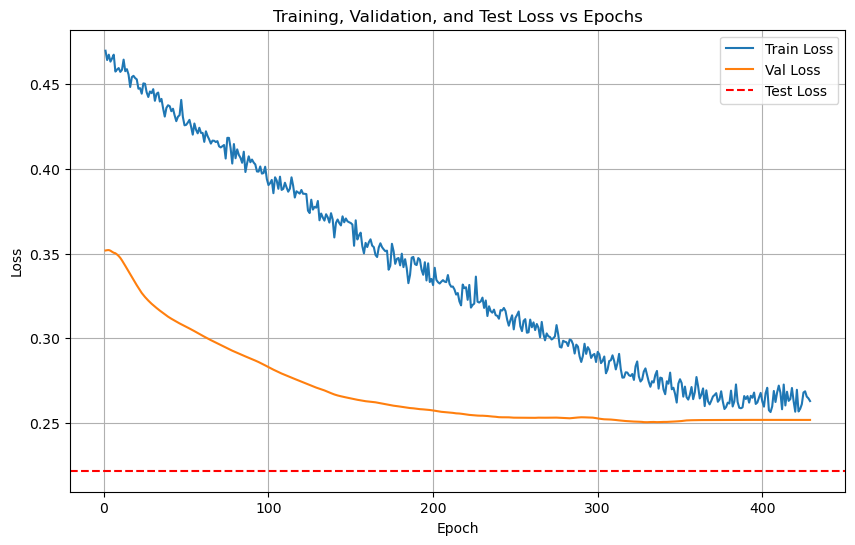

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/843 for test dataset.
  Processed batch 20/843 for test dataset.


  Processed batch 30/843 for test dataset.
  Processed batch 40/843 for test dataset.
  Processed batch 50/843 for test dataset.


  Processed batch 60/843 for test dataset.
  Processed batch 70/843 for test dataset.
  Processed batch 80/843 for test dataset.


  Processed batch 90/843 for test dataset.
  Processed batch 100/843 for test dataset.
  Processed batch 110/843 for test dataset.
  Processed batch 120/843 for test dataset.


  Processed batch 130/843 for test dataset.
  Processed batch 140/843 for test dataset.
  Processed batch 150/843 for test dataset.
  Processed batch 160/843 for test dataset.


  Processed batch 170/843 for test dataset.
  Processed batch 180/843 for test dataset.
  Processed batch 190/843 for test dataset.
  Processed batch 200/843 for test dataset.


  Processed batch 210/843 for test dataset.
  Processed batch 220/843 for test dataset.
  Processed batch 230/843 for test dataset.


  Processed batch 240/843 for test dataset.
  Processed batch 250/843 for test dataset.


  Processed batch 260/843 for test dataset.
  Processed batch 270/843 for test dataset.
  Processed batch 280/843 for test dataset.
  Processed batch 290/843 for test dataset.


  Processed batch 300/843 for test dataset.
  Processed batch 310/843 for test dataset.
  Processed batch 320/843 for test dataset.


  Processed batch 330/843 for test dataset.
  Processed batch 340/843 for test dataset.


  Processed batch 350/843 for test dataset.
  Processed batch 360/843 for test dataset.
  Processed batch 370/843 for test dataset.
  Processed batch 380/843 for test dataset.


  Processed batch 390/843 for test dataset.
  Processed batch 400/843 for test dataset.
  Processed batch 410/843 for test dataset.
  Processed batch 420/843 for test dataset.


  Processed batch 430/843 for test dataset.
  Processed batch 440/843 for test dataset.
  Processed batch 450/843 for test dataset.
  Processed batch 460/843 for test dataset.


  Processed batch 470/843 for test dataset.
  Processed batch 480/843 for test dataset.
  Processed batch 490/843 for test dataset.
  Processed batch 500/843 for test dataset.


  Processed batch 510/843 for test dataset.
  Processed batch 520/843 for test dataset.
  Processed batch 530/843 for test dataset.


  Processed batch 540/843 for test dataset.
  Processed batch 550/843 for test dataset.
  Processed batch 560/843 for test dataset.


  Processed batch 570/843 for test dataset.
  Processed batch 580/843 for test dataset.
  Processed batch 590/843 for test dataset.


  Processed batch 600/843 for test dataset.
  Processed batch 610/843 for test dataset.
  Processed batch 620/843 for test dataset.


  Processed batch 630/843 for test dataset.
  Processed batch 640/843 for test dataset.
  Processed batch 650/843 for test dataset.


  Processed batch 660/843 for test dataset.
  Processed batch 670/843 for test dataset.
  Processed batch 680/843 for test dataset.
  Processed batch 690/843 for test dataset.


  Processed batch 700/843 for test dataset.
  Processed batch 710/843 for test dataset.
  Processed batch 720/843 for test dataset.
  Processed batch 730/843 for test dataset.


  Processed batch 740/843 for test dataset.
  Processed batch 750/843 for test dataset.
  Processed batch 760/843 for test dataset.


  Processed batch 770/843 for test dataset.
  Processed batch 780/843 for test dataset.
  Processed batch 790/843 for test dataset.


  Processed batch 800/843 for test dataset.
  Processed batch 810/843 for test dataset.
  Processed batch 820/843 for test dataset.


  Processed batch 830/843 for test dataset.
  Processed batch 840/843 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.50      0.60      0.55         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7991  |  Val Loss: 2.7752
Validation loss improved from inf to 2.7752.
[Epoch 2/1000] Train Loss: 2.7803  |  Val Loss: 2.7571
Validation loss improved from 2.7752 to 2.7571.
[Epoch 3/1000] Train Loss: 2.7599  |  Val Loss: 2.7398
Validation loss improved from 2.7571 to 2.7398.
[Epoch 4/1000] Train Loss: 2.7408  |  Val Loss: 2.7223
Validation loss improved from 2.7398 to 2.7223.
[Epoch 5/1000] Train Loss: 2.7203  |  Val Loss: 2.7053
Validation loss improved from 2.7223 to 2.7053.
[Epoch 6/1000] Train Loss: 2.7018  |  Val Loss: 2.6883
Validation loss improved from 2.7053 to 2.6883.
[Epoch 7/1000] Train Loss: 2.6834  |  Val Loss: 2.6718
Validation loss improved from 2.6883 to 2.6718.
[Epoch 8/1000] Train Loss: 2.6658  |  Val Loss: 2.6561
Validation loss improved from 2.6718 to 2.6561.
[Epoch 9/1000] Train Loss: 2.6485  |  Val Loss: 2.6413
Validation loss improved from 2.6561 to 2.6413.
[Epoch 10/1000] Train Loss: 2.6323  |  Val Loss: 2.6270
Validation loss impr

[Epoch 25/1000] Train Loss: 2.3905  |  Val Loss: 2.4145
Validation loss improved from 2.4289 to 2.4145.
[Epoch 26/1000] Train Loss: 2.3746  |  Val Loss: 2.3999
Validation loss improved from 2.4145 to 2.3999.
[Epoch 27/1000] Train Loss: 2.3575  |  Val Loss: 2.3857
Validation loss improved from 2.3999 to 2.3857.
[Epoch 28/1000] Train Loss: 2.3412  |  Val Loss: 2.3714
Validation loss improved from 2.3857 to 2.3714.
[Epoch 29/1000] Train Loss: 2.3245  |  Val Loss: 2.3567
Validation loss improved from 2.3714 to 2.3567.
[Epoch 30/1000] Train Loss: 2.3072  |  Val Loss: 2.3419
Validation loss improved from 2.3567 to 2.3419.
[Epoch 31/1000] Train Loss: 2.2900  |  Val Loss: 2.3270
Validation loss improved from 2.3419 to 2.3270.


[Epoch 32/1000] Train Loss: 2.2732  |  Val Loss: 2.3120
Validation loss improved from 2.3270 to 2.3120.
[Epoch 33/1000] Train Loss: 2.2564  |  Val Loss: 2.2971
Validation loss improved from 2.3120 to 2.2971.
[Epoch 34/1000] Train Loss: 2.2385  |  Val Loss: 2.2826
Validation loss improved from 2.2971 to 2.2826.
[Epoch 35/1000] Train Loss: 2.2228  |  Val Loss: 2.2681
Validation loss improved from 2.2826 to 2.2681.
[Epoch 36/1000] Train Loss: 2.2060  |  Val Loss: 2.2537
Validation loss improved from 2.2681 to 2.2537.
[Epoch 37/1000] Train Loss: 2.1898  |  Val Loss: 2.2395
Validation loss improved from 2.2537 to 2.2395.
[Epoch 38/1000] Train Loss: 2.1738  |  Val Loss: 2.2253
Validation loss improved from 2.2395 to 2.2253.
[Epoch 39/1000] Train Loss: 2.1579  |  Val Loss: 2.2112
Validation loss improved from 2.2253 to 2.2112.
[Epoch 40/1000] Train Loss: 2.1425  |  Val Loss: 2.1972
Validation loss improved from 2.2112 to 2.1972.
[Epoch 41/1000] Train Loss: 2.1268  |  Val Loss: 2.1834
Validati

[Epoch 57/1000] Train Loss: 1.8825  |  Val Loss: 1.9669
Validation loss improved from 1.9803 to 1.9669.
[Epoch 58/1000] Train Loss: 1.8673  |  Val Loss: 1.9534
Validation loss improved from 1.9669 to 1.9534.
[Epoch 59/1000] Train Loss: 1.8517  |  Val Loss: 1.9401
Validation loss improved from 1.9534 to 1.9401.
[Epoch 60/1000] Train Loss: 1.8365  |  Val Loss: 1.9267
Validation loss improved from 1.9401 to 1.9267.
[Epoch 61/1000] Train Loss: 1.8213  |  Val Loss: 1.9134
Validation loss improved from 1.9267 to 1.9134.
[Epoch 62/1000] Train Loss: 1.8060  |  Val Loss: 1.9001
Validation loss improved from 1.9134 to 1.9001.


[Epoch 63/1000] Train Loss: 1.7909  |  Val Loss: 1.8867
Validation loss improved from 1.9001 to 1.8867.
[Epoch 64/1000] Train Loss: 1.7756  |  Val Loss: 1.8734
Validation loss improved from 1.8867 to 1.8734.
[Epoch 65/1000] Train Loss: 1.7603  |  Val Loss: 1.8600
Validation loss improved from 1.8734 to 1.8600.
[Epoch 66/1000] Train Loss: 1.7452  |  Val Loss: 1.8466
Validation loss improved from 1.8600 to 1.8466.
[Epoch 67/1000] Train Loss: 1.7299  |  Val Loss: 1.8331
Validation loss improved from 1.8466 to 1.8331.
[Epoch 68/1000] Train Loss: 1.7146  |  Val Loss: 1.8198
Validation loss improved from 1.8331 to 1.8198.
[Epoch 69/1000] Train Loss: 1.6997  |  Val Loss: 1.8063
Validation loss improved from 1.8198 to 1.8063.
[Epoch 70/1000] Train Loss: 1.6842  |  Val Loss: 1.7925
Validation loss improved from 1.8063 to 1.7925.
[Epoch 71/1000] Train Loss: 1.6686  |  Val Loss: 1.7789
Validation loss improved from 1.7925 to 1.7789.
[Epoch 72/1000] Train Loss: 1.6535  |  Val Loss: 1.7652
Validati

[Epoch 88/1000] Train Loss: 1.4044  |  Val Loss: 1.5464
Validation loss improved from 1.5602 to 1.5464.
[Epoch 89/1000] Train Loss: 1.3890  |  Val Loss: 1.5325
Validation loss improved from 1.5464 to 1.5325.
[Epoch 90/1000] Train Loss: 1.3734  |  Val Loss: 1.5187
Validation loss improved from 1.5325 to 1.5187.
[Epoch 91/1000] Train Loss: 1.3576  |  Val Loss: 1.5050
Validation loss improved from 1.5187 to 1.5050.
[Epoch 92/1000] Train Loss: 1.3420  |  Val Loss: 1.4913
Validation loss improved from 1.5050 to 1.4913.
[Epoch 93/1000] Train Loss: 1.3267  |  Val Loss: 1.4778
Validation loss improved from 1.4913 to 1.4778.
[Epoch 94/1000] Train Loss: 1.3114  |  Val Loss: 1.4643
Validation loss improved from 1.4778 to 1.4643.
[Epoch 95/1000] Train Loss: 1.2959  |  Val Loss: 1.4508
Validation loss improved from 1.4643 to 1.4508.
[Epoch 96/1000] Train Loss: 1.2805  |  Val Loss: 1.4375
Validation loss improved from 1.4508 to 1.4375.
[Epoch 97/1000] Train Loss: 1.2654  |  Val Loss: 1.4243
Validati

[Epoch 117/1000] Train Loss: 0.9786  |  Val Loss: 1.1755
Validation loss improved from 1.1873 to 1.1755.
[Epoch 118/1000] Train Loss: 0.9649  |  Val Loss: 1.1641
Validation loss improved from 1.1755 to 1.1641.
[Epoch 119/1000] Train Loss: 0.9519  |  Val Loss: 1.1526
Validation loss improved from 1.1641 to 1.1526.
[Epoch 120/1000] Train Loss: 0.9388  |  Val Loss: 1.1413
Validation loss improved from 1.1526 to 1.1413.
[Epoch 121/1000] Train Loss: 0.9258  |  Val Loss: 1.1302
Validation loss improved from 1.1413 to 1.1302.
[Epoch 122/1000] Train Loss: 0.9129  |  Val Loss: 1.1193
Validation loss improved from 1.1302 to 1.1193.
[Epoch 123/1000] Train Loss: 0.9001  |  Val Loss: 1.1083
Validation loss improved from 1.1193 to 1.1083.
[Epoch 124/1000] Train Loss: 0.8876  |  Val Loss: 1.0974
Validation loss improved from 1.1083 to 1.0974.
[Epoch 125/1000] Train Loss: 0.8750  |  Val Loss: 1.0866
Validation loss improved from 1.0974 to 1.0866.
[Epoch 126/1000] Train Loss: 0.8626  |  Val Loss: 1.076

[Epoch 147/1000] Train Loss: 0.6349  |  Val Loss: 0.8819
Validation loss improved from 0.8901 to 0.8819.
[Epoch 148/1000] Train Loss: 0.6258  |  Val Loss: 0.8737
Validation loss improved from 0.8819 to 0.8737.
[Epoch 149/1000] Train Loss: 0.6164  |  Val Loss: 0.8657
Validation loss improved from 0.8737 to 0.8657.
[Epoch 150/1000] Train Loss: 0.6073  |  Val Loss: 0.8581
Validation loss improved from 0.8657 to 0.8581.
[Epoch 151/1000] Train Loss: 0.5983  |  Val Loss: 0.8506
Validation loss improved from 0.8581 to 0.8506.
[Epoch 152/1000] Train Loss: 0.5895  |  Val Loss: 0.8433
Validation loss improved from 0.8506 to 0.8433.
[Epoch 153/1000] Train Loss: 0.5811  |  Val Loss: 0.8360
Validation loss improved from 0.8433 to 0.8360.
[Epoch 154/1000] Train Loss: 0.5726  |  Val Loss: 0.8289
Validation loss improved from 0.8360 to 0.8289.
[Epoch 155/1000] Train Loss: 0.5639  |  Val Loss: 0.8220
Validation loss improved from 0.8289 to 0.8220.
[Epoch 156/1000] Train Loss: 0.5558  |  Val Loss: 0.815

[Epoch 176/1000] Train Loss: 0.4145  |  Val Loss: 0.6992
Validation loss improved from 0.7044 to 0.6992.
[Epoch 177/1000] Train Loss: 0.4085  |  Val Loss: 0.6940
Validation loss improved from 0.6992 to 0.6940.
[Epoch 178/1000] Train Loss: 0.4026  |  Val Loss: 0.6891
Validation loss improved from 0.6940 to 0.6891.
[Epoch 179/1000] Train Loss: 0.3969  |  Val Loss: 0.6844
Validation loss improved from 0.6891 to 0.6844.
[Epoch 180/1000] Train Loss: 0.3910  |  Val Loss: 0.6800
Validation loss improved from 0.6844 to 0.6800.
[Epoch 181/1000] Train Loss: 0.3856  |  Val Loss: 0.6755
Validation loss improved from 0.6800 to 0.6755.
[Epoch 182/1000] Train Loss: 0.3800  |  Val Loss: 0.6712
Validation loss improved from 0.6755 to 0.6712.
[Epoch 183/1000] Train Loss: 0.3746  |  Val Loss: 0.6671
Validation loss improved from 0.6712 to 0.6671.
[Epoch 184/1000] Train Loss: 0.3693  |  Val Loss: 0.6629
Validation loss improved from 0.6671 to 0.6629.
[Epoch 185/1000] Train Loss: 0.3638  |  Val Loss: 0.658

[Epoch 204/1000] Train Loss: 0.2777  |  Val Loss: 0.5931
Validation loss improved from 0.5957 to 0.5931.
[Epoch 205/1000] Train Loss: 0.2741  |  Val Loss: 0.5904
Validation loss improved from 0.5931 to 0.5904.
[Epoch 206/1000] Train Loss: 0.2704  |  Val Loss: 0.5879
Validation loss improved from 0.5904 to 0.5879.
[Epoch 207/1000] Train Loss: 0.2667  |  Val Loss: 0.5854
Validation loss improved from 0.5879 to 0.5854.
[Epoch 208/1000] Train Loss: 0.2632  |  Val Loss: 0.5829
Validation loss improved from 0.5854 to 0.5829.
[Epoch 209/1000] Train Loss: 0.2598  |  Val Loss: 0.5803
Validation loss improved from 0.5829 to 0.5803.
[Epoch 210/1000] Train Loss: 0.2563  |  Val Loss: 0.5777
Validation loss improved from 0.5803 to 0.5777.
[Epoch 211/1000] Train Loss: 0.2531  |  Val Loss: 0.5753
Validation loss improved from 0.5777 to 0.5753.
[Epoch 212/1000] Train Loss: 0.2498  |  Val Loss: 0.5730
Validation loss improved from 0.5753 to 0.5730.
[Epoch 213/1000] Train Loss: 0.2467  |  Val Loss: 0.570

[Epoch 234/1000] Train Loss: 0.1916  |  Val Loss: 0.5345
Validation loss improved from 0.5359 to 0.5345.
[Epoch 235/1000] Train Loss: 0.1896  |  Val Loss: 0.5330
Validation loss improved from 0.5345 to 0.5330.
[Epoch 236/1000] Train Loss: 0.1873  |  Val Loss: 0.5318
Validation loss improved from 0.5330 to 0.5318.
[Epoch 237/1000] Train Loss: 0.1852  |  Val Loss: 0.5304
Validation loss improved from 0.5318 to 0.5304.
[Epoch 238/1000] Train Loss: 0.1832  |  Val Loss: 0.5292
Validation loss improved from 0.5304 to 0.5292.
[Epoch 239/1000] Train Loss: 0.1812  |  Val Loss: 0.5279
Validation loss improved from 0.5292 to 0.5279.
[Epoch 240/1000] Train Loss: 0.1792  |  Val Loss: 0.5268
Validation loss improved from 0.5279 to 0.5268.
[Epoch 241/1000] Train Loss: 0.1773  |  Val Loss: 0.5258
Validation loss improved from 0.5268 to 0.5258.
[Epoch 242/1000] Train Loss: 0.1755  |  Val Loss: 0.5248
Validation loss improved from 0.5258 to 0.5248.
[Epoch 243/1000] Train Loss: 0.1735  |  Val Loss: 0.523

[Epoch 261/1000] Train Loss: 0.1446  |  Val Loss: 0.5089
Validation loss improved from 0.5095 to 0.5089.
[Epoch 262/1000] Train Loss: 0.1433  |  Val Loss: 0.5082
Validation loss improved from 0.5089 to 0.5082.
[Epoch 263/1000] Train Loss: 0.1420  |  Val Loss: 0.5074
Validation loss improved from 0.5082 to 0.5074.
[Epoch 264/1000] Train Loss: 0.1406  |  Val Loss: 0.5067
Validation loss improved from 0.5074 to 0.5067.
[Epoch 265/1000] Train Loss: 0.1394  |  Val Loss: 0.5062
Validation loss improved from 0.5067 to 0.5062.
[Epoch 266/1000] Train Loss: 0.1380  |  Val Loss: 0.5058
Validation loss improved from 0.5062 to 0.5058.
[Epoch 267/1000] Train Loss: 0.1369  |  Val Loss: 0.5054
Validation loss improved from 0.5058 to 0.5054.
[Epoch 268/1000] Train Loss: 0.1356  |  Val Loss: 0.5049
Validation loss improved from 0.5054 to 0.5049.
[Epoch 269/1000] Train Loss: 0.1344  |  Val Loss: 0.5043
Validation loss improved from 0.5049 to 0.5043.
[Epoch 270/1000] Train Loss: 0.1332  |  Val Loss: 0.503

[Epoch 289/1000] Train Loss: 0.1130  |  Val Loss: 0.4989
Validation loss improved from 0.4991 to 0.4989.
[Epoch 290/1000] Train Loss: 0.1122  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 291/1000] Train Loss: 0.1112  |  Val Loss: 0.4991
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 292/1000] Train Loss: 0.1103  |  Val Loss: 0.4989
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 293/1000] Train Loss: 0.1095  |  Val Loss: 0.4987
Validation loss improved from 0.4989 to 0.4987.
[Epoch 294/1000] Train Loss: 0.1086  |  Val Loss: 0.4983
Validation loss improved from 0.4987 to 0.4983.
[Epoch 295/1000] Train Loss: 0.1077  |  Val Loss: 0.4977
Validation loss improved from 0.4983 to 0.4977.
[Epoch 296/1000] Train Loss: 0.1069  |  Val Loss: 0.4972
Validation loss improved from 0.4977 to 0.4972.
[Epoch 297/1000] Train Loss: 0.1060  |  Val Loss: 0.4968
Validation loss improved from 0.4972 to 0.4968.
[Epoch 298/1000] Train Loss: 0.1051  

[Epoch 315/1000] Train Loss: 0.0925  |  Val Loss: 0.4961
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 316/1000] Train Loss: 0.0918  |  Val Loss: 0.4960
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 317/1000] Train Loss: 0.0912  |  Val Loss: 0.4961
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 318/1000] Train Loss: 0.0905  |  Val Loss: 0.4960
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 319/1000] Train Loss: 0.0899  |  Val Loss: 0.4959
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 320/1000] Train Loss: 0.0893  |  Val Loss: 0.4958
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 321/1000] Train Loss: 0.0887  |  Val Loss: 0.4957
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 322/1000] Train Loss: 0.0880  |  Val Loss: 0.4954
Validation loss improved from 0.4956 to 0.4954.
[Epoch 323/1000] Train Loss: 0.0875  |  Val Loss: 0.4953
Validation loss improved from 0.4954 to 0.4953.
[Epoch

[Epoch 346/1000] Train Loss: 0.0749  |  Val Loss: 0.4979
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 347/1000] Train Loss: 0.0743  |  Val Loss: 0.4980
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 348/1000] Train Loss: 0.0739  |  Val Loss: 0.4982
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 349/1000] Train Loss: 0.0734  |  Val Loss: 0.4984
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 350/1000] Train Loss: 0.0730  |  Val Loss: 0.4987
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 351/1000] Train Loss: 0.0726  |  Val Loss: 0.4988
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 352/1000] Train Loss: 0.0721  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 353/1000] Train Loss: 0.0716  |  Val Loss: 0.4992
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 354/1000] Train Loss: 0.0712  |  Val Loss: 0.4994
!! Validation loss did NOT improve !! Patience:

[Epoch 375/1000] Train Loss: 0.0628  |  Val Loss: 0.5025
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 376/1000] Train Loss: 0.0625  |  Val Loss: 0.5027
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 377/1000] Train Loss: 0.0621  |  Val Loss: 0.5029
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 378/1000] Train Loss: 0.0618  |  Val Loss: 0.5030
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 379/1000] Train Loss: 0.0614  |  Val Loss: 0.5030
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 380/1000] Train Loss: 0.0610  |  Val Loss: 0.5030
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 381/1000] Train Loss: 0.0607  |  Val Loss: 0.5033
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 382/1000] Train Loss: 0.0603  |  Val Loss: 0.5037
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 383/1000] Train Loss: 0.0600  |  Val Loss: 0.5041
!! Validation loss did NOT improve !! Patience:

[Epoch 404/1000] Train Loss: 0.0535  |  Val Loss: 0.5106
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 405/1000] Train Loss: 0.0533  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 406/1000] Train Loss: 0.0530  |  Val Loss: 0.5119
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 407/1000] Train Loss: 0.0526  |  Val Loss: 0.5123
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 408/1000] Train Loss: 0.0523  |  Val Loss: 0.5126
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 409/1000] Train Loss: 0.0520  |  Val Loss: 0.5127
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 410/1000] Train Loss: 0.0518  |  Val Loss: 0.5128
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 411/1000] Train Loss: 0.0516  |  Val Loss: 0.5127
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 412/1000] Train Loss: 0.0513  |  Val Loss: 0.5129
!! Validation loss did NOT improve !! Patience:

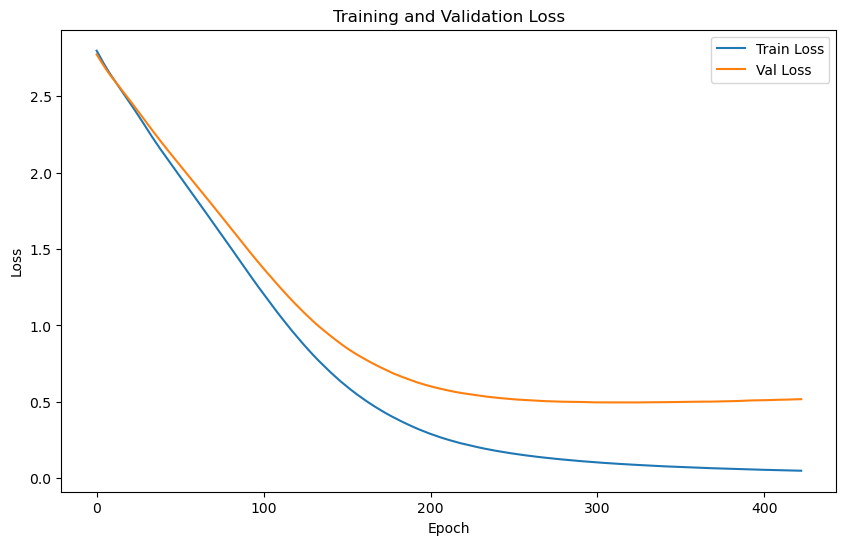

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.9303 | Test Accuracy: 78.85%


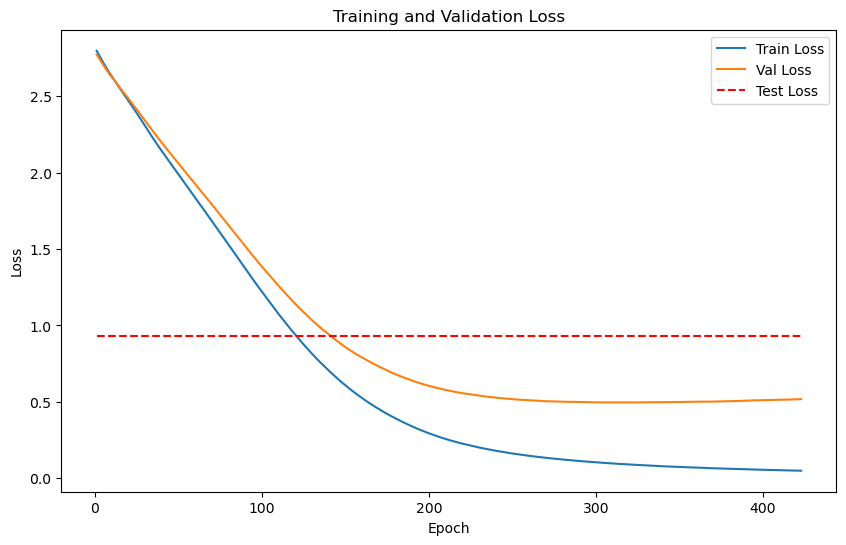

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


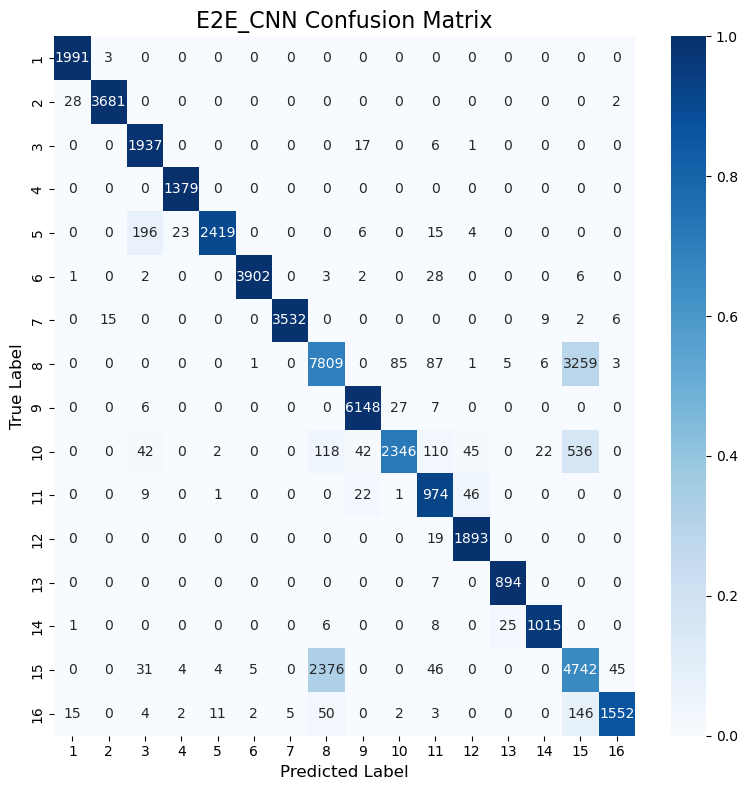

Classification Accuracy: 85.76%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


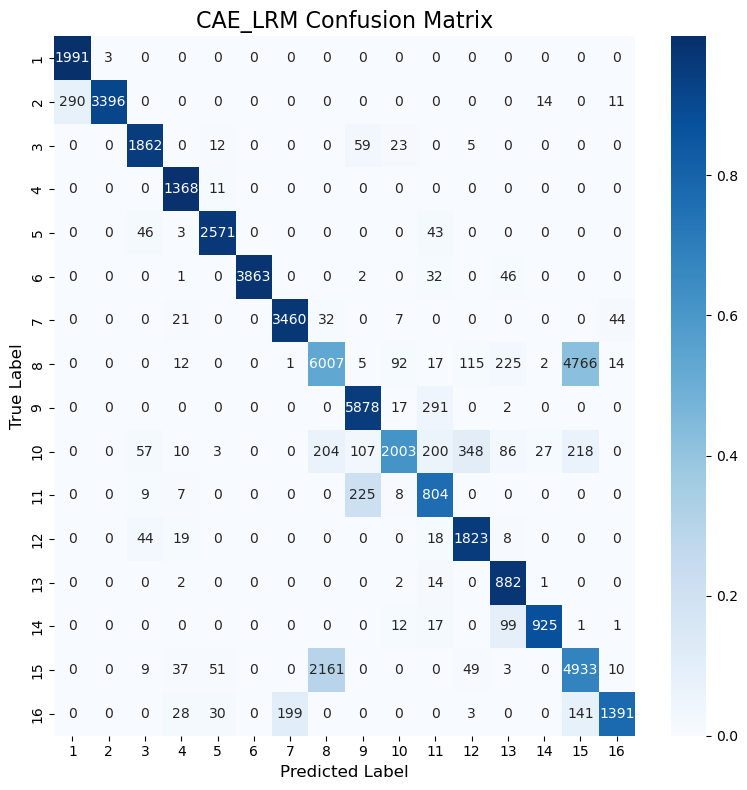

Classification Accuracy: 80.08%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


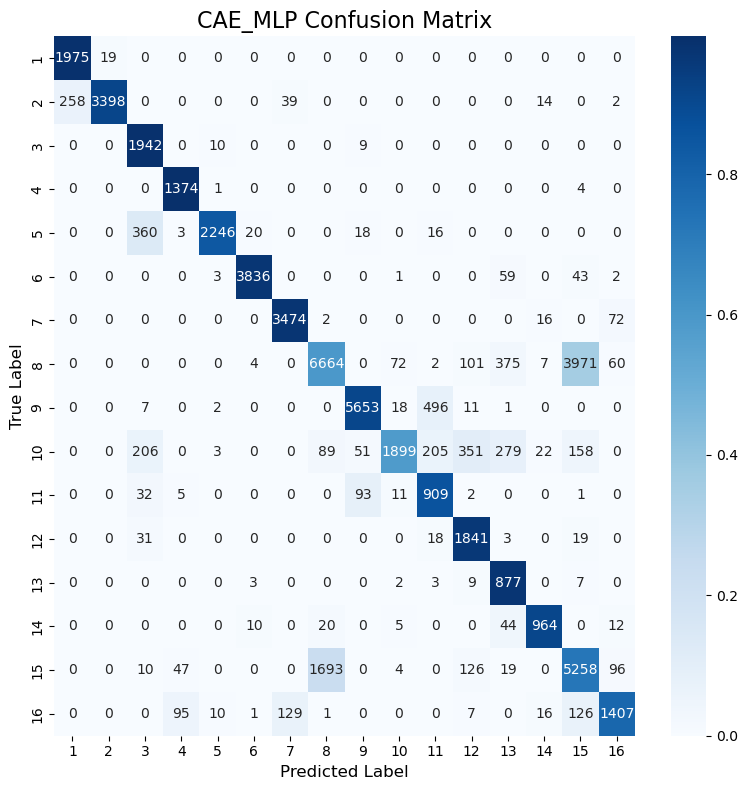

Classification Accuracy: 81.12%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


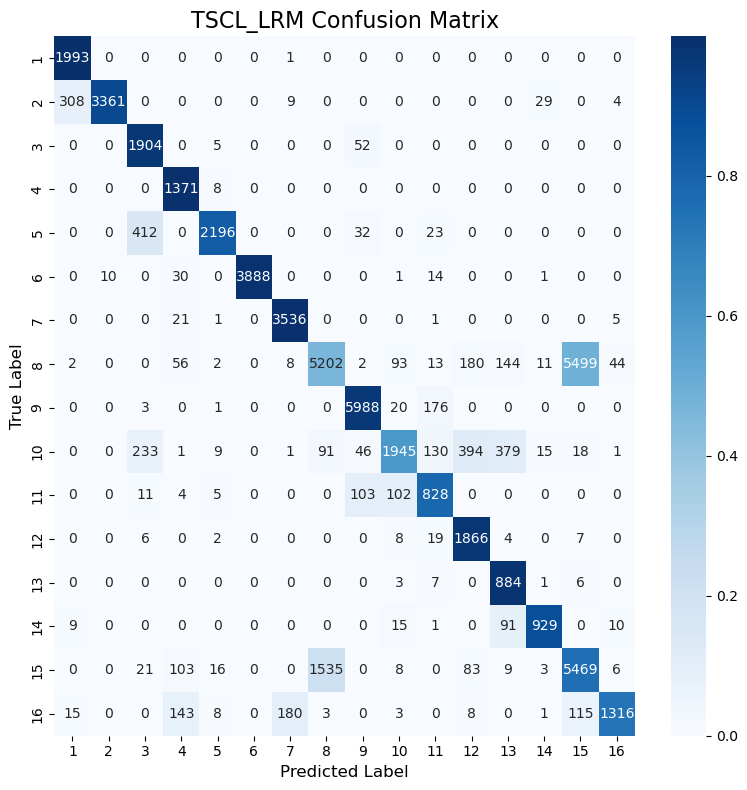

Classification Accuracy: 79.19%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


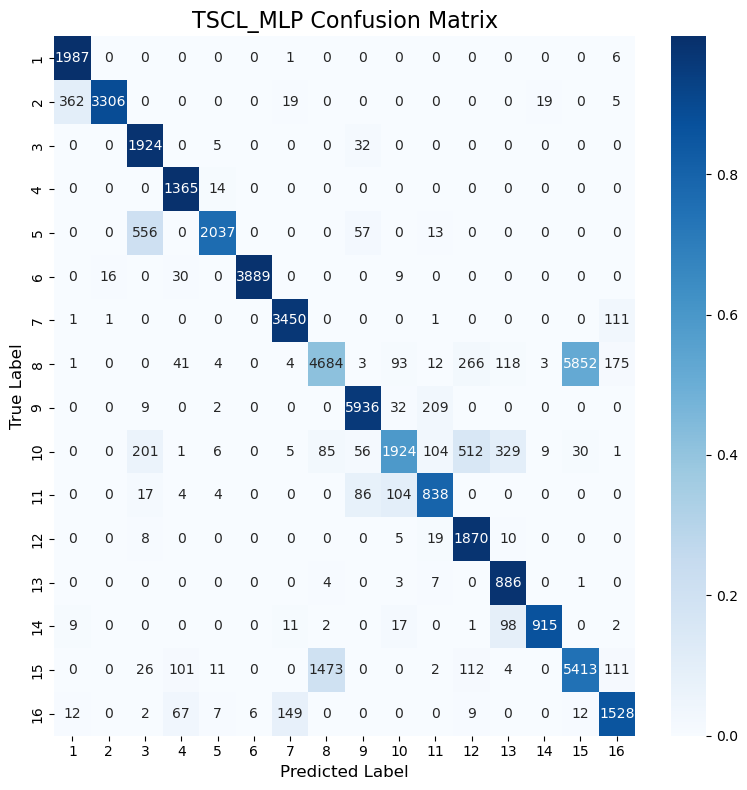

Classification Accuracy: 77.85%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


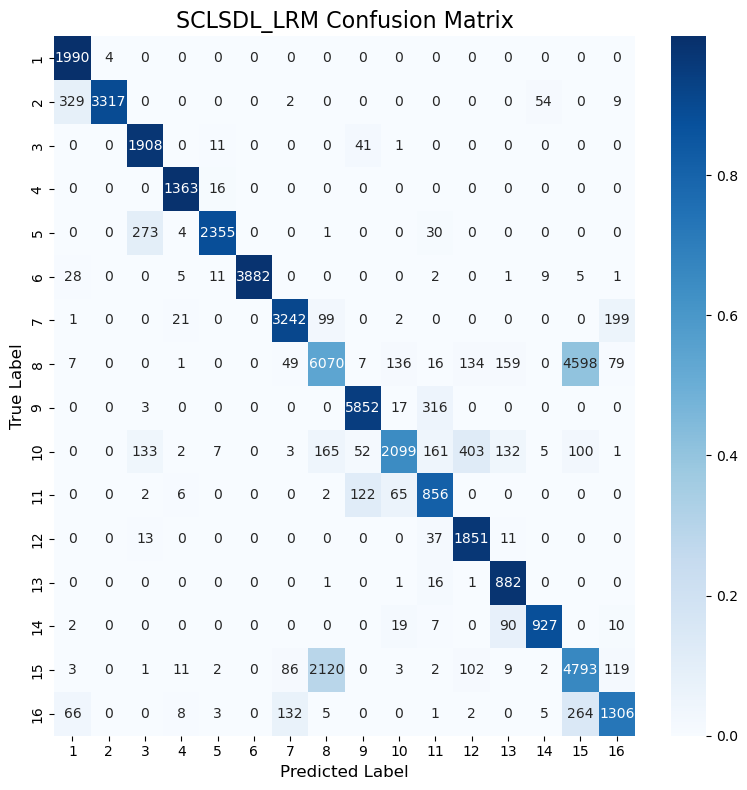

Classification Accuracy: 79.22%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


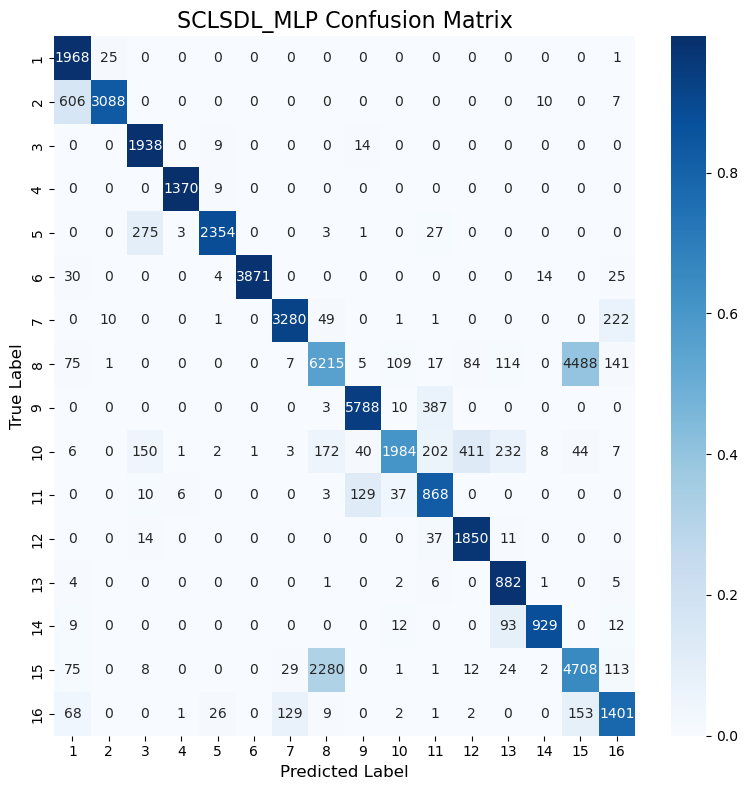

Classification Accuracy: 78.85%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          85.76
1    LRM (CAE)          80.08
2    MLP (CAE)          81.12
3     TSCL LRM          79.19
4     TSCL MLP          77.85
5  SCL_SDL LRM          79.22
6  SCL_SDL MLP          78.85

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          85.76
2    MLP (CAE)          81.12
1    LRM (CAE)          80.08
5  SCL_SDL LRM          79.22
3     TSCL LRM          79.19
6  SCL_SDL MLP          78.85
4     TSCL MLP          77.85
